# Importing TensorFlow

In [1]:
!nvidia-smi

Sun Jun 23 22:10:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              6W /  100W |      14MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-06-23 22:10:08.876322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 22:10:08.898151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 22:10:08.898169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 22:10:08.898734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 22:10:08.902602: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import os
import random
import scipy
import uuid
import shutil
import keras.backend as K
import time
import imageio
import base64
import IPython

# Creating a Lunar Lander environment

In [4]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

print(f"Input: {env.observation_space}")
print(f"Output: {env.action_space}")

Input: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Output: Discrete(4)


# Defining training loop functions

In [5]:
def masked_huber_loss(mask_value, clip_delta):
  def f(y_true, y_pred):
    error = y_true - y_pred
    cond  = K.abs(error) < clip_delta
    mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    masked_squared_error = 0.5 * K.square(mask_true * (y_true - y_pred))
    linear_loss  = mask_true * (clip_delta * K.abs(error) - 0.5 * (clip_delta ** 2))
    huber_loss = tf.where(cond, masked_squared_error, linear_loss)
    return K.sum(huber_loss) / K.sum(mask_true)
  f.__name__ = 'masked_huber_loss'
  return f

In [6]:
input_shape = (9,) # 8 variables in the environment + the fraction finished we add ourselves
outputs = 4

def create_model(learning_rate, regularization_factor):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=input_shape, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
    tf.keras.layers.Dense(outputs, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(regularization_factor))
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=masked_huber_loss(0.0, 1.0))
  
  return model

In [7]:
def get_q_values(model, state):
  input = state[np.newaxis, ...]
  return model.predict(input, verbose=0)[0]

def get_multiple_q_values(model, states):
  return model.predict(states, verbose=0)

In [8]:
def select_action_epsilon_greedy(q_values, epsilon):
  random_value = random.uniform(0, 1)
  if random_value < epsilon: 
    return random.randint(0, len(q_values) - 1)
  else:
    return np.argmax(q_values)

def select_best_action(q_values):
  return np.argmax(q_values)

In [9]:
class StateTransition():

  def __init__(self, old_state, action, reward, new_state, done):
    self.old_state = old_state
    self.action = action
    self.reward = reward
    self.new_state = new_state
    self.done = done

class ReplayBuffer():
  current_index = 0

  def __init__(self, size = 10000):
    self.size = size
    self.transitions = []

  def add(self, transition):
    if len(self.transitions) < self.size: 
      self.transitions.append(transition)
    else:
      self.transitions[self.current_index] = transition
      self.__increment_current_index()

  def length(self):
    return len(self.transitions)

  def get_batch(self, batch_size):
    return random.sample(self.transitions, batch_size)

  def __increment_current_index(self):
    self.current_index += 1
    if self.current_index >= self.size - 1: 
      self.current_index = 0
     

In [10]:
def calculate_target_values(model, target_model, state_transitions, discount_factor):
  states = []
  new_states = []
  for transition in state_transitions:
    states.append(transition.old_state)
    new_states.append(transition.new_state)

  states = np.array(states)
  new_states = np.array(new_states)

  q_values = get_multiple_q_values(model, states)
  q_values_target_model = get_multiple_q_values(target_model, states)

  q_values_new_state = get_multiple_q_values(model, new_states)
  q_values_new_state_target_model = get_multiple_q_values(target_model, new_states)
  
  targets = []
  for index, state_transition in enumerate(state_transitions):
    best_action = select_best_action(q_values_new_state[index])
    best_action_next_state_q_value = q_values_new_state_target_model[index][best_action]
    
    if state_transition.done:
      target_value = state_transition.reward
    else:
      target_value = state_transition.reward + discount_factor * best_action_next_state_q_value

    target_vector = [0, 0, 0, 0]
    target_vector[state_transition.action] = target_value
    targets.append(target_vector)

  return np.array(targets)

In [11]:
def train_model(model, states, targets):
  model.fit(states, targets, epochs=1, batch_size=len(targets), verbose=0) 

In [12]:
def copy_model(model):
  backup_file = 'backup_'+str(uuid.uuid4())
  model.save(backup_file)
  new_model = tf.keras.models.load_model(backup_file, custom_objects={ 'masked_huber_loss': masked_huber_loss(0.0, 1.0) })
  shutil.rmtree(backup_file)
  return new_model

In [13]:
class AverageRewardTracker():
  current_index = 0

  def __init__(self, num_rewards_for_average=100):
    self.num_rewards_for_average = num_rewards_for_average
    self.last_x_rewards = []

  def add(self, reward):
    if len(self.last_x_rewards) < self.num_rewards_for_average: 
      self.last_x_rewards.append(reward)
    else:
      self.last_x_rewards[self.current_index] = reward
      self.__increment_current_index()

  def __increment_current_index(self):
    self.current_index += 1
    if self.current_index >= self.num_rewards_for_average: 
      self.current_index = 0

  def get_average(self):
    return np.average(self.last_x_rewards)


class FileLogger():

  def __init__(self, file_name='progress.log'):
    self.file_name = file_name
    self.clean_progress_file()

  def log(self, episode, steps, reward, average_reward):
    f = open(self.file_name, 'a+')
    f.write(f"{episode};{steps};{reward};{average_reward}\n")
    f.close()

  def clean_progress_file(self):
    if os.path.exists(self.file_name):
      os.remove(self.file_name)
    f = open(self.file_name, 'a+')
    f.write("episode;steps;reward;average\n")
    f.close()

# Setting hyperparameters

In [14]:
replay_buffer_size = 200000
learning_rate = 0.001
regularization_factor = 0.001
training_batch_size = 128
training_start = 256
max_episodes = 1000
max_steps = 1000
target_network_replace_frequency_steps = 1000
model_backup_frequency_episodes = 100
starting_epsilon = 1.0
minimum_epsilon = 0.01
epsilon_decay_factor_per_episode = 0.995
discount_factor = 0.99
train_every_x_steps = 4

# Training

In [15]:
train_start = time.time()
replay_buffer = ReplayBuffer(replay_buffer_size)
model = create_model(learning_rate, regularization_factor)
target_model = copy_model(model)
epsilon = starting_epsilon
step_count = 0
average_reward_tracker = AverageRewardTracker(100)
file_logger = FileLogger()

for episode in range(max_episodes):
  print(f"Starting episode {episode} with epsilon {epsilon}")
  start = time.time()
    
  episode_reward = 0
  state = env.reset()[0]
  fraction_finished = 0.0
  state = np.append(state, fraction_finished)

  first_q_values = get_q_values(model, state)
  print(f"Q values: {first_q_values}")
  print(f"Max Q: {max(first_q_values)}")

  for step in range(1, max_steps + 1):
    step_count += 1
    q_values = get_q_values(model, state)
    action = select_action_epsilon_greedy(q_values, epsilon)
    new_state, reward, done, info, _ = env.step(action)
      
    fraction_finished = (step + 1) / max_steps
    new_state = np.append(new_state, fraction_finished)
    
    episode_reward += reward

    if step == max_steps:
      print(f"Episode reached the maximum number of steps. {max_steps}")
      done = True

    state_transition = StateTransition(state, action, reward, new_state, done)
    replay_buffer.add(state_transition)

    state = new_state

    if step_count % target_network_replace_frequency_steps == 0:
      print("Updating target model")
      target_model = copy_model(model)

    if replay_buffer.length() >= training_start and step_count % train_every_x_steps == 0:
      batch = replay_buffer.get_batch(batch_size=training_batch_size)
      targets = calculate_target_values(model, target_model, batch, discount_factor)
      states = np.array([state_transition.old_state for state_transition in batch])
      train_model(model, states, targets)

    if done:
      break

  average_reward_tracker.add(episode_reward)
  average = average_reward_tracker.get_average()

  end = time.time()    
  print(f"episode {episode} finished in {step} steps with reward {episode_reward}. Average reward over last 100: {average}. Time:{(end - start):.2f}s")
  file_logger.log(episode, step, episode_reward, average)

  if episode != 0 and episode % model_backup_frequency_episodes == 0:
    backup_file = f"model_{episode}.h5"
    print(f"Backing up model to {backup_file}")
    model.save(backup_file)

  epsilon *= epsilon_decay_factor_per_episode
  epsilon = max(minimum_epsilon, epsilon)

train_end = time.time()

print(f"Training time: {(train_start - train_end):.2f}s")

2024-06-23 22:10:10.863097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


INFO:tensorflow:Assets written to: backup_eb9da7a2-c078-441e-b742-7cb7601e8a46/assets


INFO:tensorflow:Assets written to: backup_eb9da7a2-c078-441e-b742-7cb7601e8a46/assets


Starting episode 0 with epsilon 1.0
Q values: [ 0.01771538 -0.04460072 -0.08665255  0.03510145]
Max Q: 0.035101454704999924


2024-06-23 22:10:11.617601: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


episode 0 finished in 119 steps with reward -404.5757788322784. Average reward over last 100: -404.5757788322784. Time:4.38s
Starting episode 1 with epsilon 0.995
Q values: [ 0.07033958  0.05043826 -0.11310121 -0.0684983 ]
Max Q: 0.07033957540988922
episode 1 finished in 64 steps with reward -120.61669740882633. Average reward over last 100: -262.59623812055236. Time:2.23s
Starting episode 2 with epsilon 0.990025
Q values: [ 0.07406607  0.05613963 -0.10207018 -0.0432443 ]
Max Q: 0.07406607270240784


2024-06-23 22:10:21.385418: I external/local_xla/xla/service/service.cc:168] XLA service 0x75b656201f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-23 22:10:21.385433: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-06-23 22:10:21.388228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-23 22:10:21.399349: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1719169821.437994 1757652 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


episode 2 finished in 84 steps with reward -75.5249373923991. Average reward over last 100: -200.23913787783462. Time:4.44s
Starting episode 3 with epsilon 0.985074875
Q values: [-0.0134688  -0.15108688 -0.13206615 -0.03304712]
Max Q: -0.013468803837895393
episode 3 finished in 104 steps with reward -165.65493607610725. Average reward over last 100: -191.59308742740276. Time:8.04s
Starting episode 4 with epsilon 0.9801495006250001
Q values: [-1.1072347  -1.7094611  -0.02130815 -1.3667607 ]
Max Q: -0.02130814641714096
episode 4 finished in 66 steps with reward -102.63566523417687. Average reward over last 100: -173.80160298875757. Time:5.21s
Starting episode 5 with epsilon 0.9752487531218751
Q values: [-1.8035021 -1.1362618  1.0036169 -2.1962824]
Max Q: 1.0036169290542603
episode 5 finished in 61 steps with reward -139.39849056304018. Average reward over last 100: -168.0677509178047. Time:4.62s
Starting episode 6 with epsilon 0.9703725093562657
Q values: [-0.87150264 -1.781914   -1.9181

INFO:tensorflow:Assets written to: backup_8cf8e3ff-d39b-4bbb-913a-1e7045af5a25/assets


episode 11 finished in 72 steps with reward -108.41155574886801. Average reward over last 100: -152.829090234737. Time:5.92s
Starting episode 12 with epsilon 0.9416228069143757
Q values: [ 0.34793827 -0.77514267 -1.7092166   1.8111871 ]
Max Q: 1.8111871480941772
episode 12 finished in 114 steps with reward -284.42361611869956. Average reward over last 100: -162.9517460719649. Time:8.79s
Starting episode 13 with epsilon 0.9369146928798039
Q values: [-0.50502366 -0.5719065   0.36204076 -0.6270944 ]
Max Q: 0.36204075813293457
episode 13 finished in 102 steps with reward -47.961032387238504. Average reward over last 100: -154.738123665913. Time:7.71s
Starting episode 14 with epsilon 0.9322301194154049
Q values: [-2.7115829e-04 -3.7965208e-01 -1.8429277e+00  1.1626669e+00]
Max Q: 1.162666916847229
episode 14 finished in 119 steps with reward -312.1173948047541. Average reward over last 100: -165.23007507516908. Time:9.35s
Starting episode 15 with epsilon 0.9275689688183278
Q values: [-0.167

INFO:tensorflow:Assets written to: backup_3fc45738-75f3-4ef6-bf70-2c2087b33a23/assets


episode 20 finished in 116 steps with reward -277.3285256757914. Average reward over last 100: -166.52422093035463. Time:9.29s
Starting episode 21 with epsilon 0.9000874278732445
Q values: [-0.01260946  0.24689561  0.60116184 -0.95213646]
Max Q: 0.6011618375778198
episode 21 finished in 87 steps with reward -40.22524879018003. Average reward over last 100: -160.7833585603467. Time:6.62s
Starting episode 22 with epsilon 0.8955869907338783
Q values: [0.451027   0.7063718  2.530415   0.09035096]
Max Q: 2.5304150581359863
episode 22 finished in 72 steps with reward -163.92824794336386. Average reward over last 100: -160.92009288134744. Time:5.81s
Starting episode 23 with epsilon 0.8911090557802088
Q values: [ 1.7207186  2.4192955 -1.5968393  1.8958454]
Max Q: 2.4192955493927
episode 23 finished in 138 steps with reward -223.90609404338045. Average reward over last 100: -163.54450959643216. Time:10.78s
Starting episode 24 with epsilon 0.8866535105013078
Q values: [1.5027045 0.6962618 0.6675

INFO:tensorflow:Assets written to: backup_131aeca6-2e9f-4feb-885a-0a49a75a46c6/assets


episode 29 finished in 102 steps with reward -200.07113951190473. Average reward over last 100: -162.68668706108028. Time:8.35s
Starting episode 30 with epsilon 0.8603841919146962
Q values: [4.466302  3.8842957 0.7188853 5.5685434]
Max Q: 5.568543434143066
episode 30 finished in 120 steps with reward -168.37889097389223. Average reward over last 100: -162.87030654213874. Time:9.88s
Starting episode 31 with epsilon 0.8560822709551227
Q values: [-0.07118706  1.4669769  -4.1315427  -1.1570512 ]
Max Q: 1.4669768810272217
episode 31 finished in 108 steps with reward -249.34194059301606. Average reward over last 100: -165.57254510622863. Time:8.52s
Starting episode 32 with epsilon 0.851801859600347
Q values: [2.4553294  0.63232565 3.2316954  3.8198888 ]
Max Q: 3.8198888301849365
episode 32 finished in 78 steps with reward -199.561734213551. Average reward over last 100: -166.60252053372324. Time:6.02s
Starting episode 33 with epsilon 0.8475428503023453
Q values: [6.820446  6.728889  2.54566 

INFO:tensorflow:Assets written to: backup_1d509bc2-383a-400a-bfd4-93d12306f60a/assets


episode 39 finished in 117 steps with reward -125.6028963861607. Average reward over last 100: -162.30647739854763. Time:9.65s
Starting episode 40 with epsilon 0.8183201210226743
Q values: [4.021253  3.0691757 2.6160681 5.0741925]
Max Q: 5.074192523956299
episode 40 finished in 131 steps with reward -84.79899869574491. Average reward over last 100: -160.41605108872315. Time:10.12s
Starting episode 41 with epsilon 0.8142285204175609
Q values: [5.28876   4.0027366 2.8285706 6.5272975]
Max Q: 6.527297496795654
episode 41 finished in 148 steps with reward -51.460891508474674. Average reward over last 100: -157.82188062252675. Time:11.67s
Starting episode 42 with epsilon 0.810157377815473
Q values: [8.289073 7.871329 4.210705 9.0132  ]
Max Q: 9.013199806213379
episode 42 finished in 143 steps with reward -216.47757024953813. Average reward over last 100: -159.1859664278061. Time:11.48s
Starting episode 43 with epsilon 0.8061065909263957
Q values: [3.8241754 2.2798414 5.6093354 5.3226256]
Ma

INFO:tensorflow:Assets written to: backup_34d9b670-8630-4946-b997-5e99e85c78dd/assets


episode 47 finished in 107 steps with reward -121.10880466358788. Average reward over last 100: -152.31809083832772. Time:8.67s
Starting episode 48 with epsilon 0.7861544476842928
Q values: [0.6968249  0.94787693 1.5890121  0.44964886]
Max Q: 1.5890121459960938
episode 48 finished in 112 steps with reward -135.89258487633046. Average reward over last 100: -151.98287643094002. Time:8.81s
Starting episode 49 with epsilon 0.7822236754458713
Q values: [5.011823  3.9927444 3.1308208 5.6597548]
Max Q: 5.659754753112793
episode 49 finished in 128 steps with reward -181.5829977869363. Average reward over last 100: -152.57487885805995. Time:10.73s
Starting episode 50 with epsilon 0.778312557068642
Q values: [10.085635  8.959206 12.941434 11.009797]
Max Q: 12.941433906555176
episode 50 finished in 77 steps with reward -20.466419189139188. Average reward over last 100: -149.98451690376737. Time:6.17s
Starting episode 51 with epsilon 0.7744209942832988
Q values: [7.2590146 8.728259  3.356992  6.33

INFO:tensorflow:Assets written to: backup_9bfdaa0c-f2ab-4d04-a350-fb05cbb014a8/assets


episode 56 finished in 144 steps with reward -23.42236193284768. Average reward over last 100: -143.39909877785857. Time:12.18s
Starting episode 57 with epsilon 0.7514768435208588
Q values: [7.1800976 9.4751005 3.4856358 5.6079826]
Max Q: 9.47510051727295
episode 57 finished in 107 steps with reward -105.1137654077707. Average reward over last 100: -142.7390068232019. Time:8.93s
Starting episode 58 with epsilon 0.7477194593032545
Q values: [3.1204622 3.9396927 1.9952178 1.9202378]
Max Q: 3.939692735671997
episode 58 finished in 148 steps with reward -37.91823919596929. Average reward over last 100: -140.9623836430793. Time:11.92s
Starting episode 59 with epsilon 0.7439808620067382
Q values: [13.954211 13.952003 17.036343 13.872868]
Max Q: 17.03634262084961
episode 59 finished in 81 steps with reward -5.298719588097214. Average reward over last 100: -138.70132257549628. Time:6.52s
Starting episode 60 with epsilon 0.7402609576967045
Q values: [4.1562924 2.5409832 3.3503928 5.6298585]
Max

INFO:tensorflow:Assets written to: backup_796de6a3-3bd3-4cde-bbd3-3d35b5cbeed4/assets


episode 65 finished in 73 steps with reward -77.86208939848646. Average reward over last 100: -133.84637317204547. Time:6.44s
Starting episode 66 with epsilon 0.7183288830986236
Q values: [ 7.9472413  7.454157  10.476265   7.9963245]
Max Q: 10.476264953613281
episode 66 finished in 92 steps with reward -73.27324444395568. Average reward over last 100: -132.94229662386502. Time:7.31s
Starting episode 67 with epsilon 0.7147372386831305
Q values: [6.323494  7.6473627 4.416955  4.726391 ]
Max Q: 7.64736270904541
episode 67 finished in 117 steps with reward -113.35210643408556. Average reward over last 100: -132.6542055916624. Time:9.09s
Starting episode 68 with epsilon 0.7111635524897149
Q values: [3.7931736 5.92311   4.6042566 1.3074402]
Max Q: 5.923110008239746
episode 68 finished in 95 steps with reward -76.94273218246161. Average reward over last 100: -131.84679293355805. Time:7.24s
Starting episode 69 with epsilon 0.7076077347272662
Q values: [ 8.136989  10.306554   4.714064   5.88079

INFO:tensorflow:Assets written to: backup_b10c3a3b-16c3-48d8-bdfa-c72ceaadd20b/assets


episode 75 finished in 119 steps with reward -74.7986533063018. Average reward over last 100: -126.84609003974705. Time:9.45s
Starting episode 76 with epsilon 0.6832098777212641
Q values: [5.96267   6.0341754 8.230404  5.8038354]
Max Q: 8.230403900146484
episode 76 finished in 142 steps with reward -127.827224526284. Average reward over last 100: -126.8588320460657. Time:10.94s
Starting episode 77 with epsilon 0.6797938283326578
Q values: [ 9.459182  8.298386 11.50032  10.37719 ]
Max Q: 11.500320434570312
episode 77 finished in 130 steps with reward -90.49982911904627. Average reward over last 100: -126.39269098289878. Time:11.38s
Starting episode 78 with epsilon 0.6763948591909945
Q values: [7.69392   9.920214  5.1391234 5.0949564]
Max Q: 9.92021369934082
episode 78 finished in 114 steps with reward -96.72230971958957. Average reward over last 100: -126.01711653652778. Time:9.39s
Starting episode 79 with epsilon 0.6730128848950395
Q values: [ 8.67042   6.234165 10.130184 11.083785]
Ma

INFO:tensorflow:Assets written to: backup_22beba52-f98d-48b4-8640-13d8f5df454b/assets


episode 83 finished in 164 steps with reward -53.91163217214425. Average reward over last 100: -124.00944546827648. Time:13.43s
Starting episode 84 with epsilon 0.6563549768288433
Q values: [2.0686471 2.8451223 2.4664226 1.0990356]
Max Q: 2.8451223373413086
episode 84 finished in 185 steps with reward -91.32517771821367. Average reward over last 100: -123.62492467121693. Time:15.71s
Starting episode 85 with epsilon 0.653073201944699
Q values: [12.717062 13.453127 10.644542 12.04419 ]
Max Q: 13.453126907348633
episode 85 finished in 125 steps with reward 19.74125440132741. Average reward over last 100: -121.95787607735014. Time:10.20s
Starting episode 86 with epsilon 0.6498078359349755
Q values: [13.530082 15.422758 10.727734 11.68186 ]
Max Q: 15.422758102416992
episode 86 finished in 192 steps with reward -17.79787216796447. Average reward over last 100: -120.76063465310432. Time:15.12s
Starting episode 87 with epsilon 0.6465587967553006
Q values: [12.468837 12.535635 10.120005 11.9394

INFO:tensorflow:Assets written to: backup_c1435971-3523-473f-b139-7045e8c0fe94/assets


episode 89 finished in 112 steps with reward -24.194094795737513. Average reward over last 100: -118.79943952035306. Time:9.71s
Starting episode 90 with epsilon 0.6369088258938781
Q values: [6.7505455 9.32247   6.9365225 4.1161747]
Max Q: 9.322469711303711
episode 90 finished in 93 steps with reward -156.38634149275612. Average reward over last 100: -119.21248239917068. Time:7.73s
Starting episode 91 with epsilon 0.6337242817644086
Q values: [11.1672535  7.8477573 11.851682  14.176435 ]
Max Q: 14.176435470581055
episode 91 finished in 66 steps with reward -48.571468150999614. Average reward over last 100: -118.44464528777753. Time:5.22s
Starting episode 92 with epsilon 0.6305556603555866
Q values: [9.881418  9.5486355 7.715256  9.293015 ]
Max Q: 9.881418228149414
episode 92 finished in 184 steps with reward -13.610090236787187. Average reward over last 100: -117.31739200765935. Time:14.23s
Starting episode 93 with epsilon 0.6274028820538087
Q values: [14.146959 12.170131 16.089565 15.7

INFO:tensorflow:Assets written to: backup_f36a58fe-3904-4a5a-acb0-af565d312d6f/assets


episode 97 finished in 84 steps with reward -51.61278327980505. Average reward over last 100: -114.309565816835. Time:7.24s
Starting episode 98 with epsilon 0.6118738784280476
Q values: [12.710688 14.383667 10.127091 10.844006]
Max Q: 14.3836669921875
episode 98 finished in 211 steps with reward 39.98532534438323. Average reward over last 100: -112.75103156268128. Time:16.23s
Starting episode 99 with epsilon 0.6088145090359074
Q values: [8.001612  5.6217074 7.1434917 9.690616 ]
Max Q: 9.6906156539917
episode 99 finished in 136 steps with reward -75.7613210482956. Average reward over last 100: -112.38113445753743. Time:11.67s
Starting episode 100 with epsilon 0.6057704364907278
Q values: [13.532263 15.13978  11.158239 11.519151]
Max Q: 15.139780044555664
episode 100 finished in 143 steps with reward -77.02929126680826. Average reward over last 100: -109.10566958188274. Time:12.12s
Backing up model to model_100.h5
Starting episode 101 with epsilon 0.6027415843082742
Q values: [12.844504 

/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


episode 101 finished in 148 steps with reward 17.12319114573124. Average reward over last 100: -107.72827069633715. Time:11.69s
Starting episode 102 with epsilon 0.5997278763867329
Q values: [13.362541 15.773661 15.003447 10.519798]
Max Q: 15.773660659790039
episode 102 finished in 93 steps with reward -15.646602293084655. Average reward over last 100: -107.129487345344. Time:7.12s
Starting episode 103 with epsilon 0.5967292370047992
Q values: [6.354132  8.6006365 5.778604  3.543537 ]
Max Q: 8.60063648223877
episode 103 finished in 177 steps with reward 51.92347726733476. Average reward over last 100: -104.95370321190961. Time:15.59s
Starting episode 104 with epsilon 0.5937455908197752
Q values: [ 8.686453   5.9477167  8.666014  11.2626095]
Max Q: 11.262609481811523
Updating target model
INFO:tensorflow:Assets written to: backup_7981eef2-b13b-4160-912e-822fea8259cc/assets


INFO:tensorflow:Assets written to: backup_7981eef2-b13b-4160-912e-822fea8259cc/assets


episode 104 finished in 122 steps with reward -4.249502624105929. Average reward over last 100: -103.9698415858089. Time:10.20s
Starting episode 105 with epsilon 0.5907768628656763
Q values: [7.7506533 5.9577904 8.513809  9.11846  ]
Max Q: 9.118459701538086
episode 105 finished in 194 steps with reward -0.6859574965528736. Average reward over last 100: -102.58271625514402. Time:16.23s
Starting episode 106 with epsilon 0.5878229785513479
Q values: [17.021326 13.211121 17.42389  20.15223 ]
Max Q: 20.15222930908203
episode 106 finished in 118 steps with reward -4.666555188071229. Average reward over last 100: -102.01699375892466. Time:10.19s
Starting episode 107 with epsilon 0.5848838636585911
Q values: [13.667166 13.655917 11.607599 13.279908]
Max Q: 13.667165756225586
episode 107 finished in 185 steps with reward -79.49975428753845. Average reward over last 100: -101.25874315469733. Time:14.89s
Starting episode 108 with epsilon 0.5819594443402982
Q values: [16.64692   15.7208805 18.2018

INFO:tensorflow:Assets written to: backup_2ab90559-ca63-4f7b-bc9e-70054da8880a/assets


episode 110 finished in 196 steps with reward -15.525038119140262. Average reward over last 100: -96.41761280304976. Time:16.19s
Starting episode 111 with epsilon 0.5732736268885887
Q values: [22.235708 19.770933 23.613228 24.500185]
Max Q: 24.500185012817383
episode 111 finished in 84 steps with reward -39.71990942140188. Average reward over last 100: -95.73069633977511. Time:7.53s
Starting episode 112 with epsilon 0.5704072587541458
Q values: [5.5704336 7.2361164 6.088115  3.3181953]
Max Q: 7.236116409301758
episode 112 finished in 216 steps with reward 7.758835993561576. Average reward over last 100: -92.80887181865249. Time:18.31s
Starting episode 113 with epsilon 0.567555222460375
Q values: [6.711694  7.1634927 7.6238275 5.7527404]
Max Q: 7.6238274574279785
episode 113 finished in 186 steps with reward -84.68374832188283. Average reward over last 100: -93.17609897799893. Time:14.47s
Starting episode 114 with epsilon 0.5647174463480732
Q values: [16.464813 17.479923 14.124858 15.14

INFO:tensorflow:Assets written to: backup_95c67d3a-7a02-4b94-9ac8-a840866a1cf6/assets


Episode reached the maximum number of steps. 1000
episode 115 finished in 1000 steps with reward 16.941479885825615. Average reward over last 100: -87.79684559189738. Time:81.00s
Starting episode 116 with epsilon 0.5590843898207511
Q values: [7.898005  9.74362   7.9021645 5.7566957]
Max Q: 9.743619918823242
episode 116 finished in 183 steps with reward 20.786795134682905. Average reward over last 100: -86.66624623411417. Time:14.75s
Starting episode 117 with epsilon 0.5562889678716474
Q values: [21.557245 19.899982 22.823118 22.852468]
Max Q: 22.852468490600586
episode 117 finished in 96 steps with reward -32.56912761213388. Average reward over last 100: -86.20975165638978. Time:8.22s
Starting episode 118 with epsilon 0.5535075230322891
Q values: [23.476934 21.884127 24.981283 24.663496]
Max Q: 24.98128318786621
Updating target model
INFO:tensorflow:Assets written to: backup_5f9dd7ff-92eb-44f5-9b6b-3bfbf4651968/assets


INFO:tensorflow:Assets written to: backup_5f9dd7ff-92eb-44f5-9b6b-3bfbf4651968/assets


episode 118 finished in 105 steps with reward -18.223736591265023. Average reward over last 100: -84.90617696680945. Time:8.73s
Starting episode 119 with epsilon 0.5507399854171277
Q values: [17.721321 20.867882 18.143984 14.41618 ]
Max Q: 20.867881774902344
episode 119 finished in 78 steps with reward -98.61900380996525. Average reward over last 100: -83.32465803843087. Time:6.06s
Starting episode 120 with epsilon 0.547986285490042
Q values: [8.31345  6.695864 7.602734 9.095323]
Max Q: 9.095322608947754
episode 120 finished in 164 steps with reward -102.09541868477774. Average reward over last 100: -81.57232696852074. Time:13.73s
Starting episode 121 with epsilon 0.5452463540625918
Q values: [18.279184 19.612482 19.502838 16.176529]
Max Q: 19.61248207092285
episode 121 finished in 102 steps with reward -14.886494582047973. Average reward over last 100: -81.31893942643941. Time:8.84s
Starting episode 122 with epsilon 0.5425201222922789
Q values: [10.267624 10.671621  8.874959  9.070028

INFO:tensorflow:Assets written to: backup_3039fb18-471d-44d0-ad55-d4dd78681cfc/assets


episode 124 finished in 199 steps with reward -81.12591075297739. Average reward over last 100: -78.41176793143295. Time:16.72s
Starting episode 125 with epsilon 0.5344229416520513
Q values: [24.566988 21.94085  25.255508 26.715904]
Max Q: 26.715904235839844
episode 125 finished in 145 steps with reward -60.8245753080034. Average reward over last 100: -78.4360758535042. Time:12.52s
Starting episode 126 with epsilon 0.531750826943791
Q values: [16.001595 16.482882 14.025026 15.130154]
Max Q: 16.482881546020508
episode 126 finished in 206 steps with reward -20.465271233983373. Average reward over last 100: -75.91757793810538. Time:17.57s
Starting episode 127 with epsilon 0.5290920728090721
Q values: [11.911172 12.387382 10.487838 10.754283]
Max Q: 12.387381553649902
episode 127 finished in 212 steps with reward -43.711450205462185. Average reward over last 100: -75.27376902856221. Time:17.27s
Starting episode 128 with epsilon 0.5264466124450268
Q values: [17.439875 17.41746  15.255271 16

INFO:tensorflow:Assets written to: backup_f8d046d4-1a15-47d2-93dc-955830b3c02e/assets


episode 130 finished in 144 steps with reward -80.53364282982685. Average reward over last 100: -71.70152412241343. Time:13.29s
Starting episode 131 with epsilon 0.5185893309484582
Q values: [18.279093 15.754565 18.501667 20.060566]
Max Q: 20.060565948486328
episode 131 finished in 150 steps with reward -42.95155394272159. Average reward over last 100: -69.63762025591048. Time:12.51s
Starting episode 132 with epsilon 0.5159963842937159
Q values: [26.788177 23.519749 26.36484  29.307852]
Max Q: 29.307851791381836
episode 132 finished in 66 steps with reward -74.23901730784532. Average reward over last 100: -68.38439308685342. Time:5.35s
Starting episode 133 with epsilon 0.5134164023722473
Q values: [20.5247   22.71789  21.068972 17.898296]
Max Q: 22.7178897857666
episode 133 finished in 503 steps with reward -150.24407414554787. Average reward over last 100: -65.95225798462289. Time:42.17s
Starting episode 134 with epsilon 0.510849320360386
Q values: [19.164162 19.252558 16.939093 18.78

INFO:tensorflow:Assets written to: backup_5d394f31-15c4-4891-b771-e0b63e582c85/assets


Episode reached the maximum number of steps. 1000
episode 134 finished in 1000 steps with reward 0.07585871038839542. Average reward over last 100: -65.73101324016184. Time:81.85s
Starting episode 135 with epsilon 0.5082950737585841
Q values: [19.266222 19.95178  19.956276 18.066767]
Max Q: 19.956275939941406
episode 135 finished in 87 steps with reward 0.6758861503211477. Average reward over last 100: -63.373656977038806. Time:7.62s
Starting episode 136 with epsilon 0.5057535983897912
Q values: [19.381603 19.772253 16.538437 18.633785]
Max Q: 19.772253036499023
Updating target model
INFO:tensorflow:Assets written to: backup_9cca45a5-1359-413b-a723-54684fec5b58/assets


INFO:tensorflow:Assets written to: backup_9cca45a5-1359-413b-a723-54684fec5b58/assets


episode 136 finished in 253 steps with reward -15.091615226806113. Average reward over last 100: -62.92630746527112. Time:20.48s
Starting episode 137 with epsilon 0.5032248303978422
Q values: [21.386604 19.85047  18.437038 22.401249]
Max Q: 22.401248931884766
episode 137 finished in 227 steps with reward -2.286745875029709. Average reward over last 100: -61.79655699381881. Time:19.40s
Starting episode 138 with epsilon 0.500708706245853
Q values: [14.6936   13.341181 12.518251 15.499026]
Max Q: 15.49902629852295
episode 138 finished in 276 steps with reward -46.96633376124747. Average reward over last 100: -61.835033108903865. Time:22.25s
Starting episode 139 with epsilon 0.4982051627146237
Q values: [30.981092 29.340296 32.279797 32.159813]
Max Q: 32.2797966003418
episode 139 finished in 123 steps with reward 19.517629627523178. Average reward over last 100: -60.38382784876703. Time:10.87s
Starting episode 140 with epsilon 0.49571413690105054
Q values: [12.880871 12.959092 10.912229 12

INFO:tensorflow:Assets written to: backup_168c572a-eb8d-4f62-b053-a192b8199c74/assets


episode 140 finished in 186 steps with reward 12.024910575179703. Average reward over last 100: -59.41558875605778. Time:16.31s
Starting episode 141 with epsilon 0.4932355662165453
Q values: [14.305702 12.991971 12.421197 14.807045]
Max Q: 14.807044982910156
episode 141 finished in 185 steps with reward 11.831279381603338. Average reward over last 100: -58.78266704715699. Time:15.14s
Starting episode 142 with epsilon 0.4907693883854626
Q values: [19.55926  17.797604 19.70045  20.899202]
Max Q: 20.899202346801758
episode 142 finished in 153 steps with reward 5.716065484419303. Average reward over last 100: -56.56073068981742. Time:13.18s
Starting episode 143 with epsilon 0.4883155414435353
Q values: [18.572653 19.530725 15.983276 17.06658 ]
Max Q: 19.530725479125977
episode 143 finished in 136 steps with reward -30.557044321117075. Average reward over last 100: -56.18366949815955. Time:11.09s
Starting episode 144 with epsilon 0.4858739637363176
Q values: [24.663694 26.927952 24.09094  2

INFO:tensorflow:Assets written to: backup_fda7a53e-033a-4757-a313-389419e2afc0/assets


episode 147 finished in 397 steps with reward -269.1074073538918. Average reward over last 100: -56.06901178461189. Time:33.89s
Starting episode 148 with epsilon 0.47622912292284103
Q values: [15.160945 13.595538 13.954454 15.864007]
Max Q: 15.864006996154785
episode 148 finished in 109 steps with reward -16.245383729030692. Average reward over last 100: -54.87253977313889. Time:8.55s
Starting episode 149 with epsilon 0.4738479773082268
Q values: [3.5150647 3.4761028 3.0683246 3.108701 ]
Max Q: 3.5150647163391113
episode 149 finished in 178 steps with reward -29.509587967611225. Average reward over last 100: -53.351805674945645. Time:15.65s
Starting episode 150 with epsilon 0.47147873742168567
Q values: [19.611418 19.222126 17.334513 20.03802 ]
Max Q: 20.03801918029785
episode 150 finished in 236 steps with reward -102.7341070452508. Average reward over last 100: -54.174482553506756. Time:19.43s
Starting episode 151 with epsilon 0.46912134373457726
Q values: [18.656296 18.121284 16.471

INFO:tensorflow:Assets written to: backup_2a866d08-4dc3-49a6-9d81-59eaa192cb53/assets


episode 151 finished in 214 steps with reward -18.986480522074515. Average reward over last 100: -53.41076214153838. Time:17.73s
Starting episode 152 with epsilon 0.46677573701590436
Q values: [22.705652 23.272964 20.724718 22.539726]
Max Q: 23.272964477539062
episode 152 finished in 201 steps with reward 30.095761915941154. Average reward over last 100: -52.64539245704439. Time:15.73s
Starting episode 153 with epsilon 0.46444185833082485
Q values: [33.13584  30.995695 33.274437 34.703262]
Max Q: 34.70326232910156
episode 153 finished in 278 steps with reward -35.69354529471221. Average reward over last 100: -52.099909347204814. Time:23.29s
Starting episode 154 with epsilon 0.46211964903917074
Q values: [30.026611 32.19317  29.716383 27.848063]
Max Q: 32.19316864013672
episode 154 finished in 101 steps with reward 18.310671526540332. Average reward over last 100: -49.91100304093934. Time:7.95s
Starting episode 155 with epsilon 0.4598090507939749
Q values: [16.29122  15.227886 16.33115 

INFO:tensorflow:Assets written to: backup_139a3ce7-c1b6-4668-a7e2-c6b8ed9cd527/assets


episode 155 finished in 521 steps with reward -173.42134710412037. Average reward over last 100: -50.960272885161466. Time:41.99s
Starting episode 156 with epsilon 0.457510005540005
Q values: [5.5300474 5.461225  4.9018173 5.1759515]
Max Q: 5.530047416687012
episode 156 finished in 138 steps with reward -23.31960588201879. Average reward over last 100: -50.95924532465318. Time:11.69s
Starting episode 157 with epsilon 0.45522245551230495
Q values: [18.233599 18.280622 16.184828 17.789751]
Max Q: 18.280622482299805
episode 157 finished in 188 steps with reward -26.14704578560675. Average reward over last 100: -50.169578128431546. Time:16.32s
Starting episode 158 with epsilon 0.4529463432347434
Q values: [15.976062 16.491215 14.014442 15.223244]
Max Q: 16.491214752197266
episode 158 finished in 126 steps with reward -14.856106937709356. Average reward over last 100: -49.93895680584894. Time:10.01s
Starting episode 159 with epsilon 0.4506816115185697
Q values: [29.913954 28.373716 30.09262

INFO:tensorflow:Assets written to: backup_dee79143-23ed-4f36-86c8-9809a9bac814/assets


episode 161 finished in 279 steps with reward -15.244107799625795. Average reward over last 100: -47.87019878064634. Time:23.58s
Starting episode 162 with epsilon 0.4439551321314536
Q values: [20.922018 19.500093 19.30632  21.682476]
Max Q: 21.682476043701172
episode 162 finished in 201 steps with reward -203.74758290808396. Average reward over last 100: -49.01025881023172. Time:16.92s
Starting episode 163 with epsilon 0.4417353564707963
Q values: [24.236368 25.271059 22.57158  22.918959]
Max Q: 25.271059036254883
episode 163 finished in 91 steps with reward -58.47066630041901. Average reward over last 100: -48.74181526822136. Time:7.08s
Starting episode 164 with epsilon 0.43952667968844233
Q values: [20.907751 20.856258 17.619537 20.694069]
Max Q: 20.907751083374023
Updating target model
INFO:tensorflow:Assets written to: backup_9f8326ef-2cd6-48b8-8ce9-779be5ce5c35/assets


INFO:tensorflow:Assets written to: backup_9f8326ef-2cd6-48b8-8ce9-779be5ce5c35/assets


Episode reached the maximum number of steps. 1000
episode 164 finished in 1000 steps with reward -0.21734337582763708. Average reward over last 100: -47.98820575007797. Time:86.24s
Starting episode 165 with epsilon 0.43732904629000013
Q values: [41.29374  42.99562  41.103653 39.57933 ]
Max Q: 42.99562072753906
episode 165 finished in 99 steps with reward -13.174563980211005. Average reward over last 100: -47.34133049589522. Time:9.21s
Starting episode 166 with epsilon 0.4351424010585501
Q values: [36.324738 37.881325 35.87461  34.329655]
Max Q: 37.881324768066406
episode 166 finished in 92 steps with reward -77.07807297867163. Average reward over last 100: -47.37937878124237. Time:7.96s
Starting episode 167 with epsilon 0.43296668905325736
Q values: [21.105532 21.441547 21.312222 20.564144]
Max Q: 21.441547393798828
episode 167 finished in 135 steps with reward 5.632987025019673. Average reward over last 100: -46.18952784665132. Time:11.64s
Starting episode 168 with epsilon 0.430801855

INFO:tensorflow:Assets written to: backup_ca4fc39a-6a90-4793-aac2-885672d22e4f/assets


episode 168 finished in 117 steps with reward 22.500246278158983. Average reward over last 100: -45.19509806204512. Time:9.99s
Starting episode 169 with epsilon 0.4286478463299511
Q values: [8.283543  8.649716  7.337761  7.8064814]
Max Q: 8.6497163772583
episode 169 finished in 338 steps with reward -430.5047011871271. Average reward over last 100: -48.47785277586454. Time:27.60s
Starting episode 170 with epsilon 0.42650460709830135
Q values: [22.409937 21.348068 21.068718 23.08912 ]
Max Q: 23.089120864868164
Updating target model
INFO:tensorflow:Assets written to: backup_5480af3c-b241-4d67-8e4f-56c2a08fe69e/assets


INFO:tensorflow:Assets written to: backup_5480af3c-b241-4d67-8e4f-56c2a08fe69e/assets


Episode reached the maximum number of steps. 1000
episode 170 finished in 1000 steps with reward -81.55232373813548. Average reward over last 100: -48.58876994861275. Time:83.40s
Starting episode 171 with epsilon 0.42437208406280985
Q values: [22.387403 22.935982 20.788618 21.569784]
Max Q: 22.93598175048828
episode 171 finished in 120 steps with reward -66.88372715851185. Average reward over last 100: -49.23804631313262. Time:10.60s
Starting episode 172 with epsilon 0.4222502236424958
Q values: [38.74611  39.842575 38.535538 37.2743  ]
Max Q: 39.84257507324219
episode 172 finished in 103 steps with reward 15.477031202186652. Average reward over last 100: -48.12722118707809. Time:8.55s
Starting episode 173 with epsilon 0.42013897252428334
Q values: [39.964546 38.86666  39.961052 40.593903]
Max Q: 40.593902587890625
episode 173 finished in 149 steps with reward 51.730943558888754. Average reward over last 100: -46.39705319825722. Time:12.02s
Starting episode 174 with epsilon 0.418038277

INFO:tensorflow:Assets written to: backup_5438c4e0-aed0-489e-85f1-48f4eb7b1a38/assets


episode 175 finished in 869 steps with reward -194.75544260097655. Average reward over last 100: -46.82468286270179. Time:73.65s
Starting episode 176 with epsilon 0.41386834584198684
Q values: [16.897797 16.856218 14.653429 16.490536]
Max Q: 16.897796630859375
episode 176 finished in 187 steps with reward 2.270709941204572. Average reward over last 100: -45.523703518026906. Time:16.39s
Starting episode 177 with epsilon 0.4117990041127769
Q values: [38.302788 39.27146  37.93199  37.042706]
Max Q: 39.271461486816406
Updating target model
INFO:tensorflow:Assets written to: backup_b9bfd8a1-6def-4dc1-9fcf-e562e20c644b/assets


INFO:tensorflow:Assets written to: backup_b9bfd8a1-6def-4dc1-9fcf-e562e20c644b/assets


episode 177 finished in 788 steps with reward -254.93207893203544. Average reward over last 100: -47.1680260161568. Time:66.52s
Starting episode 178 with epsilon 0.40974000909221303
Q values: [25.234055 25.286713 25.164988 24.934942]
Max Q: 25.286712646484375
episode 178 finished in 265 steps with reward -29.300840050266615. Average reward over last 100: -46.49381131946357. Time:22.62s
Starting episode 179 with epsilon 0.40769130904675194
Q values: [45.16841 46.38219 45.27635 43.87206]
Max Q: 46.3821907043457
episode 179 finished in 82 steps with reward 8.279355039406099. Average reward over last 100: -45.75549755283094. Time:6.52s
Starting episode 180 with epsilon 0.40565285250151817
Q values: [11.632974 11.350779 10.170263 11.61592 ]
Max Q: 11.632973670959473
Updating target model
INFO:tensorflow:Assets written to: backup_fcf6f183-9a17-40a4-96b4-8d430e2c3102/assets


INFO:tensorflow:Assets written to: backup_fcf6f183-9a17-40a4-96b4-8d430e2c3102/assets


episode 180 finished in 160 steps with reward -1.122769237973074. Average reward over last 100: -44.2615164176182. Time:14.89s
Starting episode 181 with epsilon 0.4036245882390106
Q values: [32.172848 31.673927 31.827337 32.476036]
Max Q: 32.476036071777344
episode 181 finished in 120 steps with reward 32.53528758974588. Average reward over last 100: -43.09268721029682. Time:10.15s
Starting episode 182 with epsilon 0.4016064652978155
Q values: [20.546928 20.105635 18.533997 20.939945]
Max Q: 20.939945220947266
episode 182 finished in 121 steps with reward -8.258192423322. Average reward over last 100: -42.10417870201114. Time:9.68s
Starting episode 183 with epsilon 0.3995984329713264
Q values: [29.60365  28.973091 29.555687 30.206532]
Max Q: 30.206531524658203
Updating target model
INFO:tensorflow:Assets written to: backup_aa1366c2-04f2-46e5-8052-b02437c1ea94/assets


INFO:tensorflow:Assets written to: backup_aa1366c2-04f2-46e5-8052-b02437c1ea94/assets


Episode reached the maximum number of steps. 1000
episode 183 finished in 1000 steps with reward -70.3556393497699. Average reward over last 100: -42.2686187737874. Time:82.91s
Starting episode 184 with epsilon 0.3976004408064698
Q values: [20.807741 21.109442 17.637018 20.413923]
Max Q: 21.10944175720215
episode 184 finished in 293 steps with reward -105.82661976932098. Average reward over last 100: -42.41363319429847. Time:24.77s
Starting episode 185 with epsilon 0.39561243860243744
Q values: [16.310228 15.686061 15.32703  16.76577 ]
Max Q: 16.765769958496094
episode 185 finished in 161 steps with reward -28.034484507909767. Average reward over last 100: -42.89139058339084. Time:12.54s
Starting episode 186 with epsilon 0.3936343764094253
Q values: [21.448214 21.610466 18.720968 21.204044]
Max Q: 21.61046600341797
Updating target model
INFO:tensorflow:Assets written to: backup_6af9cb4e-0e84-45fd-85b9-df06f8aac400/assets


INFO:tensorflow:Assets written to: backup_6af9cb4e-0e84-45fd-85b9-df06f8aac400/assets


episode 186 finished in 229 steps with reward -66.34086018725218. Average reward over last 100: -43.37682046358372. Time:19.53s
Starting episode 187 with epsilon 0.39166620452737816
Q values: [22.173422 22.348324 19.13018  22.033865]
Max Q: 22.348323822021484
episode 187 finished in 124 steps with reward -66.20078052011883. Average reward over last 100: -42.75504783367582. Time:9.51s
Starting episode 188 with epsilon 0.3897078735047413
Q values: [21.398592 20.453821 19.589148 22.293352]
Max Q: 22.293352127075195
Updating target model
INFO:tensorflow:Assets written to: backup_aa503b9c-faf5-4108-840b-872b88e25118/assets


INFO:tensorflow:Assets written to: backup_aa503b9c-faf5-4108-840b-872b88e25118/assets


episode 188 finished in 870 steps with reward -81.12673476758115. Average reward over last 100: -43.2342931443011. Time:73.64s
Starting episode 189 with epsilon 0.3877593341372176
Q values: [27.44467  28.161161 25.353859 27.026628]
Max Q: 28.161161422729492
episode 189 finished in 125 steps with reward -46.519829746970046. Average reward over last 100: -43.457550493813436. Time:9.80s
Starting episode 190 with epsilon 0.3858205374665315
Q values: [41.21505  40.292725 40.05073  41.690353]
Max Q: 41.69035339355469
episode 190 finished in 78 steps with reward 25.536701254267882. Average reward over last 100: -41.638320066343184. Time:6.93s
Starting episode 191 with epsilon 0.38389143477919885
Q values: [37.766205 36.972977 36.3468   37.84916 ]
Max Q: 37.849159240722656
episode 191 finished in 76 steps with reward 1.233593214496068. Average reward over last 100: -41.14026945268824. Time:6.73s
Starting episode 192 with epsilon 0.3819719776053028
Q values: [4.6242213 4.7811794 4.009112  4.333

INFO:tensorflow:Assets written to: backup_b8413217-d740-4758-ab63-eb896d5358e7/assets


Episode reached the maximum number of steps. 1000
episode 192 finished in 1000 steps with reward -78.60814051073773. Average reward over last 100: -41.79024995542773. Time:84.80s
Starting episode 193 with epsilon 0.3800621177172763
Q values: [16.586937 16.47345  14.724067 16.500542]
Max Q: 16.586936950683594
Updating target model
INFO:tensorflow:Assets written to: backup_c9c153a2-89e6-4978-b1cc-6c522383751e/assets


INFO:tensorflow:Assets written to: backup_c9c153a2-89e6-4978-b1cc-6c522383751e/assets


Episode reached the maximum number of steps. 1000
episode 193 finished in 1000 steps with reward -23.108350828010703. Average reward over last 100: -41.331895338914634. Time:86.92s
Starting episode 194 with epsilon 0.37816180712868996
Q values: [33.990406 33.641285 33.495117 34.01822 ]
Max Q: 34.018218994140625
episode 194 finished in 85 steps with reward 6.008649840566065. Average reward over last 100: -40.56498160708314. Time:7.13s
Starting episode 195 with epsilon 0.37627099809304654
Q values: [26.055193 26.111372 25.389858 25.850248]
Max Q: 26.111371994018555
Updating target model
INFO:tensorflow:Assets written to: backup_b04b00cb-f313-49b2-8b90-b06407f9fcdb/assets


INFO:tensorflow:Assets written to: backup_b04b00cb-f313-49b2-8b90-b06407f9fcdb/assets


Episode reached the maximum number of steps. 1000
episode 195 finished in 1000 steps with reward -34.03725704334152. Average reward over last 100: -40.16254455667645. Time:84.84s
Starting episode 196 with epsilon 0.3743896431025813
Q values: [20.226795 20.169615 18.134565 20.102686]
Max Q: 20.226795196533203
episode 196 finished in 195 steps with reward -201.56788658874513. Average reward over last 100: -41.915226301045976. Time:16.47s
Starting episode 197 with epsilon 0.37251769488706843
Q values: [28.74193  29.247402 26.273249 28.030348]
Max Q: 29.24740219116211
episode 197 finished in 90 steps with reward -21.348347226778515. Average reward over last 100: -41.61258194051572. Time:7.18s
Starting episode 198 with epsilon 0.3706551064126331
Q values: [21.25008  20.469433 19.384905 22.275614]
Max Q: 22.27561378479004
Updating target model
INFO:tensorflow:Assets written to: backup_bfe13f42-2725-45c2-9a23-000dbd11ad9a/assets


INFO:tensorflow:Assets written to: backup_bfe13f42-2725-45c2-9a23-000dbd11ad9a/assets


Episode reached the maximum number of steps. 1000
episode 198 finished in 1000 steps with reward 8.723062348265936. Average reward over last 100: -41.9252045704769. Time:82.01s
Starting episode 199 with epsilon 0.36880183088056995
Q values: [3.8340673 3.9505122 3.4577131 3.553369 ]
Max Q: 3.950512170791626
Updating target model
INFO:tensorflow:Assets written to: backup_696d8da8-7a7a-4b6f-a1a8-583e172eac0e/assets


INFO:tensorflow:Assets written to: backup_696d8da8-7a7a-4b6f-a1a8-583e172eac0e/assets


Episode reached the maximum number of steps. 1000
episode 199 finished in 1000 steps with reward -91.32199469788442. Average reward over last 100: -42.080811306972784. Time:83.59s
Starting episode 200 with epsilon 0.3669578217261671
Q values: [23.187815 22.05985  21.014164 23.724525]
Max Q: 23.724525451660156
episode 200 finished in 91 steps with reward -79.95688257819967. Average reward over last 100: -42.11008722008669. Time:8.11s
Backing up model to model_200.h5
Starting episode 201 with epsilon 0.36512303261753626
Q values: [21.376942 20.449778 19.397165 21.969162]
Max Q: 21.969161987304688


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Updating target model
INFO:tensorflow:Assets written to: backup_4d1c2dc2-bf00-4d02-8cb6-ce4872835236/assets


INFO:tensorflow:Assets written to: backup_4d1c2dc2-bf00-4d02-8cb6-ce4872835236/assets


Episode reached the maximum number of steps. 1000
episode 201 finished in 1000 steps with reward 7.66767985520914. Average reward over last 100: -42.20464233299191. Time:84.73s
Starting episode 202 with epsilon 0.3632974174544486
Q values: [39.731316 39.111053 38.79335  40.21708 ]
Max Q: 40.217079162597656
Updating target model
INFO:tensorflow:Assets written to: backup_91bc15f7-9125-4b23-b8c8-5ab731278766/assets


INFO:tensorflow:Assets written to: backup_91bc15f7-9125-4b23-b8c8-5ab731278766/assets


Episode reached the maximum number of steps. 1000
episode 202 finished in 1000 steps with reward -6.829165261877327. Average reward over last 100: -42.11646796267984. Time:85.46s
Starting episode 203 with epsilon 0.3614809303671764
Q values: [28.754465 28.259586 27.27527  28.93521 ]
Max Q: 28.935209274291992
episode 203 finished in 91 steps with reward -16.764893283043833. Average reward over last 100: -42.803351668183616. Time:7.40s
Starting episode 204 with epsilon 0.3596735257153405
Q values: [47.359257 46.609455 45.982853 47.67383 ]
Max Q: 47.673828125
episode 204 finished in 80 steps with reward -6.598038075840222. Average reward over last 100: -42.82683702270096. Time:6.41s
Starting episode 205 with epsilon 0.3578751580867638
Q values: [33.943535 33.984093 31.771187 33.69734 ]
Max Q: 33.984092712402344
Updating target model
INFO:tensorflow:Assets written to: backup_85f70f39-f3ea-4a4e-aaf7-229b52b6fba3/assets


INFO:tensorflow:Assets written to: backup_85f70f39-f3ea-4a4e-aaf7-229b52b6fba3/assets


episode 205 finished in 97 steps with reward -52.022193178112516. Average reward over last 100: -43.340199379516555. Time:9.08s
Starting episode 206 with epsilon 0.35608578229633
Q values: [22.841022 22.66171  21.691433 23.009426]
Max Q: 23.00942611694336
Updating target model
INFO:tensorflow:Assets written to: backup_2eb28792-fd8e-4e19-bd33-17e3aabe7752/assets


INFO:tensorflow:Assets written to: backup_2eb28792-fd8e-4e19-bd33-17e3aabe7752/assets


Episode reached the maximum number of steps. 1000
episode 206 finished in 1000 steps with reward 0.18809608968836855. Average reward over last 100: -43.29165286673896. Time:84.46s
Starting episode 207 with epsilon 0.3543053533848483
Q values: [38.258823 38.452747 36.484356 37.96943 ]
Max Q: 38.4527473449707
episode 207 finished in 105 steps with reward 29.35079596223642. Average reward over last 100: -42.203147364241225. Time:8.62s
Starting episode 208 with epsilon 0.35253382661792404
Q values: [24.67303  24.125412 22.88444  24.913334]
Max Q: 24.913333892822266
episode 208 finished in 119 steps with reward -43.60542073706115. Average reward over last 100: -42.99050560381419. Time:9.35s
Starting episode 209 with epsilon 0.3507711574848344
Q values: [37.133163 37.353817 35.218697 37.22688 ]
Max Q: 37.353816986083984
Updating target model
INFO:tensorflow:Assets written to: backup_dd1a7d35-69bf-4554-931a-4d4b7a6a771c/assets


INFO:tensorflow:Assets written to: backup_dd1a7d35-69bf-4554-931a-4d4b7a6a771c/assets


Episode reached the maximum number of steps. 1000
episode 209 finished in 1000 steps with reward 18.319181884385902. Average reward over last 100: -42.44671646519825. Time:80.46s
Starting episode 210 with epsilon 0.34901730169741024
Q values: [28.621033 28.158981 26.342222 28.80139 ]
Max Q: 28.801389694213867
Updating target model
INFO:tensorflow:Assets written to: backup_61044ea0-e9c6-4d8a-a75d-165830b45ed6/assets


INFO:tensorflow:Assets written to: backup_61044ea0-e9c6-4d8a-a75d-165830b45ed6/assets


Episode reached the maximum number of steps. 1000
episode 210 finished in 1000 steps with reward -29.88203070036252. Average reward over last 100: -42.59028639101048. Time:83.43s
Starting episode 211 with epsilon 0.3472722151889232
Q values: [18.58068  18.420187 17.499933 18.613712]
Max Q: 18.613712310791016
episode 211 finished in 96 steps with reward -9.943296690134119. Average reward over last 100: -42.292520263697796. Time:8.64s
Starting episode 212 with epsilon 0.3455358541129786
Q values: [56.874767 56.49314  55.17293  57.170254]
Max Q: 57.17025375366211
episode 212 finished in 106 steps with reward 18.676559329905828. Average reward over last 100: -42.183343030334356. Time:9.17s
Starting episode 213 with epsilon 0.3438081748424137
Q values: [4.014063  3.9395833 3.4880254 4.524362 ]
Max Q: 4.524362087249756
Updating target model
INFO:tensorflow:Assets written to: backup_f2186850-5f36-43d3-9cc4-26cbc33f224f/assets


INFO:tensorflow:Assets written to: backup_f2186850-5f36-43d3-9cc4-26cbc33f224f/assets


Episode reached the maximum number of steps. 1000
episode 213 finished in 1000 steps with reward -48.37480228400682. Average reward over last 100: -41.8202535699556. Time:84.26s
Starting episode 214 with epsilon 0.3420891339682016
Q values: [33.26502  32.8453   31.564528 33.67323 ]
Max Q: 33.6732292175293
episode 214 finished in 86 steps with reward -42.68848028848838. Average reward over last 100: -42.68195141694835. Time:7.06s
Starting episode 215 with epsilon 0.3403786882983606
Q values: [44.33782  43.855007 43.07298  44.44673 ]
Max Q: 44.44673156738281
Updating target model
INFO:tensorflow:Assets written to: backup_5bbbed3f-5018-40e9-a731-bff4c8ef1a3c/assets


INFO:tensorflow:Assets written to: backup_5bbbed3f-5018-40e9-a731-bff4c8ef1a3c/assets


Episode reached the maximum number of steps. 1000
episode 215 finished in 1000 steps with reward -17.665613719039264. Average reward over last 100: -43.028022352997006. Time:84.55s
Starting episode 216 with epsilon 0.3386767948568688
Q values: [55.24417  55.70506  53.71509  55.332222]
Max Q: 55.70505905151367
episode 216 finished in 82 steps with reward -8.968463436181395. Average reward over last 100: -43.32557493870564. Time:6.81s
Starting episode 217 with epsilon 0.33698341088258443
Q values: [23.11143  23.38084  19.987053 22.95911 ]
Max Q: 23.380840301513672
episode 217 finished in 133 steps with reward -26.558742691072524. Average reward over last 100: -43.26547108949503. Time:11.79s
Starting episode 218 with epsilon 0.3352984938281715
Q values: [32.94068  32.66815  31.505474 33.3201  ]
Max Q: 33.320098876953125
episode 218 finished in 83 steps with reward -51.66744577386817. Average reward over last 100: -43.59990818132107. Time:7.16s
Starting episode 219 with epsilon 0.333622001

INFO:tensorflow:Assets written to: backup_c5250aae-6b0e-42f4-8a71-4cf35b8bca80/assets


episode 220 finished in 105 steps with reward 57.94601187160876. Average reward over last 100: -40.839539804861765. Time:9.25s
Starting episode 221 with epsilon 0.3302941218954743
Q values: [16.994587 17.251204 14.382873 16.391718]
Max Q: 17.251203536987305
Updating target model
INFO:tensorflow:Assets written to: backup_cae138c5-ef28-41ac-b3a2-f18fb764a74a/assets


INFO:tensorflow:Assets written to: backup_cae138c5-ef28-41ac-b3a2-f18fb764a74a/assets


Episode reached the maximum number of steps. 1000
episode 221 finished in 1000 steps with reward -44.61137447331256. Average reward over last 100: -41.13678860377441. Time:85.84s
Starting episode 222 with epsilon 0.32864265128599696
Q values: [21.967314 21.718159 19.54513  22.0112  ]
Max Q: 22.011199951171875
episode 222 finished in 137 steps with reward 33.65464922897294. Average reward over last 100: -39.53510617366718. Time:11.78s
Starting episode 223 with epsilon 0.326999438029567
Q values: [10.339109  10.4150305  8.3216    10.252924 ]
Max Q: 10.415030479431152
Updating target model
INFO:tensorflow:Assets written to: backup_9fbe343d-ccc1-4441-af40-c076ae5b5e00/assets


INFO:tensorflow:Assets written to: backup_9fbe343d-ccc1-4441-af40-c076ae5b5e00/assets


Episode reached the maximum number of steps. 1000
episode 223 finished in 1000 steps with reward -40.591840322998394. Average reward over last 100: -39.6535928043633. Time:83.51s
Starting episode 224 with epsilon 0.3253644408394192
Q values: [21.276318 21.515066 18.485008 20.87473 ]
Max Q: 21.515066146850586
Updating target model
INFO:tensorflow:Assets written to: backup_6553abd6-e3ca-46a3-b935-5acb334a750c/assets


INFO:tensorflow:Assets written to: backup_6553abd6-e3ca-46a3-b935-5acb334a750c/assets


Episode reached the maximum number of steps. 1000
episode 224 finished in 1000 steps with reward -7.774388076256705. Average reward over last 100: -38.92007757759609. Time:81.85s
Starting episode 225 with epsilon 0.3237376186352221
Q values: [22.759457 22.041456 20.31188  22.955072]
Max Q: 22.9550724029541
episode 225 finished in 106 steps with reward -42.48138898278752. Average reward over last 100: -38.73664571434393. Time:8.59s
Starting episode 226 with epsilon 0.322118930542046
Q values: [24.502739 24.630754 23.257826 24.270493]
Max Q: 24.630754470825195
episode 226 finished in 116 steps with reward 23.317098038269805. Average reward over last 100: -38.2988220216214. Time:10.45s
Starting episode 227 with epsilon 0.32050833588933575
Q values: [23.342255 23.719994 20.31605  22.930481]
Max Q: 23.719993591308594
Updating target model
INFO:tensorflow:Assets written to: backup_f39a6e1c-c755-4642-83ca-2314a1f66d2f/assets


INFO:tensorflow:Assets written to: backup_f39a6e1c-c755-4642-83ca-2314a1f66d2f/assets


Episode reached the maximum number of steps. 1000
episode 227 finished in 1000 steps with reward -28.07557082607704. Average reward over last 100: -38.14246322782755. Time:86.45s
Starting episode 228 with epsilon 0.31890579420988907
Q values: [52.172455 52.899982 50.825977 51.18194 ]
Max Q: 52.89998245239258
episode 228 finished in 86 steps with reward -5.671066332711575. Average reward over last 100: -37.33922934216574. Time:7.61s
Starting episode 229 with epsilon 0.3173112652388396
Q values: [16.312332 16.125673 15.106755 16.28582 ]
Max Q: 16.312332153320312
Updating target model
INFO:tensorflow:Assets written to: backup_8b4866dd-f933-4bd2-b1a3-3cb4f0436de6/assets


INFO:tensorflow:Assets written to: backup_8b4866dd-f933-4bd2-b1a3-3cb4f0436de6/assets


Episode reached the maximum number of steps. 1000
episode 229 finished in 1000 steps with reward -79.79077930853413. Average reward over last 100: -37.91621705713316. Time:83.13s
Starting episode 230 with epsilon 0.3157247089126454
Q values: [24.353945 24.457077 21.649273 24.048973]
Max Q: 24.457077026367188
Updating target model
INFO:tensorflow:Assets written to: backup_457d91bd-86d0-4c02-8970-5289751269d2/assets


INFO:tensorflow:Assets written to: backup_457d91bd-86d0-4c02-8970-5289751269d2/assets


Episode reached the maximum number of steps. 1000
episode 230 finished in 1000 steps with reward -0.8474662093943048. Average reward over last 100: -37.119355290928844. Time:84.35s
Starting episode 231 with epsilon 0.3141460853680822
Q values: [21.720728 21.534897 18.746662 21.6377  ]
Max Q: 21.720727920532227
Updating target model
INFO:tensorflow:Assets written to: backup_53c7f1b3-6fab-4dc9-bfe7-5fd24c72d0c7/assets


INFO:tensorflow:Assets written to: backup_53c7f1b3-6fab-4dc9-bfe7-5fd24c72d0c7/assets


Episode reached the maximum number of steps. 1000
episode 231 finished in 1000 steps with reward -19.905580469579053. Average reward over last 100: -36.88889555619741. Time:85.33s
Starting episode 232 with epsilon 0.3125753549412418
Q values: [14.224477 14.286458 12.151513 14.191928]
Max Q: 14.286458015441895
Updating target model
INFO:tensorflow:Assets written to: backup_acf0d604-52a4-42e5-90fe-53ed9a38b241/assets


INFO:tensorflow:Assets written to: backup_acf0d604-52a4-42e5-90fe-53ed9a38b241/assets


Episode reached the maximum number of steps. 1000
episode 232 finished in 1000 steps with reward -71.35908132088235. Average reward over last 100: -36.86009619632778. Time:85.50s
Starting episode 233 with epsilon 0.31101247816653554
Q values: [61.99086  62.024044 60.53052  61.325375]
Max Q: 62.024044036865234
episode 233 finished in 89 steps with reward -9.8680251956647. Average reward over last 100: -35.45633570682895. Time:7.02s
Starting episode 234 with epsilon 0.30945741577570285
Q values: [21.443691 20.987967 18.90456  22.044855]
Max Q: 22.04485511779785
episode 234 finished in 110 steps with reward 23.788638868513544. Average reward over last 100: -35.2192079052477. Time:10.01s
Starting episode 235 with epsilon 0.3079101286968243
Q values: [58.876915 58.911804 57.439327 58.93325 ]
Max Q: 58.933250427246094
episode 235 finished in 91 steps with reward 32.028442617491294. Average reward over last 100: -34.905682340576. Time:7.83s
Starting episode 236 with epsilon 0.3063705780533402

INFO:tensorflow:Assets written to: backup_5dba7e88-6dc1-423e-b17a-045f6775ccf1/assets


episode 237 finished in 102 steps with reward 64.30301609465462. Average reward over last 100: -34.2265643584896. Time:8.79s
Starting episode 238 with epsilon 0.3033145315372582
Q values: [27.518509 27.59313  24.875032 27.399338]
Max Q: 27.593130111694336
episode 238 finished in 106 steps with reward -26.09269277565636. Average reward over last 100: -34.01782794863369. Time:9.17s
Starting episode 239 with epsilon 0.3017979588795719
Q values: [22.284851 22.182653 19.44377  21.98727 ]
Max Q: 22.28485107421875
episode 239 finished in 111 steps with reward 16.107582726751957. Average reward over last 100: -34.0519284176414. Time:9.88s
Starting episode 240 with epsilon 0.30028896908517405
Q values: [44.790592 44.92867  43.014675 44.816948]
Max Q: 44.92866897583008
episode 240 finished in 90 steps with reward -8.493959055026991. Average reward over last 100: -34.257117113943465. Time:7.50s
Starting episode 241 with epsilon 0.2987875242397482
Q values: [18.317553 18.256681 17.18228  18.231585

INFO:tensorflow:Assets written to: backup_e8877a15-cedb-43ec-b56a-72cf042eee27/assets


Episode reached the maximum number of steps. 1000
episode 242 finished in 1000 steps with reward -49.972239286843134. Average reward over last 100: -34.79629993737032. Time:85.07s
Starting episode 243 with epsilon 0.29580711868545667
Q values: [22.201572 22.428074 19.491295 21.99502 ]
Max Q: 22.42807388305664
episode 243 finished in 104 steps with reward -28.71673794039789. Average reward over last 100: -34.77789687356313. Time:8.91s
Starting episode 244 with epsilon 0.2943280830920294
Q values: [11.9409685 11.934276  10.350536  12.166704 ]
Max Q: 12.166704177856445
Updating target model
INFO:tensorflow:Assets written to: backup_506fbb29-91f3-48b6-b13c-5d9fac190afb/assets


INFO:tensorflow:Assets written to: backup_506fbb29-91f3-48b6-b13c-5d9fac190afb/assets


Episode reached the maximum number of steps. 1000
episode 244 finished in 1000 steps with reward -76.02393001276414. Average reward over last 100: -35.46534065737991. Time:85.67s
Starting episode 245 with epsilon 0.29285644267656924
Q values: [23.937788 24.016747 21.221825 24.0347  ]
Max Q: 24.034700393676758
Updating target model
INFO:tensorflow:Assets written to: backup_6e1b627a-4975-4208-a9ec-8e91bf740222/assets


INFO:tensorflow:Assets written to: backup_6e1b627a-4975-4208-a9ec-8e91bf740222/assets


Episode reached the maximum number of steps. 1000
episode 245 finished in 1000 steps with reward -33.44180077273136. Average reward over last 100: -35.62172615397517. Time:83.30s
Starting episode 246 with epsilon 0.2913921604631864
Q values: [58.222454 57.876694 56.550632 58.41556 ]
Max Q: 58.41556167602539
episode 246 finished in 89 steps with reward 31.533524527290666. Average reward over last 100: -34.38286431966012. Time:7.37s
Starting episode 247 with epsilon 0.28993519966087045
Q values: [44.381725 44.289707 42.284782 44.308193]
Max Q: 44.3817253112793
episode 247 finished in 97 steps with reward 15.699004735823635. Average reward over last 100: -31.534800198762966. Time:7.74s
Starting episode 248 with epsilon 0.2884855236625661
Q values: [25.846704 26.102753 22.977669 25.609428]
Max Q: 26.102752685546875
Updating target model
INFO:tensorflow:Assets written to: backup_fc9837fa-916d-4c35-87ff-b7964f07306a/assets


INFO:tensorflow:Assets written to: backup_fc9837fa-916d-4c35-87ff-b7964f07306a/assets


Episode reached the maximum number of steps. 1000
episode 248 finished in 1000 steps with reward -6.2339146598992405. Average reward over last 100: -31.43468550807165. Time:81.61s
Starting episode 249 with epsilon 0.28704309604425327
Q values: [52.610977 52.486652 51.05911  53.02491 ]
Max Q: 53.02490997314453
episode 249 finished in 78 steps with reward -36.97627026671351. Average reward over last 100: -31.509352331062672. Time:6.19s
Starting episode 250 with epsilon 0.285607880564032
Q values: [25.392136 25.3663   23.141714 25.024906]
Max Q: 25.392135620117188
Updating target model
INFO:tensorflow:Assets written to: backup_d9103177-864d-4de2-95e5-c1746a210af1/assets


INFO:tensorflow:Assets written to: backup_d9103177-864d-4de2-95e5-c1746a210af1/assets


Episode reached the maximum number of steps. 1000
episode 250 finished in 1000 steps with reward -44.01751466130022. Average reward over last 100: -30.922186407223165. Time:81.78s
Starting episode 251 with epsilon 0.28417984116121187
Q values: [40.78944  40.401066 38.97087  40.827263]
Max Q: 40.82726287841797
episode 251 finished in 166 steps with reward -207.5075380049542. Average reward over last 100: -32.80739698205196. Time:13.93s
Starting episode 252 with epsilon 0.2827589419554058
Q values: [24.58401  24.751966 21.746296 24.230188]
Max Q: 24.75196647644043
Updating target model
INFO:tensorflow:Assets written to: backup_c6098027-2bdf-4427-8575-495d069957e0/assets


INFO:tensorflow:Assets written to: backup_c6098027-2bdf-4427-8575-495d069957e0/assets


Episode reached the maximum number of steps. 1000
episode 252 finished in 1000 steps with reward -10.977197154374707. Average reward over last 100: -33.218126572755125. Time:83.61s
Starting episode 253 with epsilon 0.28134514724562876
Q values: [50.78467  50.93316  49.882412 50.89564 ]
Max Q: 50.93315887451172
Updating target model
INFO:tensorflow:Assets written to: backup_d0b8a98c-e59c-46b2-b74a-5c243c2a488e/assets


INFO:tensorflow:Assets written to: backup_d0b8a98c-e59c-46b2-b74a-5c243c2a488e/assets


Episode reached the maximum number of steps. 1000
episode 253 finished in 1000 steps with reward -32.73145963645811. Average reward over last 100: -33.18850571617258. Time:84.18s
Starting episode 254 with epsilon 0.2799384215094006
Q values: [25.914259 26.189825 22.868437 25.597826]
Max Q: 26.1898250579834
Updating target model
INFO:tensorflow:Assets written to: backup_e1789ed5-b325-49b1-89f0-4fd957427e57/assets


INFO:tensorflow:Assets written to: backup_e1789ed5-b325-49b1-89f0-4fd957427e57/assets


Episode reached the maximum number of steps. 1000
episode 254 finished in 1000 steps with reward 7.687649225583002. Average reward over last 100: -33.294735939182154. Time:84.56s
Starting episode 255 with epsilon 0.27853872940185365
Q values: [30.019028 28.878298 27.486622 31.26276 ]
Max Q: 31.262760162353516
Updating target model
INFO:tensorflow:Assets written to: backup_791f0f3c-1635-4360-9b87-ac5f60ff199d/assets


INFO:tensorflow:Assets written to: backup_791f0f3c-1635-4360-9b87-ac5f60ff199d/assets


episode 255 finished in 133 steps with reward 19.086338175121938. Average reward over last 100: -31.369659086389735. Time:10.89s
Starting episode 256 with epsilon 0.27714603575484437
Q values: [38.880054 38.84006  37.610096 39.024742]
Max Q: 39.024742126464844
Updating target model
INFO:tensorflow:Assets written to: backup_b4452211-571f-481c-8876-c594bb228dc7/assets


INFO:tensorflow:Assets written to: backup_b4452211-571f-481c-8876-c594bb228dc7/assets


Episode reached the maximum number of steps. 1000
episode 256 finished in 1000 steps with reward -24.804906335590335. Average reward over last 100: -31.38451209092545. Time:84.83s
Starting episode 257 with epsilon 0.2757603055760701
Q values: [44.506496 44.56771  43.289696 44.561714]
Max Q: 44.567710876464844
Updating target model
INFO:tensorflow:Assets written to: backup_38f4f2b8-e055-49a8-8054-c50576e237bc/assets


INFO:tensorflow:Assets written to: backup_38f4f2b8-e055-49a8-8054-c50576e237bc/assets


Episode reached the maximum number of steps. 1000
episode 257 finished in 1000 steps with reward -34.79092103980699. Average reward over last 100: -31.47095084346745. Time:85.02s
Starting episode 258 with epsilon 0.2743815040481898
Q values: [55.87353  55.246613 53.94133  56.066544]
Max Q: 56.06654357910156
Updating target model
INFO:tensorflow:Assets written to: backup_2276e547-999d-4230-a2c6-212013526225/assets


INFO:tensorflow:Assets written to: backup_2276e547-999d-4230-a2c6-212013526225/assets


Episode reached the maximum number of steps. 1000
episode 258 finished in 1000 steps with reward 10.558736055812187. Average reward over last 100: -31.216802413532236. Time:85.07s
Starting episode 259 with epsilon 0.2730095965279488
Q values: [73.08192 72.46124 71.75499 73.36736]
Max Q: 73.36736297607422
Updating target model
INFO:tensorflow:Assets written to: backup_21e2ed7e-0bc2-4030-9366-9c37bd0bd19e/assets


INFO:tensorflow:Assets written to: backup_21e2ed7e-0bc2-4030-9366-9c37bd0bd19e/assets


Episode reached the maximum number of steps. 1000
episode 259 finished in 1000 steps with reward 30.303304103961747. Average reward over last 100: -31.22965392345726. Time:85.66s
Starting episode 260 with epsilon 0.27164454854530906
Q values: [30.19015  29.976347 27.678959 30.332983]
Max Q: 30.332983016967773
episode 260 finished in 155 steps with reward -6.505926231001538. Average reward over last 100: -31.31419764426479. Time:13.97s
Starting episode 261 with epsilon 0.2702863258025825
Q values: [46.152946 46.188484 44.470966 45.93582 ]
Max Q: 46.18848419189453
Updating target model
INFO:tensorflow:Assets written to: backup_431dcf75-12f4-43ec-aba1-9386ef6c9111/assets


INFO:tensorflow:Assets written to: backup_431dcf75-12f4-43ec-aba1-9386ef6c9111/assets


Episode reached the maximum number of steps. 1000
episode 261 finished in 1000 steps with reward -0.011692830549939304. Average reward over last 100: -31.161873494574035. Time:85.60s
Starting episode 262 with epsilon 0.2689348941735696
Q values: [28.877735 29.000181 26.00857  28.890265]
Max Q: 29.000181198120117
Updating target model
INFO:tensorflow:Assets written to: backup_76bbaacd-50c9-4040-bd98-f042bcada8f8/assets


INFO:tensorflow:Assets written to: backup_76bbaacd-50c9-4040-bd98-f042bcada8f8/assets


Episode reached the maximum number of steps. 1000
episode 262 finished in 1000 steps with reward 20.609601548377942. Average reward over last 100: -28.91830165000941. Time:85.41s
Starting episode 263 with epsilon 0.26759021970270175
Q values: [39.219    39.635296 36.734463 39.050743]
Max Q: 39.63529586791992
episode 263 finished in 101 steps with reward 25.78441170788156. Average reward over last 100: -28.07575086992641. Time:8.32s
Starting episode 264 with epsilon 0.2662522686041882
Q values: [34.435646 33.526623 32.147762 35.27187 ]
Max Q: 35.27186965942383
Updating target model
INFO:tensorflow:Assets written to: backup_4fd0c362-d97e-47e1-af38-03b859433cbd/assets


INFO:tensorflow:Assets written to: backup_4fd0c362-d97e-47e1-af38-03b859433cbd/assets


episode 264 finished in 703 steps with reward 189.16037155910288. Average reward over last 100: -26.1819737205771. Time:59.58s
Starting episode 265 with epsilon 0.2649210072611673
Q values: [43.47952  43.607937 41.777157 43.286625]
Max Q: 43.60793685913086
Updating target model
INFO:tensorflow:Assets written to: backup_537bbf1a-fe95-4199-853e-99ef84883d75/assets


INFO:tensorflow:Assets written to: backup_537bbf1a-fe95-4199-853e-99ef84883d75/assets


Episode reached the maximum number of steps. 1000
episode 265 finished in 1000 steps with reward 25.187290138521902. Average reward over last 100: -25.798355179389777. Time:85.29s
Starting episode 266 with epsilon 0.26359640222486147
Q values: [32.940876 31.795155 30.374388 34.344048]
Max Q: 34.34404754638672
episode 266 finished in 138 steps with reward 25.04313047465756. Average reward over last 100: -24.777143144856485. Time:12.47s
Starting episode 267 with epsilon 0.26227842021373715
Q values: [44.057026 44.124413 42.388664 43.730824]
Max Q: 44.124412536621094
Updating target model
INFO:tensorflow:Assets written to: backup_a1a7a914-0651-48f2-8c69-f3b4a7ed3590/assets


INFO:tensorflow:Assets written to: backup_a1a7a914-0651-48f2-8c69-f3b4a7ed3590/assets


episode 267 finished in 793 steps with reward 184.92507892743635. Average reward over last 100: -22.98422222583232. Time:66.71s
Starting episode 268 with epsilon 0.2609670281126685
Q values: [63.421097 63.498104 62.55989  63.546375]
Max Q: 63.5463752746582
episode 268 finished in 106 steps with reward 20.42923223858037. Average reward over last 100: -23.004932366228104. Time:9.42s
Starting episode 269 with epsilon 0.25966219297210513
Q values: [46.349514 46.64454  44.39869  46.137897]
Max Q: 46.64453887939453
Updating target model
INFO:tensorflow:Assets written to: backup_4e7ab3b2-42d4-4f8c-84c2-12e43c1f9f0d/assets


INFO:tensorflow:Assets written to: backup_4e7ab3b2-42d4-4f8c-84c2-12e43c1f9f0d/assets


Episode reached the maximum number of steps. 1000
episode 269 finished in 1000 steps with reward 35.69035912297566. Average reward over last 100: -18.342981763127078. Time:84.86s
Starting episode 270 with epsilon 0.2583638820072446
Q values: [29.309975 29.657429 26.514072 29.187733]
Max Q: 29.657428741455078
Updating target model
INFO:tensorflow:Assets written to: backup_b5da9fa8-a399-4722-84f9-e624c4462f9a/assets


INFO:tensorflow:Assets written to: backup_b5da9fa8-a399-4722-84f9-e624c4462f9a/assets


Episode reached the maximum number of steps. 1000
episode 270 finished in 1000 steps with reward 78.30847955426226. Average reward over last 100: -16.744373730203097. Time:84.09s
Starting episode 271 with epsilon 0.2570720625972084
Q values: [30.546303 30.98152  26.850288 30.639935]
Max Q: 30.98151969909668
Updating target model
INFO:tensorflow:Assets written to: backup_80daaeb3-86e3-4a6d-af46-65ac92f6f13a/assets


INFO:tensorflow:Assets written to: backup_80daaeb3-86e3-4a6d-af46-65ac92f6f13a/assets


Episode reached the maximum number of steps. 1000
episode 271 finished in 1000 steps with reward 97.63796333758097. Average reward over last 100: -15.09915682524217. Time:84.22s
Starting episode 272 with epsilon 0.25578670228422234
Q values: [30.275055 29.725258 27.887274 30.756292]
Max Q: 30.75629234313965
episode 272 finished in 532 steps with reward 202.0418732534166. Average reward over last 100: -13.233508404729871. Time:44.30s
Starting episode 273 with epsilon 0.25450776877280124
Q values: [35.966602 34.996628 33.46288  36.778694]
Max Q: 36.77869415283203
Updating target model
INFO:tensorflow:Assets written to: backup_40eca779-9baf-49c9-806b-ce3c1dad0f5a/assets


INFO:tensorflow:Assets written to: backup_40eca779-9baf-49c9-806b-ce3c1dad0f5a/assets


episode 273 finished in 983 steps with reward 121.58333738708112. Average reward over last 100: -12.534984466447947. Time:82.30s
Starting episode 274 with epsilon 0.2532352299289372
Q values: [76.68049  76.01312  75.610504 77.15813 ]
Max Q: 77.15812683105469
Updating target model
INFO:tensorflow:Assets written to: backup_b0ca44ac-47c7-487e-b1da-6584490ecb36/assets


INFO:tensorflow:Assets written to: backup_b0ca44ac-47c7-487e-b1da-6584490ecb36/assets


Episode reached the maximum number of steps. 1000
episode 274 finished in 1000 steps with reward 96.24496838780166. Average reward over last 100: -11.579090875097297. Time:83.91s
Starting episode 275 with epsilon 0.2519690537792925
Q values: [75.1949   74.917625 74.19209  75.689255]
Max Q: 75.68925476074219
Updating target model
INFO:tensorflow:Assets written to: backup_e133c39e-d605-4441-bc17-18e1042b21e8/assets


INFO:tensorflow:Assets written to: backup_e133c39e-d605-4441-bc17-18e1042b21e8/assets


Episode reached the maximum number of steps. 1000
episode 275 finished in 1000 steps with reward -15.72788071900361. Average reward over last 100: -9.78881525627757. Time:85.18s
Starting episode 276 with epsilon 0.2507092085103961
Q values: [78.538734 78.50331  78.03757  78.676674]
Max Q: 78.67667388916016
Updating target model
INFO:tensorflow:Assets written to: backup_71267b52-9a75-48b9-8bd9-0a559991fe00/assets


INFO:tensorflow:Assets written to: backup_71267b52-9a75-48b9-8bd9-0a559991fe00/assets


Episode reached the maximum number of steps. 1000
episode 276 finished in 1000 steps with reward -5.930531472637301. Average reward over last 100: -9.870827670415988. Time:84.41s
Starting episode 277 with epsilon 0.2494556624678441
Q values: [26.573359 26.635382 25.127388 26.880732]
Max Q: 26.8807315826416
Updating target model
INFO:tensorflow:Assets written to: backup_6038b672-ee7f-4458-894c-1844cac65fc2/assets


INFO:tensorflow:Assets written to: backup_6038b672-ee7f-4458-894c-1844cac65fc2/assets


Episode reached the maximum number of steps. 1000
episode 277 finished in 1000 steps with reward -42.06227295905952. Average reward over last 100: -7.742129610686228. Time:84.74s
Starting episode 278 with epsilon 0.24820838415550486
Q values: [40.7257   40.198635 38.740414 41.23605 ]
Max Q: 41.23604965209961
Updating target model
INFO:tensorflow:Assets written to: backup_d6fd655d-256c-4870-9bbf-3d45a616aff0/assets


INFO:tensorflow:Assets written to: backup_d6fd655d-256c-4870-9bbf-3d45a616aff0/assets


Episode reached the maximum number of steps. 1000
episode 278 finished in 1000 steps with reward -16.355461135503642. Average reward over last 100: -7.612675821538598. Time:83.90s
Starting episode 279 with epsilon 0.24696734223472733
Q values: [78.85365 78.87676 77.88992 78.74841]
Max Q: 78.87676239013672
episode 279 finished in 113 steps with reward 49.17876718937356. Average reward over last 100: -7.203681700038924. Time:9.75s
Starting episode 280 with epsilon 0.2457325055235537
Q values: [33.079124 32.741474 30.73623  33.127438]
Max Q: 33.127437591552734
Updating target model
INFO:tensorflow:Assets written to: backup_8c1e62a9-5bb0-46cb-b9b2-5c23775b4bc0/assets


INFO:tensorflow:Assets written to: backup_8c1e62a9-5bb0-46cb-b9b2-5c23775b4bc0/assets


Episode reached the maximum number of steps. 1000
episode 280 finished in 1000 steps with reward -18.78023220206292. Average reward over last 100: -7.380256329679822. Time:84.25s
Starting episode 281 with epsilon 0.24450384299593592
Q values: [79.50846  78.90222  78.168724 80.361   ]
Max Q: 80.36100006103516
Updating target model
INFO:tensorflow:Assets written to: backup_ca5397c1-5e6f-4a31-9223-6e3821378d17/assets


INFO:tensorflow:Assets written to: backup_ca5397c1-5e6f-4a31-9223-6e3821378d17/assets


episode 281 finished in 588 steps with reward 260.35274727088745. Average reward over last 100: -5.102081732868406. Time:49.50s
Starting episode 282 with epsilon 0.24328132378095624
Q values: [37.388153 35.864864 34.334206 38.24525 ]
Max Q: 38.2452507019043
episode 282 finished in 133 steps with reward 21.204421169253422. Average reward over last 100: -4.807455596942652. Time:10.61s
Starting episode 283 with epsilon 0.24206491716205145
Q values: [36.451637 36.891636 35.313507 36.32993 ]
Max Q: 36.89163589477539
Updating target model
INFO:tensorflow:Assets written to: backup_8183345b-0ff9-4f08-9b9c-f4e8dacfbe0b/assets


INFO:tensorflow:Assets written to: backup_8183345b-0ff9-4f08-9b9c-f4e8dacfbe0b/assets


episode 283 finished in 889 steps with reward 174.93419866313803. Average reward over last 100: -2.354557216813573. Time:75.62s
Starting episode 284 with epsilon 0.2408545925762412
Q values: [72.791794 72.97842  71.40078  72.70988 ]
Max Q: 72.9784164428711
episode 284 finished in 77 steps with reward -15.062939573787645. Average reward over last 100: -1.4469204148582397. Time:5.96s
Starting episode 285 with epsilon 0.23965031961336
Q values: [63.23543  62.552696 61.18066  64.00824 ]
Max Q: 64.00823974609375
Updating target model
INFO:tensorflow:Assets written to: backup_f7ba127b-9726-4755-b185-5dc89c5a7609/assets


INFO:tensorflow:Assets written to: backup_f7ba127b-9726-4755-b185-5dc89c5a7609/assets


Episode reached the maximum number of steps. 1000
episode 285 finished in 1000 steps with reward 85.34992560995062. Average reward over last 100: -0.31307631367963645. Time:84.09s
Starting episode 286 with epsilon 0.2384520680152932
Q values: [28.173952 28.419216 26.239292 28.071213]
Max Q: 28.41921615600586
episode 286 finished in 121 steps with reward 17.357415052575604. Average reward over last 100: 0.5239064387186416. Time:9.43s
Starting episode 287 with epsilon 0.23725980767521673
Q values: [26.93544  26.895863 25.321903 27.084925]
Max Q: 27.084924697875977
Updating target model
INFO:tensorflow:Assets written to: backup_526cdffa-c3f2-42be-8aba-046a5b5a2e83/assets


INFO:tensorflow:Assets written to: backup_526cdffa-c3f2-42be-8aba-046a5b5a2e83/assets


Episode reached the maximum number of steps. 1000
episode 287 finished in 1000 steps with reward -39.79958288237661. Average reward over last 100: 0.7879184150960641. Time:84.05s
Starting episode 288 with epsilon 0.23607350863684065
Q values: [36.460976 35.726044 33.999805 36.880802]
Max Q: 36.880802154541016
Updating target model
INFO:tensorflow:Assets written to: backup_8f96c6b9-bae3-428c-a1f7-0751fa2eaf80/assets


INFO:tensorflow:Assets written to: backup_8f96c6b9-bae3-428c-a1f7-0751fa2eaf80/assets


Episode reached the maximum number of steps. 1000
episode 288 finished in 1000 steps with reward -5.532748924592147. Average reward over last 100: 1.543858273525953. Time:84.17s
Starting episode 289 with epsilon 0.23489314109365644
Q values: [68.51254  67.45718  66.511734 69.738   ]
Max Q: 69.73799896240234
Updating target model
INFO:tensorflow:Assets written to: backup_7f336bdd-f4dd-46a0-aa2f-53cd4d1bacfb/assets


INFO:tensorflow:Assets written to: backup_7f336bdd-f4dd-46a0-aa2f-53cd4d1bacfb/assets


Episode reached the maximum number of steps. 1000
episode 289 finished in 1000 steps with reward 72.55743363947659. Average reward over last 100: 2.7346309073904207. Time:83.89s
Starting episode 290 with epsilon 0.23371867538818816
Q values: [72.88292 72.47545 72.04353 72.86487]
Max Q: 72.88291931152344
episode 290 finished in 126 steps with reward -18.07386386045576. Average reward over last 100: 2.2985252562431846. Time:11.64s
Starting episode 291 with epsilon 0.23255008201124722
Q values: [36.56159  36.097786 34.149204 36.9141  ]
Max Q: 36.914100646972656
Updating target model
INFO:tensorflow:Assets written to: backup_50927486-c93d-4106-98bd-9f17c00da9fc/assets


INFO:tensorflow:Assets written to: backup_50927486-c93d-4106-98bd-9f17c00da9fc/assets


Episode reached the maximum number of steps. 1000
episode 291 finished in 1000 steps with reward -4.051729668884026. Average reward over last 100: 2.2456720274093835. Time:84.28s
Starting episode 292 with epsilon 0.231387331601191
Q values: [38.5828  38.34443 35.92109 38.87925]
Max Q: 38.879249572753906
episode 292 finished in 132 steps with reward 31.771486772608313. Average reward over last 100: 3.349468300242844. Time:11.28s
Starting episode 293 with epsilon 0.23023039494318503
Q values: [59.717106 60.048138 58.019344 59.60515 ]
Max Q: 60.04813766479492
Updating target model
INFO:tensorflow:Assets written to: backup_a1da1eb0-9140-4ab4-8001-80ca75fad372/assets


INFO:tensorflow:Assets written to: backup_a1da1eb0-9140-4ab4-8001-80ca75fad372/assets


Episode reached the maximum number of steps. 1000
episode 293 finished in 1000 steps with reward 60.794799599089664. Average reward over last 100: 4.188499804513848. Time:84.46s
Starting episode 294 with epsilon 0.2290792429684691
Q values: [67.32932  67.44531  64.88232  67.036644]
Max Q: 67.4453125
episode 294 finished in 71 steps with reward -51.18328420492429. Average reward over last 100: 3.616580464058944. Time:5.89s
Starting episode 295 with epsilon 0.22793384675362674
Q values: [40.84073  40.099415 38.34528  40.97751 ]
Max Q: 40.977508544921875
Updating target model
INFO:tensorflow:Assets written to: backup_d14a4faf-30fa-4704-9f23-a0126ba7dea6/assets


INFO:tensorflow:Assets written to: backup_d14a4faf-30fa-4704-9f23-a0126ba7dea6/assets


episode 295 finished in 773 steps with reward 191.2413740746618. Average reward over last 100: 5.869366775238977. Time:64.86s
Starting episode 296 with epsilon 0.22679417751985861
Q values: [41.96151  40.76514  39.353264 42.47597 ]
Max Q: 42.47597122192383
Updating target model
INFO:tensorflow:Assets written to: backup_0d4da860-7711-49b3-b3f0-28ad7a8a54f8/assets


INFO:tensorflow:Assets written to: backup_0d4da860-7711-49b3-b3f0-28ad7a8a54f8/assets


Episode reached the maximum number of steps. 1000
episode 296 finished in 1000 steps with reward 48.955486189699165. Average reward over last 100: 8.37460050302342. Time:84.39s
Starting episode 297 with epsilon 0.22566020663225933
Q values: [51.164783 51.775433 48.70932  51.050205]
Max Q: 51.77543258666992
Updating target model
INFO:tensorflow:Assets written to: backup_f586eca3-9f42-4809-93aa-00071e2928aa/assets


INFO:tensorflow:Assets written to: backup_f586eca3-9f42-4809-93aa-00071e2928aa/assets


Episode reached the maximum number of steps. 1000
episode 297 finished in 1000 steps with reward 94.98802473580247. Average reward over last 100: 9.537964222649231. Time:83.52s
Starting episode 298 with epsilon 0.22453190559909803
Q values: [32.12454  32.251076 30.06225  31.9688  ]
Max Q: 32.251075744628906
Updating target model
INFO:tensorflow:Assets written to: backup_354aeee1-5bf8-4581-b3d5-26a025061342/assets


INFO:tensorflow:Assets written to: backup_354aeee1-5bf8-4581-b3d5-26a025061342/assets


Episode reached the maximum number of steps. 1000
episode 298 finished in 1000 steps with reward 23.423399223424724. Average reward over last 100: 9.684967591400817. Time:84.08s
Starting episode 299 with epsilon 0.22340924607110255
Q values: [88.75367  88.97179  87.626335 88.0616  ]
Max Q: 88.97178649902344
episode 299 finished in 86 steps with reward -0.6056444337117313. Average reward over last 100: 10.592131094042545. Time:7.72s
Starting episode 300 with epsilon 0.22229219984074702
Q values: [43.261524 42.554363 40.898197 43.628468]
Max Q: 43.62846755981445
Updating target model
INFO:tensorflow:Assets written to: backup_65fd2e48-4d8a-49c9-9c00-7be9b6f42bc5/assets


INFO:tensorflow:Assets written to: backup_65fd2e48-4d8a-49c9-9c00-7be9b6f42bc5/assets


Episode reached the maximum number of steps. 1000
episode 300 finished in 1000 steps with reward 29.210885206795023. Average reward over last 100: 11.68380877189249. Time:83.20s
Backing up model to model_300.h5
Starting episode 301 with epsilon 0.2211807388415433
Q values: [87.34168 87.24164 87.07064 87.14234]
Max Q: 87.34168243408203


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Updating target model
INFO:tensorflow:Assets written to: backup_1dfd6fd1-1806-4932-90a8-7d9bedbab2fc/assets


INFO:tensorflow:Assets written to: backup_1dfd6fd1-1806-4932-90a8-7d9bedbab2fc/assets


Episode reached the maximum number of steps. 1000
episode 301 finished in 1000 steps with reward -9.23271441560831. Average reward over last 100: 11.514804829184317. Time:83.36s
Starting episode 302 with epsilon 0.22007483514733558
Q values: [72.96513 73.39528 71.38411 72.65538]
Max Q: 73.39527893066406
episode 302 finished in 87 steps with reward 35.583996376355515. Average reward over last 100: 11.938936445566647. Time:7.88s
Starting episode 303 with epsilon 0.2189744609715989
Q values: [84.280075 84.55142  82.81242  83.144424]
Max Q: 84.55142211914062
episode 303 finished in 97 steps with reward -3.894456909113771. Average reward over last 100: 12.067640809305944. Time:8.21s
Starting episode 304 with epsilon 0.2178795886667409
Q values: [60.32194  60.300617 58.533577 60.257122]
Max Q: 60.32194137573242
Updating target model
INFO:tensorflow:Assets written to: backup_019df714-e850-489e-bb3f-42b274330f40/assets


INFO:tensorflow:Assets written to: backup_019df714-e850-489e-bb3f-42b274330f40/assets


Episode reached the maximum number of steps. 1000
episode 304 finished in 1000 steps with reward -30.926445888796817. Average reward over last 100: 11.824356731176382. Time:83.57s
Starting episode 305 with epsilon 0.2167901907234072
Q values: [73.64058 74.55106 72.24892 72.75821]
Max Q: 74.55106353759766
Updating target model
INFO:tensorflow:Assets written to: backup_efc011dc-9a0d-4a40-b37e-2c046a4b3ab7/assets


INFO:tensorflow:Assets written to: backup_efc011dc-9a0d-4a40-b37e-2c046a4b3ab7/assets


Episode reached the maximum number of steps. 1000
episode 305 finished in 1000 steps with reward 44.653299643428994. Average reward over last 100: 12.791111659391795. Time:83.42s
Starting episode 306 with epsilon 0.21570623976979014
Q values: [74.75089 75.33244 73.17584 74.14   ]
Max Q: 75.33244323730469
Updating target model
INFO:tensorflow:Assets written to: backup_e47a36ee-2452-4116-8794-4c2fc620c43e/assets


INFO:tensorflow:Assets written to: backup_e47a36ee-2452-4116-8794-4c2fc620c43e/assets


Episode reached the maximum number of steps. 1000
episode 306 finished in 1000 steps with reward 18.526352613038018. Average reward over last 100: 12.97449422462529. Time:83.67s
Starting episode 307 with epsilon 0.21462770857094118
Q values: [32.976997 33.09269  31.570885 33.003452]
Max Q: 33.092689514160156
Updating target model
INFO:tensorflow:Assets written to: backup_cd25250d-0bc0-4731-9b06-737085fcc3e1/assets


INFO:tensorflow:Assets written to: backup_cd25250d-0bc0-4731-9b06-737085fcc3e1/assets


episode 307 finished in 121 steps with reward 16.61860206391816. Average reward over last 100: 12.84717228564211. Time:10.38s
Starting episode 308 with epsilon 0.21355457002808648
Q values: [41.944454 42.03495  39.654575 41.87566 ]
Max Q: 42.034950256347656
Updating target model
INFO:tensorflow:Assets written to: backup_fbad375c-20ee-4fdb-80be-c9013cfc8d89/assets


INFO:tensorflow:Assets written to: backup_fbad375c-20ee-4fdb-80be-c9013cfc8d89/assets


Episode reached the maximum number of steps. 1000
episode 308 finished in 1000 steps with reward -35.23461478141169. Average reward over last 100: 12.930880345198602. Time:84.27s
Starting episode 309 with epsilon 0.21248679717794605
Q values: [46.449863 45.581306 43.946808 46.79905 ]
Max Q: 46.799049377441406
Updating target model
INFO:tensorflow:Assets written to: backup_d38d330d-57f7-4279-9498-67ba83820f93/assets


INFO:tensorflow:Assets written to: backup_d38d330d-57f7-4279-9498-67ba83820f93/assets


Episode reached the maximum number of steps. 1000
episode 309 finished in 1000 steps with reward 4.203743940380669. Average reward over last 100: 12.789725965758553. Time:83.66s
Starting episode 310 with epsilon 0.21142436319205632
Q values: [50.810593 50.9377   48.345753 50.348915]
Max Q: 50.93769836425781
Updating target model
INFO:tensorflow:Assets written to: backup_8f887d40-9afc-4f15-8c8f-e9bbf34f3cd2/assets


INFO:tensorflow:Assets written to: backup_8f887d40-9afc-4f15-8c8f-e9bbf34f3cd2/assets


Episode reached the maximum number of steps. 1000
episode 310 finished in 1000 steps with reward -2.722729873321775. Average reward over last 100: 13.061318974028959. Time:82.98s
Starting episode 311 with epsilon 0.21036724137609603
Q values: [47.948143 48.160408 45.017223 48.249954]
Max Q: 48.24995422363281
Updating target model
INFO:tensorflow:Assets written to: backup_3b3e17b9-ac4b-4624-8272-fed44a29de84/assets


INFO:tensorflow:Assets written to: backup_3b3e17b9-ac4b-4624-8272-fed44a29de84/assets


Episode reached the maximum number of steps. 1000
episode 311 finished in 1000 steps with reward 35.44014430665359. Average reward over last 100: 13.515153383996836. Time:83.15s
Starting episode 312 with epsilon 0.20931540516921554
Q values: [63.88992  64.20225  62.595554 63.6782  ]
Max Q: 64.2022476196289
Updating target model
INFO:tensorflow:Assets written to: backup_762ca586-4877-4fdc-8781-8f6b9d82ec4a/assets


INFO:tensorflow:Assets written to: backup_762ca586-4877-4fdc-8781-8f6b9d82ec4a/assets


Episode reached the maximum number of steps. 1000
episode 312 finished in 1000 steps with reward -11.05849675866086. Average reward over last 100: 13.21780282311117. Time:82.87s
Starting episode 313 with epsilon 0.20826882814336947
Q values: [47.516006 47.86182  45.3867   47.233097]
Max Q: 47.861820220947266
Updating target model
INFO:tensorflow:Assets written to: backup_c5e8cdb3-853b-4aab-b998-2e159e44e813/assets


INFO:tensorflow:Assets written to: backup_c5e8cdb3-853b-4aab-b998-2e159e44e813/assets


Episode reached the maximum number of steps. 1000
episode 313 finished in 1000 steps with reward -25.528844680215446. Average reward over last 100: 13.446262399149083. Time:82.88s
Starting episode 314 with epsilon 0.20722748400265262
Q values: [78.71646  78.0366   77.653984 78.39535 ]
Max Q: 78.71646118164062
episode 314 finished in 424 steps with reward 238.45911171717844. Average reward over last 100: 16.25773831920575. Time:33.43s
Starting episode 315 with epsilon 0.20619134658263935
Q values: [78.83984  79.788124 77.68835  77.92587 ]
Max Q: 79.78812408447266
Updating target model
INFO:tensorflow:Assets written to: backup_f35ecc7c-469a-4d8c-bf00-92e827873a7b/assets


INFO:tensorflow:Assets written to: backup_f35ecc7c-469a-4d8c-bf00-92e827873a7b/assets


Episode reached the maximum number of steps. 1000
episode 315 finished in 1000 steps with reward 66.94792752531635. Average reward over last 100: 17.103873731649305. Time:82.79s
Starting episode 316 with epsilon 0.20516038984972615
Q values: [46.94378  47.33015  44.628654 46.757164]
Max Q: 47.33015060424805
Updating target model
INFO:tensorflow:Assets written to: backup_6100010f-409d-47a5-a885-fa0b9e56232b/assets


INFO:tensorflow:Assets written to: backup_6100010f-409d-47a5-a885-fa0b9e56232b/assets


Episode reached the maximum number of steps. 1000
episode 316 finished in 1000 steps with reward -12.266755562662834. Average reward over last 100: 17.070890810384494. Time:86.02s
Starting episode 317 with epsilon 0.2041345879004775
Q values: [51.144585 50.22682  48.472282 51.41461 ]
Max Q: 51.41461181640625
Updating target model
INFO:tensorflow:Assets written to: backup_d350ccac-1abe-4e72-b490-fa99359c6bc2/assets


INFO:tensorflow:Assets written to: backup_d350ccac-1abe-4e72-b490-fa99359c6bc2/assets


Episode reached the maximum number of steps. 1000
episode 317 finished in 1000 steps with reward 54.869920047705804. Average reward over last 100: 17.885177437772278. Time:87.26s
Starting episode 318 with epsilon 0.2031139149609751
Q values: [58.96118  58.620975 57.718376 59.5097  ]
Max Q: 59.509700775146484
Updating target model
INFO:tensorflow:Assets written to: backup_032ecf30-b73f-45f4-80d5-d8e2bd824418/assets


INFO:tensorflow:Assets written to: backup_032ecf30-b73f-45f4-80d5-d8e2bd824418/assets


Episode reached the maximum number of steps. 1000
episode 318 finished in 1000 steps with reward 4.595117146800359. Average reward over last 100: 18.447803066978963. Time:86.40s
Starting episode 319 with epsilon 0.20209834538617025
Q values: [61.33635  60.73174  59.688896 61.73119 ]
Max Q: 61.7311897277832
episode 319 finished in 109 steps with reward 9.531617173516906. Average reward over last 100: 18.369355205918346. Time:8.70s
Starting episode 320 with epsilon 0.2010878536592394
Q values: [86.298546 86.81019  85.67651  85.411804]
Max Q: 86.81018829345703
Updating target model
INFO:tensorflow:Assets written to: backup_de287a11-0a7c-4741-aa7b-ec60887597b4/assets


INFO:tensorflow:Assets written to: backup_de287a11-0a7c-4741-aa7b-ec60887597b4/assets


Episode reached the maximum number of steps. 1000
episode 320 finished in 1000 steps with reward 45.88156238730338. Average reward over last 100: 18.24871071107529. Time:85.66s
Starting episode 321 with epsilon 0.2000824143909432
Q values: [61.30138 61.98606 59.50412 60.85478]
Max Q: 61.986061096191406
Updating target model
INFO:tensorflow:Assets written to: backup_b235ab03-0b11-446d-88dd-8dca9e06deda/assets


INFO:tensorflow:Assets written to: backup_b235ab03-0b11-446d-88dd-8dca9e06deda/assets


Episode reached the maximum number of steps. 1000
episode 321 finished in 1000 steps with reward 35.380977755327585. Average reward over last 100: 19.048634233361696. Time:85.06s
Starting episode 322 with epsilon 0.19908200231898848
Q values: [52.30359  51.83967  49.681595 52.56327 ]
Max Q: 52.563270568847656
Updating target model
INFO:tensorflow:Assets written to: backup_f0e83476-d784-4ca6-99b4-49ce7474ab57/assets


INFO:tensorflow:Assets written to: backup_f0e83476-d784-4ca6-99b4-49ce7474ab57/assets


Episode reached the maximum number of steps. 1000
episode 322 finished in 1000 steps with reward -18.49259084034097. Average reward over last 100: 18.527161832668554. Time:84.73s
Starting episode 323 with epsilon 0.19808659230739353
Q values: [50.926735 50.240498 48.13083  51.2865  ]
Max Q: 51.2864990234375
Updating target model
INFO:tensorflow:Assets written to: backup_500420d3-fc26-43cc-bbdd-91f82f6c8c7c/assets


INFO:tensorflow:Assets written to: backup_500420d3-fc26-43cc-bbdd-91f82f6c8c7c/assets


Episode reached the maximum number of steps. 1000
episode 323 finished in 1000 steps with reward 11.797488262925587. Average reward over last 100: 19.051055118527792. Time:83.91s
Starting episode 324 with epsilon 0.19709615934585656
Q values: [48.23125  48.034977 46.5103   48.461796]
Max Q: 48.461795806884766
Updating target model
INFO:tensorflow:Assets written to: backup_9d4b002b-83f3-4ab5-a6a4-7cbe18f3db2a/assets


INFO:tensorflow:Assets written to: backup_9d4b002b-83f3-4ab5-a6a4-7cbe18f3db2a/assets


Episode reached the maximum number of steps. 1000
episode 324 finished in 1000 steps with reward -26.836338629007717. Average reward over last 100: 18.86043561300028. Time:83.29s
Starting episode 325 with epsilon 0.19611067854912728
Q values: [47.571392 47.483505 45.81967  47.64465 ]
Max Q: 47.644649505615234
Updating target model
INFO:tensorflow:Assets written to: backup_35b132d7-dc95-4a79-ab69-663df2f7435e/assets


INFO:tensorflow:Assets written to: backup_35b132d7-dc95-4a79-ab69-663df2f7435e/assets


Episode reached the maximum number of steps. 1000
episode 325 finished in 1000 steps with reward 23.508191130286704. Average reward over last 100: 19.520331414131025. Time:82.87s
Starting episode 326 with epsilon 0.19513012515638165
Q values: [61.30097  61.759262 59.386326 60.9595  ]
Max Q: 61.75926208496094
Updating target model
INFO:tensorflow:Assets written to: backup_2da8a60b-e047-4689-898b-3e23186ede32/assets


INFO:tensorflow:Assets written to: backup_2da8a60b-e047-4689-898b-3e23186ede32/assets


Episode reached the maximum number of steps. 1000
episode 326 finished in 1000 steps with reward 31.215851588787807. Average reward over last 100: 19.599318949636203. Time:82.20s
Starting episode 327 with epsilon 0.19415447453059972
Q values: [62.463535 62.264107 61.5031   63.04225 ]
Max Q: 63.04225158691406
Updating target model
INFO:tensorflow:Assets written to: backup_09d942c7-421a-41c6-a116-c915cdf3fcf7/assets


INFO:tensorflow:Assets written to: backup_09d942c7-421a-41c6-a116-c915cdf3fcf7/assets


Episode reached the maximum number of steps. 1000
episode 327 finished in 1000 steps with reward 15.446843273273787. Average reward over last 100: 20.034543090629715. Time:83.52s
Starting episode 328 with epsilon 0.19318370215794672
Q values: [70.09338 69.93126 69.43216 70.07651]
Max Q: 70.0933837890625
Updating target model
INFO:tensorflow:Assets written to: backup_bed2112f-552a-4737-a20a-e6fb7b3a5721/assets


INFO:tensorflow:Assets written to: backup_bed2112f-552a-4737-a20a-e6fb7b3a5721/assets


Episode reached the maximum number of steps. 1000
episode 328 finished in 1000 steps with reward 17.649269593201282. Average reward over last 100: 20.26774644988884. Time:86.64s
Starting episode 329 with epsilon 0.192217783647157
Q values: [47.789043 47.656116 46.199406 48.131382]
Max Q: 48.13138198852539
Updating target model
INFO:tensorflow:Assets written to: backup_6e73a99e-c73a-4da5-b401-10f07472ea64/assets


INFO:tensorflow:Assets written to: backup_6e73a99e-c73a-4da5-b401-10f07472ea64/assets


Episode reached the maximum number of steps. 1000
episode 329 finished in 1000 steps with reward -8.836008773246403. Average reward over last 100: 20.977294155241722. Time:87.09s
Starting episode 330 with epsilon 0.1912566947289212
Q values: [46.522526 46.515385 45.608204 46.624935]
Max Q: 46.624935150146484
Updating target model
INFO:tensorflow:Assets written to: backup_584735a8-29a4-416c-ac96-535ce81be3c5/assets


INFO:tensorflow:Assets written to: backup_584735a8-29a4-416c-ac96-535ce81be3c5/assets


Episode reached the maximum number of steps. 1000
episode 330 finished in 1000 steps with reward -58.70577389281545. Average reward over last 100: 20.39871107840751. Time:85.45s
Starting episode 331 with epsilon 0.1903004112552766
Q values: [54.221848 53.201588 51.998547 54.76743 ]
Max Q: 54.76742935180664
Updating target model
INFO:tensorflow:Assets written to: backup_1a9edac0-be59-4ea2-96db-937ea001e21c/assets


INFO:tensorflow:Assets written to: backup_1a9edac0-be59-4ea2-96db-937ea001e21c/assets


Episode reached the maximum number of steps. 1000
episode 331 finished in 1000 steps with reward 25.276097150987393. Average reward over last 100: 20.850527854613173. Time:84.66s
Starting episode 332 with epsilon 0.18934890919900021
Q values: [57.89778  57.18983  56.108253 58.154415]
Max Q: 58.154415130615234
Updating target model
INFO:tensorflow:Assets written to: backup_d61b96cf-0785-4889-b7b6-d4cd9801bf37/assets


INFO:tensorflow:Assets written to: backup_d61b96cf-0785-4889-b7b6-d4cd9801bf37/assets


Episode reached the maximum number of steps. 1000
episode 332 finished in 1000 steps with reward 5.76216212907641. Average reward over last 100: 21.621740289112765. Time:83.89s
Starting episode 333 with epsilon 0.18840216465300522
Q values: [78.832985 79.82525  77.92198  77.941635]
Max Q: 79.82524871826172
Updating target model
INFO:tensorflow:Assets written to: backup_cef60e0e-fed8-401a-9c64-53b9259dda06/assets


INFO:tensorflow:Assets written to: backup_cef60e0e-fed8-401a-9c64-53b9259dda06/assets


Episode reached the maximum number of steps. 1000
episode 333 finished in 1000 steps with reward 102.337350671904. Average reward over last 100: 22.743794047788448. Time:83.19s
Starting episode 334 with epsilon 0.18746015382974018
Q values: [79.6266   79.69545  79.50306  79.912735]
Max Q: 79.91273498535156
Updating target model
INFO:tensorflow:Assets written to: backup_19c3ad77-6dac-45ac-988f-63b235e26587/assets


INFO:tensorflow:Assets written to: backup_19c3ad77-6dac-45ac-988f-63b235e26587/assets


Episode reached the maximum number of steps. 1000
episode 334 finished in 1000 steps with reward 21.627832914332135. Average reward over last 100: 22.722185988246633. Time:82.30s
Starting episode 335 with epsilon 0.1865228530605915
Q values: [88.69282 89.29773 88.05725 87.52464]
Max Q: 89.2977294921875
Updating target model
INFO:tensorflow:Assets written to: backup_30e7e795-d0a2-492c-a69c-db4251fc720e/assets


INFO:tensorflow:Assets written to: backup_30e7e795-d0a2-492c-a69c-db4251fc720e/assets


Episode reached the maximum number of steps. 1000
episode 335 finished in 1000 steps with reward 75.02464365636278. Average reward over last 100: 23.15214799863535. Time:83.86s
Starting episode 336 with epsilon 0.18559023879528855
Q values: [51.04683  51.121357 48.775814 50.799732]
Max Q: 51.12135696411133
Updating target model
INFO:tensorflow:Assets written to: backup_3ccb8857-cf5e-4c0e-803d-66dd94f5a41e/assets


INFO:tensorflow:Assets written to: backup_3ccb8857-cf5e-4c0e-803d-66dd94f5a41e/assets


episode 336 finished in 707 steps with reward 182.51869139065548. Average reward over last 100: 25.11503070242041. Time:62.39s
Starting episode 337 with epsilon 0.1846622876013121
Q values: [76.7821  76.27351 76.01937 76.9615 ]
Max Q: 76.96150207519531
Updating target model
INFO:tensorflow:Assets written to: backup_6ae1e546-0d4c-4a07-8a0e-1bb05fef3a99/assets


INFO:tensorflow:Assets written to: backup_6ae1e546-0d4c-4a07-8a0e-1bb05fef3a99/assets


episode 337 finished in 744 steps with reward 198.13901055728866. Average reward over last 100: 26.45339064704675. Time:63.75s
Starting episode 338 with epsilon 0.18373897616330553
Q values: [70.49675 70.13545 69.79635 70.92415]
Max Q: 70.92414855957031
episode 338 finished in 912 steps with reward 161.76111920090503. Average reward over last 100: 28.33192876681236. Time:78.40s
Starting episode 339 with epsilon 0.182820281282489
Q values: [60.713005 59.785213 58.85151  61.113922]
Max Q: 61.113922119140625
Updating target model
INFO:tensorflow:Assets written to: backup_e4e957e1-43c0-4bc3-b77e-1fe7757162c7/assets


INFO:tensorflow:Assets written to: backup_e4e957e1-43c0-4bc3-b77e-1fe7757162c7/assets


Episode reached the maximum number of steps. 1000
episode 339 finished in 1000 steps with reward 20.099650269027723. Average reward over last 100: 28.37184944223512. Time:84.86s
Starting episode 340 with epsilon 0.18190617987607657
Q values: [88.42065  87.292206 87.36209  88.76077 ]
Max Q: 88.76077270507812
Updating target model
INFO:tensorflow:Assets written to: backup_c9e54304-6272-4209-9b96-5b924cefa150/assets


INFO:tensorflow:Assets written to: backup_c9e54304-6272-4209-9b96-5b924cefa150/assets


episode 340 finished in 831 steps with reward 173.53260720909216. Average reward over last 100: 30.19211510487631. Time:69.11s
Starting episode 341 with epsilon 0.18099664897669618
Q values: [76.04049  75.09463  74.788704 76.40303 ]
Max Q: 76.40303039550781
Updating target model
INFO:tensorflow:Assets written to: backup_37ebe0ea-f6ea-453e-8c96-1c43af22e015/assets


INFO:tensorflow:Assets written to: backup_37ebe0ea-f6ea-453e-8c96-1c43af22e015/assets


Episode reached the maximum number of steps. 1000
episode 341 finished in 1000 steps with reward 49.76349740080129. Average reward over last 100: 30.55373706078252. Time:84.27s
Starting episode 342 with epsilon 0.1800916657318127
Q values: [91.36205  90.43503  90.547745 91.53532 ]
Max Q: 91.53531646728516
Updating target model
INFO:tensorflow:Assets written to: backup_db0f0ad1-7670-4b4d-a676-9bcfeab66f62/assets


INFO:tensorflow:Assets written to: backup_db0f0ad1-7670-4b4d-a676-9bcfeab66f62/assets


episode 342 finished in 311 steps with reward 278.07176745455615. Average reward over last 100: 33.83417712819651. Time:25.74s
Starting episode 343 with epsilon 0.17919120740315364
Q values: [85.34449 86.28501 84.45498 84.04303]
Max Q: 86.2850112915039
episode 343 finished in 550 steps with reward 272.1582477227889. Average reward over last 100: 36.84292698482838. Time:45.45s
Starting episode 344 with epsilon 0.17829525136613786
Q values: [49.801727 50.13906  48.15219  49.473957]
Max Q: 50.139060974121094
Updating target model
INFO:tensorflow:Assets written to: backup_5d06ccac-5a47-475f-af34-4861de9cddea/assets


INFO:tensorflow:Assets written to: backup_5d06ccac-5a47-475f-af34-4861de9cddea/assets


Episode reached the maximum number of steps. 1000
episode 344 finished in 1000 steps with reward 94.36203163013417. Average reward over last 100: 38.54678660125736. Time:83.38s
Starting episode 345 with epsilon 0.17740377510930716
Q values: [52.20491  52.179626 50.1797   52.33631 ]
Max Q: 52.33631134033203
Updating target model
INFO:tensorflow:Assets written to: backup_b0441f5b-5c4b-435e-9b08-74b5c09bcb3f/assets


INFO:tensorflow:Assets written to: backup_b0441f5b-5c4b-435e-9b08-74b5c09bcb3f/assets


Episode reached the maximum number of steps. 1000
episode 345 finished in 1000 steps with reward 47.29897658053997. Average reward over last 100: 39.35419437479007. Time:85.88s
Starting episode 346 with epsilon 0.17651675623376062
Q values: [53.34485  53.77559  52.14804  53.404625]
Max Q: 53.77558898925781
Updating target model
INFO:tensorflow:Assets written to: backup_c2b9cd6e-5ed7-4410-a049-1b237d7d8889/assets


INFO:tensorflow:Assets written to: backup_c2b9cd6e-5ed7-4410-a049-1b237d7d8889/assets


episode 346 finished in 867 steps with reward 153.66403672136815. Average reward over last 100: 40.57549949673085. Time:75.92s
Starting episode 347 with epsilon 0.1756341724525918
Q values: [59.499996 58.799458 56.947144 59.777527]
Max Q: 59.77752685546875
episode 347 finished in 146 steps with reward 27.99432696234382. Average reward over last 100: 40.698452718996045. Time:11.73s
Starting episode 348 with epsilon 0.17475600159032884
Q values: [61.21662  61.775593 59.81447  60.54902 ]
Max Q: 61.77559280395508
Updating target model
INFO:tensorflow:Assets written to: backup_fc715ef5-9f2a-4392-a92d-e82ff765fa40/assets


INFO:tensorflow:Assets written to: backup_fc715ef5-9f2a-4392-a92d-e82ff765fa40/assets


Episode reached the maximum number of steps. 1000
episode 348 finished in 1000 steps with reward 14.803394200310812. Average reward over last 100: 40.90882580759815. Time:85.18s
Starting episode 349 with epsilon 0.17388222158237718
Q values: [64.237045 64.62756  63.085377 63.68065 ]
Max Q: 64.6275634765625
episode 349 finished in 124 steps with reward -18.33817421841711. Average reward over last 100: 41.095206768081106. Time:9.72s
Starting episode 350 with epsilon 0.1730128104744653
Q values: [61.32234  61.93326  58.77281  60.577026]
Max Q: 61.93326187133789
Updating target model
INFO:tensorflow:Assets written to: backup_96f7feba-bd9b-4930-9532-23b4af0ac529/assets


INFO:tensorflow:Assets written to: backup_96f7feba-bd9b-4930-9532-23b4af0ac529/assets


Episode reached the maximum number of steps. 1000
episode 350 finished in 1000 steps with reward 48.463544036739485. Average reward over last 100: 42.02001735506152. Time:84.46s
Starting episode 351 with epsilon 0.17214774642209296
Q values: [62.99631  62.89564  61.919685 63.614346]
Max Q: 63.61434555053711
episode 351 finished in 128 steps with reward 0.3994672216351347. Average reward over last 100: 44.0990874073274. Time:9.95s
Starting episode 352 with epsilon 0.1712870076899825
Q values: [56.05022  55.62446  53.96618  56.167393]
Max Q: 56.16739273071289
Updating target model
INFO:tensorflow:Assets written to: backup_74a7b4a7-f9cd-4e89-9edb-9ceb3cd15114/assets


INFO:tensorflow:Assets written to: backup_74a7b4a7-f9cd-4e89-9edb-9ceb3cd15114/assets


episode 352 finished in 114 steps with reward 11.104204192876622. Average reward over last 100: 44.31990142079992. Time:10.39s
Starting episode 353 with epsilon 0.17043057265153258
Q values: [80.046005 79.13581  78.56405  80.22298 ]
Max Q: 80.22297668457031
Updating target model
INFO:tensorflow:Assets written to: backup_78fafd00-124e-4eed-910a-14290bac3291/assets


INFO:tensorflow:Assets written to: backup_78fafd00-124e-4eed-910a-14290bac3291/assets


episode 353 finished in 995 steps with reward 188.80057372815614. Average reward over last 100: 46.53522175444606. Time:82.73s
Starting episode 354 with epsilon 0.16957841978827493
Q values: [60.973663 61.490395 58.69438  60.28061 ]
Max Q: 61.490394592285156
Updating target model
INFO:tensorflow:Assets written to: backup_f893d254-0e36-4151-890b-9070e47e0941/assets


INFO:tensorflow:Assets written to: backup_f893d254-0e36-4151-890b-9070e47e0941/assets


Episode reached the maximum number of steps. 1000
episode 354 finished in 1000 steps with reward 24.28196129854738. Average reward over last 100: 46.70116487517571. Time:83.03s
Starting episode 355 with epsilon 0.16873052768933355
Q values: [59.688145 60.043495 58.450893 59.39761 ]
Max Q: 60.043495178222656
Updating target model
INFO:tensorflow:Assets written to: backup_ea48023a-b7c0-44fe-a245-63b707337c64/assets


INFO:tensorflow:Assets written to: backup_ea48023a-b7c0-44fe-a245-63b707337c64/assets


Episode reached the maximum number of steps. 1000
episode 355 finished in 1000 steps with reward 40.44392896245238. Average reward over last 100: 46.91474078304902. Time:87.64s
Starting episode 356 with epsilon 0.1678868750508869
Q values: [87.16952  87.06657  86.08792  87.116585]
Max Q: 87.16951751708984
Updating target model
INFO:tensorflow:Assets written to: backup_68641ce6-48f9-4da5-af00-e53a889391d0/assets


INFO:tensorflow:Assets written to: backup_68641ce6-48f9-4da5-af00-e53a889391d0/assets


Episode reached the maximum number of steps. 1000
episode 356 finished in 1000 steps with reward 2.5711682255184996. Average reward over last 100: 47.18850152866011. Time:85.59s
Starting episode 357 with epsilon 0.16704744067563246
Q values: [71.909454 72.1774   71.28316  72.0948  ]
Max Q: 72.17739868164062
Updating target model
INFO:tensorflow:Assets written to: backup_551e25af-72e9-4af6-a2d5-deb6f79cf64d/assets


INFO:tensorflow:Assets written to: backup_551e25af-72e9-4af6-a2d5-deb6f79cf64d/assets


Episode reached the maximum number of steps. 1000
episode 357 finished in 1000 steps with reward -18.671271779099452. Average reward over last 100: 47.34969802126718. Time:85.03s
Starting episode 358 with epsilon 0.1662122034722543
Q values: [84.18578 84.61269 83.21192 83.47366]
Max Q: 84.6126937866211
episode 358 finished in 114 steps with reward -4.085868127267048. Average reward over last 100: 47.20325197943639. Time:9.28s
Starting episode 359 with epsilon 0.16538114245489302
Q values: [52.632957 52.785034 50.179516 52.562057]
Max Q: 52.7850341796875
Updating target model
INFO:tensorflow:Assets written to: backup_6a85a83e-6c48-4f62-9cc3-e31b8fdd0828/assets


INFO:tensorflow:Assets written to: backup_6a85a83e-6c48-4f62-9cc3-e31b8fdd0828/assets


Episode reached the maximum number of steps. 1000
episode 359 finished in 1000 steps with reward 8.015271453047863. Average reward over last 100: 46.98037165292724. Time:83.50s
Starting episode 360 with epsilon 0.16455423674261854
Q values: [60.06737  60.547974 57.449596 59.660385]
Max Q: 60.5479736328125
Updating target model
INFO:tensorflow:Assets written to: backup_5b980ade-d5c2-4dda-bc83-6bd576221437/assets


INFO:tensorflow:Assets written to: backup_5b980ade-d5c2-4dda-bc83-6bd576221437/assets


Episode reached the maximum number of steps. 1000
episode 360 finished in 1000 steps with reward 41.73937729468621. Average reward over last 100: 47.46282468818412. Time:83.73s
Starting episode 361 with epsilon 0.16373146555890544
Q values: [68.64536  69.37194  67.596146 67.92348 ]
Max Q: 69.37194061279297
Updating target model
INFO:tensorflow:Assets written to: backup_a3a28428-746d-4648-9ad3-50071d7b748c/assets


INFO:tensorflow:Assets written to: backup_a3a28428-746d-4648-9ad3-50071d7b748c/assets


Episode reached the maximum number of steps. 1000
episode 361 finished in 1000 steps with reward 30.230260247604576. Average reward over last 100: 47.76524421896567. Time:84.65s
Starting episode 362 with epsilon 0.16291280823111093
Q values: [63.23722  63.784702 62.422314 62.919342]
Max Q: 63.78470230102539
Updating target model
INFO:tensorflow:Assets written to: backup_a9cb4f18-6828-47a6-bb8f-04f1d5314d6c/assets


INFO:tensorflow:Assets written to: backup_a9cb4f18-6828-47a6-bb8f-04f1d5314d6c/assets


Episode reached the maximum number of steps. 1000
episode 362 finished in 1000 steps with reward 24.853006931786034. Average reward over last 100: 47.80767827279975. Time:86.50s
Starting episode 363 with epsilon 0.16209824418995536
Q values: [54.771126 54.605896 52.37346  54.835907]
Max Q: 54.835906982421875
episode 363 finished in 554 steps with reward 217.35730476999353. Average reward over last 100: 49.72340720342086. Time:47.01s
Starting episode 364 with epsilon 0.16128775296900558
Q values: [92.29263 93.00494 91.47558 91.39898]
Max Q: 93.00493621826172
Updating target model
INFO:tensorflow:Assets written to: backup_c041c710-7e69-46d5-a645-8ccbe6014a4e/assets


INFO:tensorflow:Assets written to: backup_c041c710-7e69-46d5-a645-8ccbe6014a4e/assets


episode 364 finished in 906 steps with reward 179.22659746109497. Average reward over last 100: 49.624069462440794. Time:77.23s
Starting episode 365 with epsilon 0.16048131420416054
Q values: [79.21545 79.35921 78.42549 79.3018 ]
Max Q: 79.35920715332031
Updating target model
INFO:tensorflow:Assets written to: backup_dc3635a9-5b5b-41c2-97a6-15ca65455b27/assets


INFO:tensorflow:Assets written to: backup_dc3635a9-5b5b-41c2-97a6-15ca65455b27/assets


Episode reached the maximum number of steps. 1000
episode 365 finished in 1000 steps with reward -21.32131826499329. Average reward over last 100: 49.158983378405644. Time:83.13s
Starting episode 366 with epsilon 0.15967890763313974
Q values: [62.26201  63.089676 60.186275 62.182068]
Max Q: 63.08967590332031
Updating target model
INFO:tensorflow:Assets written to: backup_f8df24a1-93b0-426a-85ef-a36c465d869a/assets


INFO:tensorflow:Assets written to: backup_f8df24a1-93b0-426a-85ef-a36c465d869a/assets


episode 366 finished in 884 steps with reward -154.3964499353472. Average reward over last 100: 47.36458757430559. Time:75.52s
Starting episode 367 with epsilon 0.15888051309497406
Q values: [58.758224 59.28393  56.476505 58.345963]
Max Q: 59.283931732177734
Updating target model
INFO:tensorflow:Assets written to: backup_df283424-1af6-4240-99f9-2588ba1d5c96/assets


INFO:tensorflow:Assets written to: backup_df283424-1af6-4240-99f9-2588ba1d5c96/assets


Episode reached the maximum number of steps. 1000
episode 367 finished in 1000 steps with reward -7.7953971533736794. Average reward over last 100: 45.4373828134975. Time:86.42s
Starting episode 368 with epsilon 0.1580861105294992
Q values: [62.57481  62.99833  60.58653  62.013386]
Max Q: 62.998329162597656
Updating target model
INFO:tensorflow:Assets written to: backup_d9b7622a-ee3d-4a90-9b9a-9272efb164f6/assets


INFO:tensorflow:Assets written to: backup_d9b7622a-ee3d-4a90-9b9a-9272efb164f6/assets


episode 368 finished in 987 steps with reward 137.34177997949874. Average reward over last 100: 46.606508290906675. Time:83.76s
Starting episode 369 with epsilon 0.1572956799768517
Q values: [66.51016  66.1807   64.87309  66.863205]
Max Q: 66.86320495605469
Updating target model
INFO:tensorflow:Assets written to: backup_6fcccd40-9b79-41b3-95d8-a55aebe71de5/assets


INFO:tensorflow:Assets written to: backup_6fcccd40-9b79-41b3-95d8-a55aebe71de5/assets


Episode reached the maximum number of steps. 1000
episode 369 finished in 1000 steps with reward -3.4253624652045134. Average reward over last 100: 46.21535107502487. Time:83.92s
Starting episode 370 with epsilon 0.15650920157696743
Q values: [54.22637  53.891533 51.750565 54.571606]
Max Q: 54.57160568237305
Updating target model
INFO:tensorflow:Assets written to: backup_93d6ab1a-1cee-471b-af22-ddffb3d53af6/assets


INFO:tensorflow:Assets written to: backup_93d6ab1a-1cee-471b-af22-ddffb3d53af6/assets


Episode reached the maximum number of steps. 1000
episode 370 finished in 1000 steps with reward -3.652305900375085. Average reward over last 100: 45.39574322047851. Time:81.92s
Starting episode 371 with epsilon 0.1557266555690826
Q values: [55.708023 55.271507 53.416954 55.74392 ]
Max Q: 55.743919372558594
Updating target model
INFO:tensorflow:Assets written to: backup_a295cd43-697f-40c1-a7a0-058b9fdf689d/assets


INFO:tensorflow:Assets written to: backup_a295cd43-697f-40c1-a7a0-058b9fdf689d/assets


Episode reached the maximum number of steps. 1000
episode 371 finished in 1000 steps with reward -11.053822378732164. Average reward over last 100: 44.30882536331537. Time:84.93s
Starting episode 372 with epsilon 0.1549480222912372
Q values: [60.202488 59.75282  57.023594 60.168163]
Max Q: 60.20248794555664
Updating target model
INFO:tensorflow:Assets written to: backup_69c88290-8b81-4a97-abc7-c582fd0d0c1d/assets


INFO:tensorflow:Assets written to: backup_69c88290-8b81-4a97-abc7-c582fd0d0c1d/assets


Episode reached the maximum number of steps. 1000
episode 372 finished in 1000 steps with reward 49.08640108391394. Average reward over last 100: 42.77927064162034. Time:86.86s
Starting episode 373 with epsilon 0.15417328217978102
Q values: [58.275463 57.960712 55.59695  58.713623]
Max Q: 58.713623046875
Updating target model
INFO:tensorflow:Assets written to: backup_a33bffad-d982-4969-b697-19cd8b85cfb1/assets


INFO:tensorflow:Assets written to: backup_a33bffad-d982-4969-b697-19cd8b85cfb1/assets


Episode reached the maximum number of steps. 1000
episode 373 finished in 1000 steps with reward 55.598785390108716. Average reward over last 100: 42.11942512165061. Time:84.84s
Starting episode 374 with epsilon 0.1534024157688821
Q values: [58.999275 59.28635  57.80985  58.251526]
Max Q: 59.28635025024414
Updating target model
INFO:tensorflow:Assets written to: backup_8b349f7b-8090-40bc-89a4-33f474027c37/assets


INFO:tensorflow:Assets written to: backup_8b349f7b-8090-40bc-89a4-33f474027c37/assets


Episode reached the maximum number of steps. 1000
episode 374 finished in 1000 steps with reward -33.559126193539. Average reward over last 100: 40.82138417583721. Time:83.18s
Starting episode 375 with epsilon 0.1526354036900377
Q values: [53.547756 53.723225 52.11496  53.540215]
Max Q: 53.72322463989258
Updating target model
INFO:tensorflow:Assets written to: backup_b3654aca-10f2-45a9-934d-0ab5041a49a4/assets


INFO:tensorflow:Assets written to: backup_b3654aca-10f2-45a9-934d-0ab5041a49a4/assets


Episode reached the maximum number of steps. 1000
episode 375 finished in 1000 steps with reward -43.265248473509196. Average reward over last 100: 40.54601049829215. Time:84.64s
Starting episode 376 with epsilon 0.1518722266715875
Q values: [59.72364  59.52245  58.166294 59.469578]
Max Q: 59.72364044189453
Updating target model
INFO:tensorflow:Assets written to: backup_06252d3c-8e08-411d-9815-490764f8e96e/assets


INFO:tensorflow:Assets written to: backup_06252d3c-8e08-411d-9815-490764f8e96e/assets


Episode reached the maximum number of steps. 1000
episode 376 finished in 1000 steps with reward -45.96690857399106. Average reward over last 100: 40.14564672727861. Time:86.99s
Starting episode 377 with epsilon 0.15111286553822956
Q values: [62.2848   62.403206 61.164314 62.41919 ]
Max Q: 62.419189453125
Updating target model
INFO:tensorflow:Assets written to: backup_439fd8c6-30df-408b-bbc3-3e25aa7ae255/assets


INFO:tensorflow:Assets written to: backup_439fd8c6-30df-408b-bbc3-3e25aa7ae255/assets


Episode reached the maximum number of steps. 1000
episode 377 finished in 1000 steps with reward -30.16864685593272. Average reward over last 100: 40.26458298830988. Time:86.08s
Starting episode 378 with epsilon 0.15035730121053842
Q values: [100.53066   99.4148    99.47429  101.993805]
Max Q: 101.99380493164062
Updating target model
INFO:tensorflow:Assets written to: backup_fa109471-e889-42d4-bb06-057ea3320aa7/assets


INFO:tensorflow:Assets written to: backup_fa109471-e889-42d4-bb06-057ea3320aa7/assets


Episode reached the maximum number of steps. 1000
episode 378 finished in 1000 steps with reward 32.67571392201412. Average reward over last 100: 40.754894738885056. Time:83.45s
Starting episode 379 with epsilon 0.14960551470448571
Q values: [59.28897  60.059555 57.82762  58.723022]
Max Q: 60.05955505371094
Updating target model
INFO:tensorflow:Assets written to: backup_9956f703-7a8b-49fd-8c8b-74182528974a/assets


INFO:tensorflow:Assets written to: backup_9956f703-7a8b-49fd-8c8b-74182528974a/assets


Episode reached the maximum number of steps. 1000
episode 379 finished in 1000 steps with reward -28.304232778279083. Average reward over last 100: 39.98006473920853. Time:82.69s
Starting episode 380 with epsilon 0.14885748713096328
Q values: [85.41704 85.70852 84.81165 85.26788]
Max Q: 85.7085189819336
Updating target model
INFO:tensorflow:Assets written to: backup_bf22b3bc-2b4c-4ef4-b3c7-2fd58a86d890/assets


INFO:tensorflow:Assets written to: backup_bf22b3bc-2b4c-4ef4-b3c7-2fd58a86d890/assets


Episode reached the maximum number of steps. 1000
episode 380 finished in 1000 steps with reward -30.05171973100781. Average reward over last 100: 39.86734986391909. Time:86.40s
Starting episode 381 with epsilon 0.14811319969530845
Q values: [64.30042  64.70926  63.06411  63.788895]
Max Q: 64.70925903320312
Updating target model
INFO:tensorflow:Assets written to: backup_58c23529-4c25-4da4-aa84-5787dc02225f/assets


INFO:tensorflow:Assets written to: backup_58c23529-4c25-4da4-aa84-5787dc02225f/assets


Episode reached the maximum number of steps. 1000
episode 381 finished in 1000 steps with reward 4.28769102710381. Average reward over last 100: 37.306699301481245. Time:86.50s
Starting episode 382 with epsilon 0.1473726336968319
Q values: [46.177937 46.530277 44.678326 46.149837]
Max Q: 46.530277252197266
Updating target model
INFO:tensorflow:Assets written to: backup_473e8855-e66b-4f45-b51b-0e3af8e8f053/assets


INFO:tensorflow:Assets written to: backup_473e8855-e66b-4f45-b51b-0e3af8e8f053/assets


Episode reached the maximum number of steps. 1000
episode 382 finished in 1000 steps with reward -58.23827585629913. Average reward over last 100: 36.512272331225724. Time:83.97s
Starting episode 383 with epsilon 0.14663577052834775
Q values: [85.99783 85.89466 85.72973 86.06243]
Max Q: 86.06243133544922
Updating target model
INFO:tensorflow:Assets written to: backup_be77d804-d206-4e8e-a59d-965e56e884fe/assets


INFO:tensorflow:Assets written to: backup_be77d804-d206-4e8e-a59d-965e56e884fe/assets


Episode reached the maximum number of steps. 1000
episode 383 finished in 1000 steps with reward -15.749702577855928. Average reward over last 100: 34.605433318815784. Time:84.02s
Starting episode 384 with epsilon 0.14590259167570602
Q values: [94.17584  94.745865 93.75178  93.71751 ]
Max Q: 94.74586486816406
Updating target model
INFO:tensorflow:Assets written to: backup_51cfd6e4-3071-4478-9385-8404eeda27df/assets


INFO:tensorflow:Assets written to: backup_51cfd6e4-3071-4478-9385-8404eeda27df/assets


Episode reached the maximum number of steps. 1000
episode 384 finished in 1000 steps with reward -1.949680391833921. Average reward over last 100: 34.73656591063531. Time:88.64s
Starting episode 385 with epsilon 0.1451730787173275
Q values: [69.27369  68.26783  67.32312  69.807495]
Max Q: 69.8074951171875
Updating target model
INFO:tensorflow:Assets written to: backup_9cf181f4-93ee-4d04-b0c7-023f9013d5f2/assets


INFO:tensorflow:Assets written to: backup_9cf181f4-93ee-4d04-b0c7-023f9013d5f2/assets


Episode reached the maximum number of steps. 1000
episode 385 finished in 1000 steps with reward 23.916161295474197. Average reward over last 100: 34.12222826749055. Time:86.50s
Starting episode 386 with epsilon 0.14444721332374086
Q values: [63.510475 62.85502  61.445618 63.913143]
Max Q: 63.913143157958984
Updating target model
INFO:tensorflow:Assets written to: backup_89facfce-791b-469a-961c-568397fb55d2/assets


INFO:tensorflow:Assets written to: backup_89facfce-791b-469a-961c-568397fb55d2/assets


Episode reached the maximum number of steps. 1000
episode 386 finished in 1000 steps with reward 12.421483680968963. Average reward over last 100: 34.07286895377449. Time:86.51s
Starting episode 387 with epsilon 0.14372497725712216
Q values: [93.13068  93.1597   93.01567  93.001976]
Max Q: 93.15969848632812
Updating target model
INFO:tensorflow:Assets written to: backup_b8a689e1-3cfb-4c48-bb55-3fb2181e6f85/assets


INFO:tensorflow:Assets written to: backup_b8a689e1-3cfb-4c48-bb55-3fb2181e6f85/assets


Episode reached the maximum number of steps. 1000
episode 387 finished in 1000 steps with reward 24.70362540516452. Average reward over last 100: 34.7179010366499. Time:83.11s
Starting episode 388 with epsilon 0.14300635237083656
Q values: [53.275852 53.420692 51.8724   53.36678 ]
Max Q: 53.420692443847656
episode 388 finished in 374 steps with reward 230.91619267088532. Average reward over last 100: 37.08239045260467. Time:32.52s
Starting episode 389 with epsilon 0.14229132060898236
Q values: [74.6671  74.4483  73.53835 75.16038]
Max Q: 75.1603775024414
Updating target model
INFO:tensorflow:Assets written to: backup_70819311-8e77-4f6a-868e-b04089ff51b7/assets


INFO:tensorflow:Assets written to: backup_70819311-8e77-4f6a-868e-b04089ff51b7/assets


episode 389 finished in 432 steps with reward 204.8103713900287. Average reward over last 100: 38.404919830110195. Time:37.50s
Starting episode 390 with epsilon 0.14157986400593744
Q values: [96.39571 97.12678 96.04132 95.02757]
Max Q: 97.12677764892578
Updating target model
INFO:tensorflow:Assets written to: backup_0e68f82f-23d5-406e-8103-908ee6562410/assets


INFO:tensorflow:Assets written to: backup_0e68f82f-23d5-406e-8103-908ee6562410/assets


Episode reached the maximum number of steps. 1000
episode 390 finished in 1000 steps with reward 142.52794503191024. Average reward over last 100: 40.01093791903386. Time:85.60s
Starting episode 391 with epsilon 0.14087196468590776
Q values: [76.51366  77.50768  75.90616  75.971825]
Max Q: 77.50768280029297
episode 391 finished in 600 steps with reward 243.96172228082574. Average reward over last 100: 42.491072438530956. Time:50.62s
Starting episode 392 with epsilon 0.14016760486247823
Q values: [57.846764 58.223007 56.27461  57.3931  ]
Max Q: 58.22300720214844
Updating target model
INFO:tensorflow:Assets written to: backup_0f70d104-3f33-4397-bfed-2533116d54d0/assets


INFO:tensorflow:Assets written to: backup_0f70d104-3f33-4397-bfed-2533116d54d0/assets


episode 392 finished in 768 steps with reward 201.68475936948198. Average reward over last 100: 44.190205164499694. Time:65.44s
Starting episode 393 with epsilon 0.13946676683816583
Q values: [88.15695 88.28453 87.32428 87.46245]
Max Q: 88.28453063964844
Updating target model
INFO:tensorflow:Assets written to: backup_e7a4adcc-559f-4067-a485-a708e527fa7a/assets


INFO:tensorflow:Assets written to: backup_e7a4adcc-559f-4067-a485-a708e527fa7a/assets


episode 393 finished in 610 steps with reward 251.14418928471645. Average reward over last 100: 46.09369906135596. Time:50.34s
Starting episode 394 with epsilon 0.138769433003975
Q values: [84.83985 83.73501 83.73011 85.2398 ]
Max Q: 85.23979949951172
episode 394 finished in 541 steps with reward 233.3954214815468. Average reward over last 100: 48.93948611822068. Time:45.04s
Starting episode 395 with epsilon 0.13807558583895513
Q values: [103.72026 102.72956 103.04427 104.66671]
Max Q: 104.66670989990234
Updating target model
INFO:tensorflow:Assets written to: backup_037ca644-5223-4094-9c24-8390d8e6d7cc/assets


INFO:tensorflow:Assets written to: backup_037ca644-5223-4094-9c24-8390d8e6d7cc/assets


Episode reached the maximum number of steps. 1000
episode 395 finished in 1000 steps with reward 60.840149253269445. Average reward over last 100: 47.635473870006756. Time:85.97s
Starting episode 396 with epsilon 0.13738520790976036
Q values: [62.15095  62.138783 59.923756 61.944298]
Max Q: 62.15095138549805
Updating target model
INFO:tensorflow:Assets written to: backup_37a5651b-0957-43fa-a79d-0e6cfc98a127/assets


INFO:tensorflow:Assets written to: backup_37a5651b-0957-43fa-a79d-0e6cfc98a127/assets


Episode reached the maximum number of steps. 1000
episode 396 finished in 1000 steps with reward -11.632767033041032. Average reward over last 100: 47.02959133777935. Time:85.49s
Starting episode 397 with epsilon 0.13669828187021155
Q values: [67.96017  68.544914 66.65311  67.36197 ]
Max Q: 68.54491424560547
Updating target model
INFO:tensorflow:Assets written to: backup_17c7f29e-8b0c-4fb1-b14e-8035e1c7211d/assets


INFO:tensorflow:Assets written to: backup_17c7f29e-8b0c-4fb1-b14e-8035e1c7211d/assets


episode 397 finished in 305 steps with reward 284.99398050528407. Average reward over last 100: 48.92965089547416. Time:26.70s
Starting episode 398 with epsilon 0.13601479046086049
Q values: [64.98779  65.04365  63.713787 64.713745]
Max Q: 65.04364776611328
Updating target model
INFO:tensorflow:Assets written to: backup_625889d4-ef46-4523-b5cb-e0ce91c0a756/assets


INFO:tensorflow:Assets written to: backup_625889d4-ef46-4523-b5cb-e0ce91c0a756/assets


Episode reached the maximum number of steps. 1000
episode 398 finished in 1000 steps with reward 38.05443924994464. Average reward over last 100: 49.07596129573936. Time:83.60s
Starting episode 399 with epsilon 0.1353347165085562
Q values: [68.082535 67.20449  65.88892  68.60701 ]
Max Q: 68.60700988769531
Updating target model
INFO:tensorflow:Assets written to: backup_044368ac-3517-4fe7-9802-cc95215e45d4/assets


INFO:tensorflow:Assets written to: backup_044368ac-3517-4fe7-9802-cc95215e45d4/assets


Episode reached the maximum number of steps. 1000
episode 399 finished in 1000 steps with reward 35.97818094804826. Average reward over last 100: 49.44179954955696. Time:82.80s
Starting episode 400 with epsilon 0.1346580429260134
Q values: [60.77002  61.03052  58.760056 60.847725]
Max Q: 61.030521392822266
episode 400 finished in 807 steps with reward 196.58777189023843. Average reward over last 100: 51.1155684163914. Time:70.27s
Backing up model to model_400.h5
Starting episode 401 with epsilon 0.13398475271138335
Q values: [66.72252 66.51396 64.22478 66.5925 ]
Max Q: 66.72251892089844


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Updating target model
INFO:tensorflow:Assets written to: backup_0a127ca7-4082-4259-abcc-5aafcac460a3/assets


INFO:tensorflow:Assets written to: backup_0a127ca7-4082-4259-abcc-5aafcac460a3/assets


episode 401 finished in 368 steps with reward 269.21420450073447. Average reward over last 100: 53.90003760555483. Time:30.36s
Starting episode 402 with epsilon 0.13331482894782642
Q values: [76.90181 77.06264 76.36844 76.21885]
Max Q: 77.06263732910156
episode 402 finished in 632 steps with reward 203.4090144529169. Average reward over last 100: 55.57828778632043. Time:53.25s
Starting episode 403 with epsilon 0.13264825480308728
Q values: [55.331272 55.97312  54.19077  54.630447]
Max Q: 55.973121643066406
Updating target model
INFO:tensorflow:Assets written to: backup_41fb6ba3-5526-45dd-b3c1-f6fc832378ce/assets


INFO:tensorflow:Assets written to: backup_41fb6ba3-5526-45dd-b3c1-f6fc832378ce/assets


episode 403 finished in 354 steps with reward 217.0267564247891. Average reward over last 100: 57.78749991965946. Time:30.12s
Starting episode 404 with epsilon 0.13198501352907185
Q values: [68.58159 68.13066 66.22802 69.26093]
Max Q: 69.26093292236328
episode 404 finished in 379 steps with reward 287.38961062897175. Average reward over last 100: 60.970660484837154. Time:31.94s
Starting episode 405 with epsilon 0.1313250884614265
Q values: [75.10228  75.83345  74.6218   74.018875]
Max Q: 75.83345031738281
Updating target model
INFO:tensorflow:Assets written to: backup_6d3805ba-edc1-4aaa-8e32-0de2303b3c8c/assets


INFO:tensorflow:Assets written to: backup_6d3805ba-edc1-4aaa-8e32-0de2303b3c8c/assets


episode 405 finished in 490 steps with reward 249.49054955256352. Average reward over last 100: 63.0190329839285. Time:41.63s
Starting episode 406 with epsilon 0.13066846301911936
Q values: [63.796062 63.438206 61.801506 64.21522 ]
Max Q: 64.21521759033203
Updating target model
INFO:tensorflow:Assets written to: backup_a1f2d480-d5bb-4cd9-9acb-69e3fd88220d/assets


INFO:tensorflow:Assets written to: backup_a1f2d480-d5bb-4cd9-9acb-69e3fd88220d/assets


Episode reached the maximum number of steps. 1000
episode 406 finished in 1000 steps with reward 5.25857197186367. Average reward over last 100: 62.88635517751676. Time:84.07s
Starting episode 407 with epsilon 0.13001512070402377
Q values: [59.662304 60.03383  58.85735  59.432228]
Max Q: 60.03382873535156
Updating target model
INFO:tensorflow:Assets written to: backup_a6944321-227e-4b09-bd0f-ea8487e6e1b9/assets


INFO:tensorflow:Assets written to: backup_a6944321-227e-4b09-bd0f-ea8487e6e1b9/assets


Episode reached the maximum number of steps. 1000
episode 407 finished in 1000 steps with reward -28.4239485703605. Average reward over last 100: 62.435929671173966. Time:86.49s
Starting episode 408 with epsilon 0.12936504510050365
Q values: [74.20772 74.74959 73.64406 73.652  ]
Max Q: 74.74958801269531
episode 408 finished in 449 steps with reward 241.67598557995177. Average reward over last 100: 65.2050356747876. Time:37.75s
Starting episode 409 with epsilon 0.12871821987500112
Q values: [58.36231  58.028954 56.24783  58.321762]
Max Q: 58.362308502197266
Updating target model
INFO:tensorflow:Assets written to: backup_1661fc20-897e-4783-884d-f9b0e5c9fc63/assets


INFO:tensorflow:Assets written to: backup_1661fc20-897e-4783-884d-f9b0e5c9fc63/assets


Episode reached the maximum number of steps. 1000
episode 409 finished in 1000 steps with reward -7.172750043899371. Average reward over last 100: 65.09127073494479. Time:82.40s
Starting episode 410 with epsilon 0.12807462877562611
Q values: [104.947075 103.629616 104.29838  105.74439 ]
Max Q: 105.74439239501953
Updating target model
INFO:tensorflow:Assets written to: backup_dd275fbf-4b90-4108-abd8-56172cd44040/assets


INFO:tensorflow:Assets written to: backup_dd275fbf-4b90-4108-abd8-56172cd44040/assets


Episode reached the maximum number of steps. 1000
episode 410 finished in 1000 steps with reward 14.804998312501112. Average reward over last 100: 65.26654801680303. Time:86.33s
Starting episode 411 with epsilon 0.12743425563174798
Q values: [54.439987 54.26573  53.049244 54.387623]
Max Q: 54.43998718261719
Updating target model
INFO:tensorflow:Assets written to: backup_35335570-bd82-431e-89ab-b56741f72315/assets


INFO:tensorflow:Assets written to: backup_35335570-bd82-431e-89ab-b56741f72315/assets


Episode reached the maximum number of steps. 1000
episode 411 finished in 1000 steps with reward -47.41407363961455. Average reward over last 100: 64.43800583734036. Time:86.75s
Starting episode 412 with epsilon 0.12679708435358925
Q values: [66.7969   66.400475 64.42953  67.12745 ]
Max Q: 67.12744903564453
Updating target model
INFO:tensorflow:Assets written to: backup_1c46e23c-1e4e-4c69-a746-2a7a0475941a/assets


INFO:tensorflow:Assets written to: backup_1c46e23c-1e4e-4c69-a746-2a7a0475941a/assets


episode 412 finished in 622 steps with reward 228.97191077441457. Average reward over last 100: 66.83830991267111. Time:51.64s
Starting episode 413 with epsilon 0.1261630989318213
Q values: [65.40742  65.80065  63.300762 64.91015 ]
Max Q: 65.80065155029297
episode 413 finished in 548 steps with reward 237.63566400356743. Average reward over last 100: 69.46995499950894. Time:45.81s
Starting episode 414 with epsilon 0.1255322834371622
Q values: [91.3375  90.66245 90.5095  91.58635]
Max Q: 91.58634948730469
Updating target model
INFO:tensorflow:Assets written to: backup_d898b8b2-2a84-4a78-98db-638be836ea83/assets


INFO:tensorflow:Assets written to: backup_d898b8b2-2a84-4a78-98db-638be836ea83/assets


episode 414 finished in 473 steps with reward 255.2052769502405. Average reward over last 100: 69.63741665183956. Time:40.22s
Starting episode 415 with epsilon 0.12490462201997637
Q values: [59.0003   59.12501  57.214466 58.754517]
Max Q: 59.1250114440918
episode 415 finished in 394 steps with reward 231.316135537067. Average reward over last 100: 71.28109873195706. Time:31.87s
Starting episode 416 with epsilon 0.1242800989098765
Q values: [95.70392  96.58693  95.776054 94.38157 ]
Max Q: 96.58692932128906
episode 416 finished in 229 steps with reward 286.8974476952311. Average reward over last 100: 74.272740764536. Time:20.54s
Starting episode 417 with epsilon 0.12365869841532712
Q values: [96.04684  95.77508  95.693405 95.815285]
Max Q: 96.04683685302734
Updating target model
INFO:tensorflow:Assets written to: backup_294238f9-53e3-41e8-822e-5e9294be7e9a/assets


INFO:tensorflow:Assets written to: backup_294238f9-53e3-41e8-822e-5e9294be7e9a/assets


episode 417 finished in 749 steps with reward 238.16890077652673. Average reward over last 100: 76.10573057182421. Time:64.42s
Starting episode 418 with epsilon 0.12304040492325048
Q values: [66.05093  66.684525 65.50082  65.88419 ]
Max Q: 66.68452453613281
Updating target model
INFO:tensorflow:Assets written to: backup_ffc76838-a320-4133-b7e3-4f6ca201a557/assets


INFO:tensorflow:Assets written to: backup_ffc76838-a320-4133-b7e3-4f6ca201a557/assets


episode 418 finished in 627 steps with reward 232.84337619742044. Average reward over last 100: 78.38821316233042. Time:52.36s
Starting episode 419 with epsilon 0.12242520289863423
Q values: [54.1994   54.140717 52.338757 54.45478 ]
Max Q: 54.45478057861328
episode 419 finished in 295 steps with reward 247.1070974409378. Average reward over last 100: 80.76396796500461. Time:24.54s
Starting episode 420 with epsilon 0.12181307688414106
Q values: [91.249886 91.40275  90.918625 90.77683 ]
Max Q: 91.40274810791016
episode 420 finished in 296 steps with reward 269.8710815299721. Average reward over last 100: 83.00386315643131. Time:25.34s
Starting episode 421 with epsilon 0.12120401149972035
Q values: [91.15319  90.50971  90.577156 91.8463  ]
Max Q: 91.84629821777344
Updating target model
INFO:tensorflow:Assets written to: backup_5feae9de-49b2-488d-9649-328c023b510f/assets


INFO:tensorflow:Assets written to: backup_5feae9de-49b2-488d-9649-328c023b510f/assets


episode 421 finished in 375 steps with reward 265.08487172654355. Average reward over last 100: 85.30090209614346. Time:31.71s
Starting episode 422 with epsilon 0.12059799144222175
Q values: [75.27276 76.2628  74.28042 74.54387]
Max Q: 76.26280212402344
episode 422 finished in 142 steps with reward 11.039460990452469. Average reward over last 100: 85.59622261445138. Time:11.44s
Starting episode 423 with epsilon 0.11999500148501063
Q values: [83.947395 84.46535  83.1304   82.9898  ]
Max Q: 84.46534729003906
episode 423 finished in 341 steps with reward 301.2104466239797. Average reward over last 100: 88.49035219806194. Time:27.30s
Starting episode 424 with epsilon 0.11939502647758558
Q values: [65.406746 65.4922   63.13444  65.27248 ]
Max Q: 65.49220275878906
episode 424 finished in 304 steps with reward 239.4719293878503. Average reward over last 100: 91.15343487823053. Time:26.07s
Starting episode 425 with epsilon 0.11879805134519765
Q values: [69.30422  69.978165 68.93519  68.79907 ]

INFO:tensorflow:Assets written to: backup_91bebd19-ebe1-4215-b190-4920af45e4ad/assets


episode 425 finished in 221 steps with reward 270.90099216186775. Average reward over last 100: 93.62736288854632. Time:18.37s
Starting episode 426 with epsilon 0.11820406108847166
Q values: [88.08442  87.187904 87.267265 88.401855]
Max Q: 88.40185546875
episode 426 finished in 449 steps with reward 215.11950888904812. Average reward over last 100: 95.46639946154893. Time:39.06s
Starting episode 427 with epsilon 0.1176130407830293
Q values: [88.475494 88.471886 88.09549  88.115875]
Max Q: 88.47549438476562
episode 427 finished in 86 steps with reward 43.212915291809935. Average reward over last 100: 95.7440601817343. Time:6.89s
Starting episode 428 with epsilon 0.11702497557911415
Q values: [94.48392 95.66347 94.25243 93.93838]
Max Q: 95.66346740722656
Updating target model
INFO:tensorflow:Assets written to: backup_ffc1f860-b6a9-420c-9ecc-ff16a46c1c56/assets


INFO:tensorflow:Assets written to: backup_ffc1f860-b6a9-420c-9ecc-ff16a46c1c56/assets


episode 428 finished in 642 steps with reward 297.7170340442092. Average reward over last 100: 98.54473782624436. Time:54.39s
Starting episode 429 with epsilon 0.11643985070121858
Q values: [66.428055 67.00725  64.98521  66.240135]
Max Q: 67.00724792480469
episode 429 finished in 470 steps with reward 253.49808835103238. Average reward over last 100: 101.16807879748715. Time:40.15s
Starting episode 430 with epsilon 0.11585765144771248
Q values: [94.22069  94.02142  93.385956 93.91799 ]
Max Q: 94.22068786621094
Updating target model
INFO:tensorflow:Assets written to: backup_a51dd4d3-1e20-48d3-98b0-0bf9e32139ee/assets


INFO:tensorflow:Assets written to: backup_a51dd4d3-1e20-48d3-98b0-0bf9e32139ee/assets


episode 430 finished in 233 steps with reward 290.36991858679244. Average reward over last 100: 104.65883572228324. Time:19.55s
Starting episode 431 with epsilon 0.11527836319047392
Q values: [66.75166 66.48371 64.45294 67.02516]
Max Q: 67.02516174316406
episode 431 finished in 175 steps with reward 20.495942795415402. Average reward over last 100: 104.61103417872751. Time:13.95s
Starting episode 432 with epsilon 0.11470197137452155
Q values: [63.278934 63.523605 62.010002 62.59378 ]
Max Q: 63.52360534667969
episode 432 finished in 708 steps with reward 218.32192756253804. Average reward over last 100: 106.73663183306213. Time:58.59s
Starting episode 433 with epsilon 0.11412846151764894
Q values: [93.16987  93.948746 93.06125  92.682594]
Max Q: 93.94874572753906
Updating target model
INFO:tensorflow:Assets written to: backup_7207d8d4-959d-40ed-8c5c-7ee62e7653c5/assets


INFO:tensorflow:Assets written to: backup_7207d8d4-959d-40ed-8c5c-7ee62e7653c5/assets


episode 433 finished in 288 steps with reward 287.68154751749677. Average reward over last 100: 108.59007380151806. Time:24.94s
Starting episode 434 with epsilon 0.1135578192100607
Q values: [78.02997 78.53563 77.4905  77.20862]
Max Q: 78.53562927246094
episode 434 finished in 388 steps with reward 237.08854666341006. Average reward over last 100: 110.74468093900883. Time:33.45s
Starting episode 435 with epsilon 0.11299003011401039
Q values: [58.239456 58.92226  57.866077 58.070217]
Max Q: 58.92226028442383
episode 435 finished in 347 steps with reward 253.15221355803465. Average reward over last 100: 112.52595663802555. Time:30.64s
Starting episode 436 with epsilon 0.11242507996344034
Q values: [57.523357 57.576126 56.81915  57.647926]
Max Q: 57.647926330566406
Updating target model
INFO:tensorflow:Assets written to: backup_10d524da-2418-43c8-b8d4-5c35248155fe/assets


INFO:tensorflow:Assets written to: backup_10d524da-2418-43c8-b8d4-5c35248155fe/assets


episode 436 finished in 275 steps with reward -32.93503312055461. Average reward over last 100: 110.37141939291347. Time:22.58s
Starting episode 437 with epsilon 0.11186295456362313
Q values: [69.75925 69.76239 67.24359 69.19666]
Max Q: 69.76239013671875
episode 437 finished in 151 steps with reward 26.280117858321944. Average reward over last 100: 108.65283046592378. Time:13.24s
Starting episode 438 with epsilon 0.11130363979080501
Q values: [79.94558  79.849525 79.81326  79.95073 ]
Max Q: 79.95072937011719
episode 438 finished in 342 steps with reward 252.2330002975335. Average reward over last 100: 109.55754927689007. Time:29.42s
Starting episode 439 with epsilon 0.11074712159185099
Q values: [74.262535 74.94311  73.37609  73.76442 ]
Max Q: 74.94310760498047
episode 439 finished in 225 steps with reward 289.7344381892113. Average reward over last 100: 112.25389715609191. Time:17.97s
Starting episode 440 with epsilon 0.11019338598389174
Q values: [87.42936  87.75193  86.732056 86.856

INFO:tensorflow:Assets written to: backup_8e316dd4-b5b2-4eac-be7b-8e8ae8f06ebc/assets


episode 440 finished in 360 steps with reward 270.8064838872069. Average reward over last 100: 113.22663592287307. Time:30.02s
Starting episode 441 with epsilon 0.10964241905397228
Q values: [77.11312  76.573845 76.24197  77.88465 ]
Max Q: 77.88465118408203
episode 441 finished in 647 steps with reward 260.9249525887931. Average reward over last 100: 115.33825047475298. Time:53.92s
Starting episode 442 with epsilon 0.10909420695870241
Q values: [91.37139 91.42588 91.10769 91.55988]
Max Q: 91.55988311767578
Updating target model
INFO:tensorflow:Assets written to: backup_0a1d6c12-33c4-464b-b32c-0b14d8ed2ba9/assets


INFO:tensorflow:Assets written to: backup_0a1d6c12-33c4-464b-b32c-0b14d8ed2ba9/assets


episode 442 finished in 322 steps with reward 277.85905359460804. Average reward over last 100: 115.33612333615349. Time:28.71s
Starting episode 443 with epsilon 0.1085487359239089
Q values: [60.801678 60.674683 59.971283 60.639668]
Max Q: 60.80167770385742
Updating target model
INFO:tensorflow:Assets written to: backup_cd00ec66-930d-4df7-971e-ee3e8ac231b1/assets


INFO:tensorflow:Assets written to: backup_cd00ec66-930d-4df7-971e-ee3e8ac231b1/assets


episode 443 finished in 716 steps with reward 177.8066062100241. Average reward over last 100: 114.39260692102586. Time:62.19s
Starting episode 444 with epsilon 0.10800599224428936
Q values: [63.435825 63.33082  61.029846 63.50344 ]
Max Q: 63.503440856933594
episode 444 finished in 579 steps with reward 245.07178437886762. Average reward over last 100: 115.89970444851316. Time:49.05s
Starting episode 445 with epsilon 0.10746596228306791
Q values: [68.59531  68.8887   66.314606 67.99389 ]
Max Q: 68.88870239257812
episode 445 finished in 290 steps with reward 297.9035238960281. Average reward over last 100: 118.40574992166805. Time:23.02s
Starting episode 446 with epsilon 0.10692863247165257
Q values: [63.6175   63.814    62.534946 63.07228 ]
Max Q: 63.81399917602539
Updating target model
INFO:tensorflow:Assets written to: backup_d000281e-43ac-45b2-aaac-bb8a38dc494b/assets


INFO:tensorflow:Assets written to: backup_d000281e-43ac-45b2-aaac-bb8a38dc494b/assets


episode 446 finished in 341 steps with reward 245.9763232958027. Average reward over last 100: 119.32887278741241. Time:29.09s
Starting episode 447 with epsilon 0.1063939893092943
Q values: [76.16404 76.44481 75.70094 75.95258]
Max Q: 76.44480895996094
episode 447 finished in 250 steps with reward 257.0277120127234. Average reward over last 100: 121.6192066379162. Time:19.76s
Starting episode 448 with epsilon 0.10586201936274783
Q values: [67.73596 67.8596  65.87011 67.42574]
Max Q: 67.8595962524414
episode 448 finished in 277 steps with reward 279.7056539056596. Average reward over last 100: 124.2682292349697. Time:24.39s
Starting episode 449 with epsilon 0.10533270926593409
Q values: [67.83458  67.66028  66.207825 68.04193 ]
Max Q: 68.04193115234375
episode 449 finished in 222 steps with reward 270.8017646597442. Average reward over last 100: 127.1596286237513. Time:17.67s
Starting episode 450 with epsilon 0.10480604571960442
Q values: [86.439644 85.90447  86.32246  86.6769  ]
Max Q:

INFO:tensorflow:Assets written to: backup_7228eb75-ce7a-475c-afe4-18ea6219bebb/assets


episode 450 finished in 243 steps with reward 277.1519899720938. Average reward over last 100: 129.44651308310486. Time:22.06s
Starting episode 451 with epsilon 0.1042820154910064
Q values: [51.935047 51.96378  50.649445 51.93604 ]
Max Q: 51.96377944946289
episode 451 finished in 457 steps with reward 212.7518007056724. Average reward over last 100: 131.57003641794523. Time:38.23s
Starting episode 452 with epsilon 0.10376060541355137
Q values: [72.39259  72.83619  71.686066 71.968575]
Max Q: 72.83618927001953
episode 452 finished in 309 steps with reward 255.3081896535193. Average reward over last 100: 134.01207627255167. Time:28.20s
Starting episode 453 with epsilon 0.1032418023864836
Q values: [96.432365 95.92086  95.628    96.421616]
Max Q: 96.43236541748047
Updating target model
INFO:tensorflow:Assets written to: backup_5ba69764-8dbe-43c6-9ef4-33fd5ca41586/assets


INFO:tensorflow:Assets written to: backup_5ba69764-8dbe-43c6-9ef4-33fd5ca41586/assets


episode 453 finished in 615 steps with reward 246.10166873793327. Average reward over last 100: 134.58508722264943. Time:52.45s
Starting episode 454 with epsilon 0.10272559337455119
Q values: [64.24285 64.59831 63.42995 64.19563]
Max Q: 64.59831237792969
Updating target model
INFO:tensorflow:Assets written to: backup_7a30b3f2-7940-4e70-978e-4606dd18a633/assets


INFO:tensorflow:Assets written to: backup_7a30b3f2-7940-4e70-978e-4606dd18a633/assets


episode 454 finished in 722 steps with reward 220.1843524768538. Average reward over last 100: 136.54411113443248. Time:59.49s
Starting episode 455 with epsilon 0.10221196540767843
Q values: [68.87074  69.21362  68.21211  68.607704]
Max Q: 69.213623046875
episode 455 finished in 438 steps with reward 273.45717376943406. Average reward over last 100: 138.87424358250232. Time:37.59s
Starting episode 456 with epsilon 0.10170090558064004
Q values: [62.89955  62.626606 60.70393  62.82542 ]
Max Q: 62.89955139160156
episode 456 finished in 244 steps with reward 263.4908907683379. Average reward over last 100: 141.4834408079305. Time:19.44s
Starting episode 457 with epsilon 0.10119240105273684
Q values: [55.40382  55.760006 54.778664 55.275955]
Max Q: 55.760005950927734
Updating target model
INFO:tensorflow:Assets written to: backup_e68f3b22-727b-400c-9067-edcfdc022bd5/assets


INFO:tensorflow:Assets written to: backup_e68f3b22-727b-400c-9067-edcfdc022bd5/assets


episode 457 finished in 296 steps with reward 242.85468215225592. Average reward over last 100: 144.09870034724406. Time:26.70s
Starting episode 458 with epsilon 0.10068643904747315
Q values: [84.25857 85.20121 83.72567 83.42506]
Max Q: 85.20121002197266
episode 458 finished in 566 steps with reward 239.6139687189875. Average reward over last 100: 146.53569871570662. Time:47.54s
Starting episode 459 with epsilon 0.10018300685223579
Q values: [88.23889  88.052734 87.925995 88.8991  ]
Max Q: 88.89910125732422
Updating target model
INFO:tensorflow:Assets written to: backup_54a13d18-2a67-4fa2-9688-5702ddf2b4fc/assets


INFO:tensorflow:Assets written to: backup_54a13d18-2a67-4fa2-9688-5702ddf2b4fc/assets


episode 459 finished in 532 steps with reward 238.4586659327031. Average reward over last 100: 148.84013266050314. Time:45.87s
Starting episode 460 with epsilon 0.0996820918179746
Q values: [68.96841  68.99601  67.034096 69.00925 ]
Max Q: 69.00924682617188
episode 460 finished in 300 steps with reward 280.2806031706304. Average reward over last 100: 151.2255449192626. Time:25.00s
Starting episode 461 with epsilon 0.09918368135888474
Q values: [54.40163  54.47267  53.11724  54.553406]
Max Q: 54.55340576171875
episode 461 finished in 313 steps with reward 240.12938583900677. Average reward over last 100: 153.3245361751766. Time:26.77s
Starting episode 462 with epsilon 0.09868776295209031
Q values: [89.244705 88.3166   88.392075 89.107574]
Max Q: 89.24470520019531
Updating target model
INFO:tensorflow:Assets written to: backup_7bcf8d23-919c-4a87-90ed-093000f52bf0/assets


INFO:tensorflow:Assets written to: backup_7bcf8d23-919c-4a87-90ed-093000f52bf0/assets


episode 462 finished in 915 steps with reward 178.96448229555756. Average reward over last 100: 154.86565092881435. Time:76.32s
Starting episode 463 with epsilon 0.09819432413732986
Q values: [90.720825 90.761856 90.15054  90.36711 ]
Max Q: 90.76185607910156
Updating target model
INFO:tensorflow:Assets written to: backup_17c6bd93-2109-4720-a47e-7131c868ebf7/assets


INFO:tensorflow:Assets written to: backup_17c6bd93-2109-4720-a47e-7131c868ebf7/assets


episode 463 finished in 175 steps with reward 284.96176876944975. Average reward over last 100: 155.54169556880888. Time:15.54s
Starting episode 464 with epsilon 0.09770335251664321
Q values: [82.47202 82.53028 81.86189 82.31783]
Max Q: 82.53028106689453
episode 464 finished in 154 steps with reward 278.495879775785. Average reward over last 100: 156.5343883919558. Time:12.70s
Starting episode 465 with epsilon 0.09721483575406
Q values: [82.42473 82.61495 82.09047 82.12073]
Max Q: 82.61495208740234
episode 465 finished in 369 steps with reward 249.53556263027136. Average reward over last 100: 159.24295720090845. Time:29.05s
Starting episode 466 with epsilon 0.09672876157528969
Q values: [59.749313 59.486977 58.06474  59.922318]
Max Q: 59.92231750488281
Updating target model
INFO:tensorflow:Assets written to: backup_97272986-bce6-4ef3-a06d-9bf18b7259b9/assets


INFO:tensorflow:Assets written to: backup_97272986-bce6-4ef3-a06d-9bf18b7259b9/assets


episode 466 finished in 495 steps with reward 233.47488759201042. Average reward over last 100: 163.12167057618203. Time:41.98s
Starting episode 467 with epsilon 0.09624511776741324
Q values: [66.395706 66.47663  66.04169  66.51124 ]
Max Q: 66.51123809814453
episode 467 finished in 249 steps with reward 248.88494447045457. Average reward over last 100: 165.68847399242026. Time:22.02s
Starting episode 468 with epsilon 0.09576389217857617
Q values: [90.7792   90.885826 90.23576  90.320404]
Max Q: 90.88582611083984
episode 468 finished in 182 steps with reward 281.8560808734085. Average reward over last 100: 167.13361700135937. Time:16.00s
Starting episode 469 with epsilon 0.09528507271768329
Q values: [63.97622  63.958633 61.557266 64.24013 ]
Max Q: 64.24012756347656
Updating target model
INFO:tensorflow:Assets written to: backup_75c2804c-3011-4e4e-ae2c-1015835c70e9/assets


INFO:tensorflow:Assets written to: backup_75c2804c-3011-4e4e-ae2c-1015835c70e9/assets


episode 469 finished in 844 steps with reward -311.48363147475055. Average reward over last 100: 164.05303431126396. Time:70.73s
Starting episode 470 with epsilon 0.09480864735409487
Q values: [59.00318  59.01128  57.533745 59.145298]
Max Q: 59.14529800415039
episode 470 finished in 398 steps with reward 249.2029085554472. Average reward over last 100: 166.58158645582213. Time:34.62s
Starting episode 471 with epsilon 0.0943346041173244
Q values: [74.29511  74.03634  73.691895 74.17593 ]
Max Q: 74.29511260986328
Updating target model
INFO:tensorflow:Assets written to: backup_0d307a2f-5822-479d-84db-b12e328d2e7a/assets


INFO:tensorflow:Assets written to: backup_0d307a2f-5822-479d-84db-b12e328d2e7a/assets


episode 471 finished in 461 steps with reward 258.9025790115381. Average reward over last 100: 169.28115046972485. Time:38.67s
Starting episode 472 with epsilon 0.09386293109673778
Q values: [66.51765 66.7716  64.55697 66.33353]
Max Q: 66.77159881591797
episode 472 finished in 213 steps with reward 288.1643133479537. Average reward over last 100: 171.67192959236527. Time:16.67s
Starting episode 473 with epsilon 0.09339361644125409
Q values: [59.804287 59.538635 57.589508 59.94677 ]
Max Q: 59.94676971435547
episode 473 finished in 245 steps with reward 264.061936032933. Average reward over last 100: 173.7565610987935. Time:20.47s
Starting episode 474 with epsilon 0.09292664835904782
Q values: [62.187923 62.308697 61.54842  62.306034]
Max Q: 62.30869674682617
episode 474 finished in 198 steps with reward 257.0159549538665. Average reward over last 100: 176.66231191026756. Time:17.13s
Starting episode 475 with epsilon 0.09246201511725258
Q values: [89.026276 89.7956   88.61785  88.12803 ]

INFO:tensorflow:Assets written to: backup_266b5c97-f912-4674-ade0-772a1a833022/assets


episode 475 finished in 363 steps with reward 247.71234846382373. Average reward over last 100: 179.5720878796409. Time:30.80s
Starting episode 476 with epsilon 0.09199970504166631
Q values: [57.9713   57.981606 56.147408 57.962532]
Max Q: 57.981605529785156
episode 476 finished in 248 steps with reward 254.65787895549877. Average reward over last 100: 182.5783357549358. Time:22.07s
Starting episode 477 with epsilon 0.09153970651645797
Q values: [89.29794 89.78326 88.85552 88.83638]
Max Q: 89.78325653076172
episode 477 finished in 394 steps with reward 270.98670904965576. Average reward over last 100: 185.5898893139917. Time:33.35s
Starting episode 478 with epsilon 0.09108200798387568
Q values: [59.384995 59.147205 58.483036 59.485584]
Max Q: 59.4855842590332
Updating target model
INFO:tensorflow:Assets written to: backup_6fe4307e-6227-417a-9ca4-9051a3e6c6f3/assets


INFO:tensorflow:Assets written to: backup_6fe4307e-6227-417a-9ca4-9051a3e6c6f3/assets


episode 478 finished in 278 steps with reward 231.13410148625275. Average reward over last 100: 187.57447318963403. Time:23.77s
Starting episode 479 with epsilon 0.0906265979439563
Q values: [59.75487  59.747463 58.609253 59.80107 ]
Max Q: 59.80107116699219
episode 479 finished in 501 steps with reward 182.8019339122535. Average reward over last 100: 189.68553485653942. Time:42.83s
Starting episode 480 with epsilon 0.09017346495423652
Q values: [63.41912  63.030796 62.739574 63.431374]
Max Q: 63.431373596191406
episode 480 finished in 184 steps with reward 254.15309823955397. Average reward over last 100: 192.527583036245. Time:14.67s
Starting episode 481 with epsilon 0.08972259762946533
Q values: [97.99193  98.707146 97.90812  97.051895]
Max Q: 98.70714569091797
Updating target model
INFO:tensorflow:Assets written to: backup_605f458b-2d8d-4057-a101-e965c74cc3f5/assets


INFO:tensorflow:Assets written to: backup_605f458b-2d8d-4057-a101-e965c74cc3f5/assets


episode 481 finished in 349 steps with reward 304.3041535962102. Average reward over last 100: 195.52774766193608. Time:29.04s
Starting episode 482 with epsilon 0.089273984641318
Q values: [68.39572  68.46628  66.399734 68.464325]
Max Q: 68.46627807617188
episode 482 finished in 300 steps with reward 280.50451865595505. Average reward over last 100: 198.9151756070586. Time:23.36s
Starting episode 483 with epsilon 0.0888276147181114
Q values: [63.95368  64.020584 62.10417  64.00467 ]
Max Q: 64.02058410644531
Updating target model
INFO:tensorflow:Assets written to: backup_aad0c933-ec6a-4b2f-b90e-1eb3dce02a48/assets


INFO:tensorflow:Assets written to: backup_aad0c933-ec6a-4b2f-b90e-1eb3dce02a48/assets


episode 483 finished in 814 steps with reward 151.66800316494692. Average reward over last 100: 200.58935266448665. Time:70.71s
Starting episode 484 with epsilon 0.08838347664452084
Q values: [73.72032 73.42469 72.04161 73.84607]
Max Q: 73.8460693359375
episode 484 finished in 443 steps with reward 239.86287959903626. Average reward over last 100: 203.00747826439536. Time:37.59s
Starting episode 485 with epsilon 0.08794155926129824
Q values: [67.09766  67.0679   65.29728  66.736244]
Max Q: 67.09765625
episode 485 finished in 128 steps with reward 39.10986442118258. Average reward over last 100: 203.15941529565248. Time:11.60s
Starting episode 486 with epsilon 0.08750185146499175
Q values: [62.20049  62.091087 60.315907 61.90811 ]
Max Q: 62.20048904418945
Updating target model
INFO:tensorflow:Assets written to: backup_98824f5e-2925-44c5-b2c9-c19e761cb190/assets


INFO:tensorflow:Assets written to: backup_98824f5e-2925-44c5-b2c9-c19e761cb190/assets


episode 486 finished in 223 steps with reward 260.6013287255043. Average reward over last 100: 205.64121374609783. Time:19.31s
Starting episode 487 with epsilon 0.08706434220766679
Q values: [69.11809 69.50562 68.34398 68.79976]
Max Q: 69.50562286376953
episode 487 finished in 311 steps with reward 272.25555142346326. Average reward over last 100: 208.11673300628078. Time:26.28s
Starting episode 488 with epsilon 0.08662902049662846
Q values: [59.86158  60.042072 59.280697 59.475113]
Max Q: 60.04207229614258
episode 488 finished in 253 steps with reward 244.09317535385162. Average reward over last 100: 208.24850283311042. Time:21.98s
Starting episode 489 with epsilon 0.08619587539414532
Q values: [71.98657 71.93859 70.80029 72.04691]
Max Q: 72.04691314697266
Updating target model
INFO:tensorflow:Assets written to: backup_aa3bc582-82f7-4012-9cd6-81dfe71b3a0d/assets


INFO:tensorflow:Assets written to: backup_aa3bc582-82f7-4012-9cd6-81dfe71b3a0d/assets


episode 489 finished in 417 steps with reward 227.66126626044644. Average reward over last 100: 208.4770117818146. Time:34.97s
Starting episode 490 with epsilon 0.08576489601717459
Q values: [61.9042   61.906963 59.710735 61.98859 ]
Max Q: 61.988590240478516
episode 490 finished in 457 steps with reward 242.66231855385274. Average reward over last 100: 209.47835551703403. Time:36.51s
Starting episode 491 with epsilon 0.08533607153708872
Q values: [72.3972  72.44215 71.95814 72.53362]
Max Q: 72.53362274169922
Updating target model
INFO:tensorflow:Assets written to: backup_6db82168-4aa3-4746-9d4e-13e48d117756/assets


INFO:tensorflow:Assets written to: backup_6db82168-4aa3-4746-9d4e-13e48d117756/assets


episode 491 finished in 583 steps with reward 195.7228333922148. Average reward over last 100: 208.9959666281479. Time:50.22s
Starting episode 492 with epsilon 0.08490939117940327
Q values: [52.763454 53.02608  52.02672  52.260914]
Max Q: 53.02608108520508
episode 492 finished in 539 steps with reward 197.17752082221443. Average reward over last 100: 208.95089424267525. Time:46.55s
Starting episode 493 with epsilon 0.08448484422350626
Q values: [69.688675 69.20254  67.66665  69.94826 ]
Max Q: 69.94825744628906
Updating target model
INFO:tensorflow:Assets written to: backup_8cb0c17e-1de6-44e3-9195-4123c12d077c/assets


INFO:tensorflow:Assets written to: backup_8cb0c17e-1de6-44e3-9195-4123c12d077c/assets


episode 493 finished in 339 steps with reward 262.4807048160212. Average reward over last 100: 209.06425939798828. Time:30.80s
Starting episode 494 with epsilon 0.08406242000238873
Q values: [54.272877 54.273922 53.74853  54.165688]
Max Q: 54.273921966552734
episode 494 finished in 334 steps with reward 241.18103507452716. Average reward over last 100: 209.1421155339181. Time:27.46s
Starting episode 495 with epsilon 0.08364210790237678
Q values: [47.9678   47.97374  47.410873 47.90285 ]
Max Q: 47.97373962402344
episode 495 finished in 119 steps with reward 12.708369608199007. Average reward over last 100: 208.6607977374674. Time:10.80s
Starting episode 496 with epsilon 0.0832238973628649
Q values: [94.76682 95.08256 94.85128 94.98289]
Max Q: 95.08255767822266
episode 496 finished in 192 steps with reward 280.9755183163523. Average reward over last 100: 211.5868805909613. Time:16.24s
Starting episode 497 with epsilon 0.08280777787605056
Q values: [56.349667 56.377464 54.8543   56.20022 

INFO:tensorflow:Assets written to: backup_12607959-6b77-4f64-87fe-a989b5fafede/assets


episode 497 finished in 679 steps with reward 208.19274152733982. Average reward over last 100: 210.81886820118183. Time:55.68s
Starting episode 498 with epsilon 0.08239373898667031
Q values: [67.76783  67.473    66.76814  68.072876]
Max Q: 68.0728759765625
episode 498 finished in 456 steps with reward 256.67444771981206. Average reward over last 100: 213.00506828588053. Time:39.02s
Starting episode 499 with epsilon 0.08198177029173696
Q values: [47.974964 48.086758 47.033108 48.32239 ]
Max Q: 48.322391510009766
episode 499 finished in 114 steps with reward 9.601283278183146. Average reward over last 100: 212.74129930918184. Time:9.14s
Starting episode 500 with epsilon 0.08157186144027828
Q values: [84.32787  84.129265 83.78507  84.3795  ]
Max Q: 84.37950134277344
Updating target model
INFO:tensorflow:Assets written to: backup_a9440ad9-589e-4d27-a5b7-8b29eddeda0c/assets


INFO:tensorflow:Assets written to: backup_a9440ad9-589e-4d27-a5b7-8b29eddeda0c/assets


episode 500 finished in 620 steps with reward 235.5672948171999. Average reward over last 100: 213.13109453845146. Time:54.12s
Backing up model to model_500.h5
Starting episode 501 with epsilon 0.0811640021330769
Q values: [71.42653 70.67079 69.39647 71.88807]
Max Q: 71.88806915283203


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


episode 501 finished in 387 steps with reward 264.63396973346045. Average reward over last 100: 213.08529219077872. Time:33.77s
Starting episode 502 with epsilon 0.08075818212241151
Q values: [78.598114 78.96683  78.344055 78.502945]
Max Q: 78.96682739257812
Updating target model
INFO:tensorflow:Assets written to: backup_1a88ab3c-5e01-4508-bf84-6e7e4286e206/assets


INFO:tensorflow:Assets written to: backup_1a88ab3c-5e01-4508-bf84-6e7e4286e206/assets


episode 502 finished in 617 steps with reward 215.94707664745104. Average reward over last 100: 213.21067281272408. Time:53.22s
Starting episode 503 with epsilon 0.08035439121179945
Q values: [68.5045  68.63735 66.61305 68.20461]
Max Q: 68.6373519897461
episode 503 finished in 454 steps with reward 259.814227406321. Average reward over last 100: 213.63854752253937. Time:38.03s
Starting episode 504 with epsilon 0.07995261925574046
Q values: [94.37938 94.24244 94.1938  94.32742]
Max Q: 94.37937927246094
Updating target model
INFO:tensorflow:Assets written to: backup_da3f8c59-40cc-48dd-9a6f-0624b92628ff/assets


INFO:tensorflow:Assets written to: backup_da3f8c59-40cc-48dd-9a6f-0624b92628ff/assets


episode 504 finished in 342 steps with reward 271.98147042539176. Average reward over last 100: 213.48446612050355. Time:27.58s
Starting episode 505 with epsilon 0.07955285615946175
Q values: [66.92109  66.68752  64.719986 67.39745 ]
Max Q: 67.39745330810547
episode 505 finished in 330 steps with reward 264.80342342100596. Average reward over last 100: 213.63759485918803. Time:28.58s
Starting episode 506 with epsilon 0.07915509187866444
Q values: [79.18609 78.86827 78.47983 79.43084]
Max Q: 79.43083953857422
episode 506 finished in 319 steps with reward 271.14070436344525. Average reward over last 100: 216.29641618310382. Time:25.84s
Starting episode 507 with epsilon 0.07875931641927113
Q values: [83.56862  83.68863  83.0002   83.193344]
Max Q: 83.68862915039062
Updating target model
INFO:tensorflow:Assets written to: backup_a7094ad0-7395-42ed-b53a-84f5aee9103a/assets


INFO:tensorflow:Assets written to: backup_a7094ad0-7395-42ed-b53a-84f5aee9103a/assets


episode 507 finished in 293 steps with reward 254.59176300256496. Average reward over last 100: 219.1265732988331. Time:26.75s
Starting episode 508 with epsilon 0.07836551983717477
Q values: [70.89426  70.61964  69.5712   70.908104]
Max Q: 70.9081039428711
episode 508 finished in 473 steps with reward 230.83855174095254. Average reward over last 100: 219.01819896044307. Time:40.09s
Starting episode 509 with epsilon 0.07797369223798889
Q values: [70.33172  70.224915 69.836365 70.32198 ]
Max Q: 70.33171844482422
episode 509 finished in 183 steps with reward 261.2512829016353. Average reward over last 100: 221.70243928989842. Time:16.31s
Starting episode 510 with epsilon 0.07758382377679894
Q values: [77.206825 77.15644  75.91542  77.3971  ]
Max Q: 77.39710235595703
Updating target model
INFO:tensorflow:Assets written to: backup_d848503c-c04b-4f3e-802a-5a089f070b6f/assets


INFO:tensorflow:Assets written to: backup_d848503c-c04b-4f3e-802a-5a089f070b6f/assets


episode 510 finished in 244 steps with reward 29.483071514712265. Average reward over last 100: 221.84922002192056. Time:19.85s
Starting episode 511 with epsilon 0.07719590465791494
Q values: [88.088   88.84448 87.50916 87.42735]
Max Q: 88.844482421875
episode 511 finished in 400 steps with reward 243.34538197657255. Average reward over last 100: 224.7568145780824. Time:35.17s
Starting episode 512 with epsilon 0.07680992513462537
Q values: [78.62937 78.46456 77.88784 78.87229]
Max Q: 78.8722915649414
episode 512 finished in 326 steps with reward 213.0377186673303. Average reward over last 100: 224.59747265701156. Time:26.33s
Starting episode 513 with epsilon 0.07642587550895225
Q values: [63.18554  63.116646 61.960896 63.45013 ]
Max Q: 63.450130462646484
Updating target model
INFO:tensorflow:Assets written to: backup_7e69f6ac-7d85-4800-ab88-75895e5b1a7c/assets


INFO:tensorflow:Assets written to: backup_7e69f6ac-7d85-4800-ab88-75895e5b1a7c/assets


episode 513 finished in 583 steps with reward 218.28588769530717. Average reward over last 100: 224.40397489392896. Time:48.92s
Starting episode 514 with epsilon 0.07604374613140748
Q values: [90.850365 90.84594  90.21338  90.33121 ]
Max Q: 90.8503646850586
Updating target model
INFO:tensorflow:Assets written to: backup_f5601db1-34f9-4947-8850-42f0a5df66d4/assets


INFO:tensorflow:Assets written to: backup_f5601db1-34f9-4947-8850-42f0a5df66d4/assets


episode 514 finished in 701 steps with reward 259.41857118332905. Average reward over last 100: 224.44610783625984. Time:59.33s
Starting episode 515 with epsilon 0.07566352740075044
Q values: [59.28835  58.996063 57.337353 59.142723]
Max Q: 59.28834915161133
episode 515 finished in 449 steps with reward 178.06168651198522. Average reward over last 100: 223.91356334600903. Time:36.10s
Starting episode 516 with epsilon 0.07528520976374668
Q values: [66.023506 66.18076  65.05811  65.57388 ]
Max Q: 66.1807632446289
episode 516 finished in 336 steps with reward 266.7057031190312. Average reward over last 100: 223.71164590024702. Time:28.56s
Starting episode 517 with epsilon 0.07490878371492794
Q values: [72.79593 73.18375 71.61141 72.09578]
Max Q: 73.18374633789062
Updating target model
INFO:tensorflow:Assets written to: backup_aa6d7670-2262-451d-95ad-9a1ae75cf8fa/assets


INFO:tensorflow:Assets written to: backup_aa6d7670-2262-451d-95ad-9a1ae75cf8fa/assets


episode 517 finished in 353 steps with reward 299.8980250953633. Average reward over last 100: 224.32893714343538. Time:30.53s
Starting episode 518 with epsilon 0.0745342397963533
Q values: [68.79101  69.24614  67.19044  68.483284]
Max Q: 69.24613952636719
episode 518 finished in 295 steps with reward 286.3995154549634. Average reward over last 100: 224.86449853601084. Time:25.30s
Starting episode 519 with epsilon 0.07416156859737154
Q values: [92.337555 92.00706  91.87068  92.617836]
Max Q: 92.61783599853516
Updating target model
INFO:tensorflow:Assets written to: backup_9c371548-161b-45e7-b8d2-98b853b3ec69/assets


INFO:tensorflow:Assets written to: backup_9c371548-161b-45e7-b8d2-98b853b3ec69/assets


episode 519 finished in 449 steps with reward 246.33136872965923. Average reward over last 100: 224.85674124889803. Time:39.02s
Starting episode 520 with epsilon 0.07379076075438468
Q values: [63.707348 63.299458 61.431286 63.67794 ]
Max Q: 63.70734786987305
episode 520 finished in 608 steps with reward 206.724001219514. Average reward over last 100: 224.22527044579346. Time:51.42s
Starting episode 521 with epsilon 0.07342180695061275
Q values: [65.075165 64.88979  62.74539  65.15543 ]
Max Q: 65.15543365478516
Updating target model
INFO:tensorflow:Assets written to: backup_93e9fec4-8ffc-431c-8ae6-40edc872d602/assets


INFO:tensorflow:Assets written to: backup_93e9fec4-8ffc-431c-8ae6-40edc872d602/assets


episode 521 finished in 594 steps with reward 213.10999312607947. Average reward over last 100: 223.70552165978881. Time:48.75s
Starting episode 522 with epsilon 0.07305469791585968
Q values: [65.87569 65.65317 63.36044 65.76965]
Max Q: 65.87568664550781
episode 522 finished in 471 steps with reward 235.07208736713412. Average reward over last 100: 225.94584792355562. Time:39.17s
Starting episode 523 with epsilon 0.07268942442628039
Q values: [75.28401 75.20871 74.56762 75.08519]
Max Q: 75.28401184082031
Updating target model
INFO:tensorflow:Assets written to: backup_9fb26fe1-c80e-4d9d-a7b8-33fb33b36456/assets


INFO:tensorflow:Assets written to: backup_9fb26fe1-c80e-4d9d-a7b8-33fb33b36456/assets


episode 523 finished in 284 steps with reward 251.421752841082. Average reward over last 100: 225.44796098572664. Time:23.81s
Starting episode 524 with epsilon 0.07232597730414898
Q values: [59.935387 59.929188 58.699883 59.253315]
Max Q: 59.935386657714844
Updating target model
INFO:tensorflow:Assets written to: backup_c8f9093c-bf96-4ff1-93cc-48275e99748a/assets


INFO:tensorflow:Assets written to: backup_c8f9093c-bf96-4ff1-93cc-48275e99748a/assets


Episode reached the maximum number of steps. 1000
episode 524 finished in 1000 steps with reward -11.668038090892662. Average reward over last 100: 222.93656131093923. Time:87.67s
Starting episode 525 with epsilon 0.07196434741762824
Q values: [44.455036 44.50192  43.943306 44.231487]
Max Q: 44.50191879272461
episode 525 finished in 348 steps with reward 218.34834361116265. Average reward over last 100: 222.41103482543218. Time:28.38s
Starting episode 526 with epsilon 0.0716045256805401
Q values: [48.98837  49.130394 48.343613 48.844276]
Max Q: 49.130393981933594
Updating target model
INFO:tensorflow:Assets written to: backup_4d13fa52-7f58-4d3b-8e7b-bfa99b418b29/assets


INFO:tensorflow:Assets written to: backup_4d13fa52-7f58-4d3b-8e7b-bfa99b418b29/assets


Episode reached the maximum number of steps. 1000
episode 526 finished in 1000 steps with reward -47.817215449868996. Average reward over last 100: 219.781667582043. Time:83.69s
Starting episode 527 with epsilon 0.0712465030521374
Q values: [67.284485 67.332695 66.622444 66.99595 ]
Max Q: 67.33269500732422
episode 527 finished in 225 steps with reward 254.9948472188758. Average reward over last 100: 221.89948690131365. Time:18.62s
Starting episode 528 with epsilon 0.0708902705368767
Q values: [94.196205 94.07449  93.89555  94.539825]
Max Q: 94.53982543945312
Updating target model
INFO:tensorflow:Assets written to: backup_e440afce-027d-497e-b779-597b9f486d98/assets


INFO:tensorflow:Assets written to: backup_e440afce-027d-497e-b779-597b9f486d98/assets


episode 528 finished in 531 steps with reward 239.11978761344815. Average reward over last 100: 221.31351443700606. Time:44.81s
Starting episode 529 with epsilon 0.07053581918419231
Q values: [56.701073 56.712227 56.21788  56.614212]
Max Q: 56.71222686767578
Updating target model
INFO:tensorflow:Assets written to: backup_2fa7969b-5304-4abc-b963-00443ded96c0/assets


INFO:tensorflow:Assets written to: backup_2fa7969b-5304-4abc-b963-00443ded96c0/assets


Episode reached the maximum number of steps. 1000
episode 529 finished in 1000 steps with reward -27.34022718115127. Average reward over last 100: 218.5051312816842. Time:87.14s
Starting episode 530 with epsilon 0.07018314008827135
Q values: [52.69383  52.75325  51.866005 52.584793]
Max Q: 52.75325012207031
episode 530 finished in 288 steps with reward 242.7572214868875. Average reward over last 100: 218.02900431068517. Time:24.27s
Starting episode 531 with epsilon 0.06983222438783
Q values: [54.664406 54.652752 53.410576 54.6288  ]
Max Q: 54.664405822753906
Updating target model
INFO:tensorflow:Assets written to: backup_8ca4eece-a6fb-4b48-81a6-d57a2e28d9ea/assets


INFO:tensorflow:Assets written to: backup_8ca4eece-a6fb-4b48-81a6-d57a2e28d9ea/assets


Episode reached the maximum number of steps. 1000
episode 531 finished in 1000 steps with reward -28.48856295865813. Average reward over last 100: 217.53915925314442. Time:83.05s
Starting episode 532 with epsilon 0.06948306326589085
Q values: [79.210144 79.7358   78.70351  78.82268 ]
Max Q: 79.73580169677734
Updating target model
INFO:tensorflow:Assets written to: backup_1e2b5416-b300-4248-a048-1a99c71caf46/assets


INFO:tensorflow:Assets written to: backup_1e2b5416-b300-4248-a048-1a99c71caf46/assets


episode 532 finished in 668 steps with reward 213.2065484059877. Average reward over last 100: 217.48800546157895. Time:57.35s
Starting episode 533 with epsilon 0.0691356479495614
Q values: [67.99341  67.75637  66.34166  68.326256]
Max Q: 68.32625579833984
episode 533 finished in 719 steps with reward 226.26547839957317. Average reward over last 100: 216.87384477039967. Time:62.48s
Starting episode 534 with epsilon 0.06878996970981359
Q values: [80.0731   80.467636 79.38212  79.71571 ]
Max Q: 80.46763610839844
Updating target model
INFO:tensorflow:Assets written to: backup_a086b369-4763-4ca8-816b-3bd0f938796b/assets


INFO:tensorflow:Assets written to: backup_a086b369-4763-4ca8-816b-3bd0f938796b/assets


episode 534 finished in 410 steps with reward 240.88968428443033. Average reward over last 100: 216.9118561466099. Time:34.82s
Starting episode 535 with epsilon 0.06844601986126451
Q values: [91.2674   90.98476  91.20872  91.567604]
Max Q: 91.5676040649414
episode 535 finished in 598 steps with reward 258.08119792106777. Average reward over last 100: 216.96114599024023. Time:50.90s
Starting episode 536 with epsilon 0.06810378976195819
Q values: [66.576965 66.15103  64.77976  66.81933 ]
Max Q: 66.81932830810547
Updating target model
INFO:tensorflow:Assets written to: backup_450aadba-73fc-4917-aa4a-69255757f94e/assets


INFO:tensorflow:Assets written to: backup_450aadba-73fc-4917-aa4a-69255757f94e/assets


episode 536 finished in 590 steps with reward 237.04593338103405. Average reward over last 100: 219.66095565525612. Time:48.86s
Starting episode 537 with epsilon 0.0677632708131484
Q values: [83.10018  83.369225 82.88785  82.91662 ]
Max Q: 83.36922454833984
episode 537 finished in 471 steps with reward 240.3089887792612. Average reward over last 100: 221.80124436446553. Time:40.67s
Starting episode 538 with epsilon 0.06742445445908266
Q values: [55.798866 55.86246  54.03652  55.856785]
Max Q: 55.86246109008789
Updating target model
INFO:tensorflow:Assets written to: backup_cbc92498-6dce-4b20-bfae-b101428c2eec/assets


INFO:tensorflow:Assets written to: backup_cbc92498-6dce-4b20-bfae-b101428c2eec/assets


episode 538 finished in 563 steps with reward 212.78739793064398. Average reward over last 100: 221.40678834079662. Time:49.30s
Starting episode 539 with epsilon 0.06708733218678724
Q values: [88.19027 88.67834 87.74044 87.54322]
Max Q: 88.67833709716797
episode 539 finished in 436 steps with reward 274.8837025912723. Average reward over last 100: 221.25828098481725. Time:37.60s
Starting episode 540 with epsilon 0.0667518955258533
Q values: [72.91495 72.65079 71.92353 73.19183]
Max Q: 73.19183349609375
Updating target model
INFO:tensorflow:Assets written to: backup_61238131-f198-4bca-9905-83c1ff7a02fd/assets


INFO:tensorflow:Assets written to: backup_61238131-f198-4bca-9905-83c1ff7a02fd/assets


episode 540 finished in 896 steps with reward 215.4251721378692. Average reward over last 100: 220.70446786732384. Time:76.12s
Starting episode 541 with epsilon 0.06641813604822402
Q values: [59.641544 59.555077 59.04636  59.72225 ]
Max Q: 59.722251892089844
Updating target model
INFO:tensorflow:Assets written to: backup_9365dbb2-d7ed-45e7-9b88-22b783133bfc/assets


INFO:tensorflow:Assets written to: backup_9365dbb2-d7ed-45e7-9b88-22b783133bfc/assets


episode 541 finished in 408 steps with reward 222.71761647502285. Average reward over last 100: 220.32239450618619. Time:34.70s
Starting episode 542 with epsilon 0.0660860453679829
Q values: [71.14822 71.82752 70.39558 70.80002]
Max Q: 71.82752227783203
Updating target model
INFO:tensorflow:Assets written to: backup_6faaa1d0-f9f5-49d7-8bac-67434eb65482/assets


INFO:tensorflow:Assets written to: backup_6faaa1d0-f9f5-49d7-8bac-67434eb65482/assets


episode 542 finished in 872 steps with reward 201.82939740762077. Average reward over last 100: 219.56209794431626. Time:73.36s
Starting episode 543 with epsilon 0.06575561514114299
Q values: [81.68165  81.02576  81.180786 82.09219 ]
Max Q: 82.09219360351562
episode 543 finished in 476 steps with reward 244.79419924344018. Average reward over last 100: 220.23197387465044. Time:39.34s
Starting episode 544 with epsilon 0.06542683706543727
Q values: [58.013065 57.94877  57.36784  57.95428 ]
Max Q: 58.013065338134766
Updating target model
INFO:tensorflow:Assets written to: backup_41f23794-84bb-43c8-8477-6581fc0438eb/assets


INFO:tensorflow:Assets written to: backup_41f23794-84bb-43c8-8477-6581fc0438eb/assets


episode 544 finished in 507 steps with reward 188.3395672799615. Average reward over last 100: 219.66465170366138. Time:43.93s
Starting episode 545 with epsilon 0.06509970288011008
Q values: [62.60037  62.472034 60.754974 62.773365]
Max Q: 62.77336502075195
Updating target model
INFO:tensorflow:Assets written to: backup_7b048775-02b3-47e6-8428-29ea1cb197f7/assets


INFO:tensorflow:Assets written to: backup_7b048775-02b3-47e6-8428-29ea1cb197f7/assets


Episode reached the maximum number of steps. 1000
episode 545 finished in 1000 steps with reward 2.1730875502182636. Average reward over last 100: 216.70734734020326. Time:85.72s
Starting episode 546 with epsilon 0.06477420436570952
Q values: [48.7434   48.76829  48.20047  48.463837]
Max Q: 48.76829147338867
Updating target model
INFO:tensorflow:Assets written to: backup_cce4c9ba-2c15-4f7b-bc69-b8f9aa4abc15/assets


INFO:tensorflow:Assets written to: backup_cce4c9ba-2c15-4f7b-bc69-b8f9aa4abc15/assets


episode 546 finished in 991 steps with reward 110.48202937145057. Average reward over last 100: 215.35240440095978. Time:82.75s
Starting episode 547 with epsilon 0.06445033334388098
Q values: [64.126274 64.73399  63.074398 63.387447]
Max Q: 64.73399353027344
episode 547 finished in 320 steps with reward 282.9777195498742. Average reward over last 100: 215.61190447633126. Time:26.56s
Starting episode 548 with epsilon 0.06412808167716157
Q values: [58.149193 58.48024  56.594555 57.752426]
Max Q: 58.48023986816406
episode 548 finished in 373 steps with reward 263.74650291809564. Average reward over last 100: 215.45231296645565. Time:30.50s
Starting episode 549 with epsilon 0.06380744126877576
Q values: [62.861057 63.23062  61.330215 62.4481  ]
Max Q: 63.230621337890625
Updating target model
INFO:tensorflow:Assets written to: backup_bd6fdd25-989f-4b98-aef8-d654f2bc2c53/assets


INFO:tensorflow:Assets written to: backup_bd6fdd25-989f-4b98-aef8-d654f2bc2c53/assets


episode 549 finished in 440 steps with reward 275.7565476171288. Average reward over last 100: 215.50186079602952. Time:36.77s
Starting episode 550 with epsilon 0.06348840406243188
Q values: [63.357563 62.988876 61.442745 63.604977]
Max Q: 63.604976654052734
episode 550 finished in 519 steps with reward 197.39177700778674. Average reward over last 100: 214.70425866638638. Time:45.26s
Starting episode 551 with epsilon 0.06317096204211972
Q values: [56.68225  56.841133 55.01814  56.407093]
Max Q: 56.84113311767578
episode 551 finished in 325 steps with reward 267.17736001227934. Average reward over last 100: 215.2485142594525. Time:28.35s
Starting episode 552 with epsilon 0.06285510723190912
Q values: [85.64064  85.438614 85.496376 86.44322 ]
Max Q: 86.44322204589844
Updating target model
INFO:tensorflow:Assets written to: backup_4448fbff-b63d-4e28-b43b-9c73ce3fad22/assets


INFO:tensorflow:Assets written to: backup_4448fbff-b63d-4e28-b43b-9c73ce3fad22/assets


episode 552 finished in 597 steps with reward 199.32338650735733. Average reward over last 100: 214.68866622799084. Time:51.19s
Starting episode 553 with epsilon 0.06254083169574957
Q values: [68.140526 67.42489  67.32756  68.49283 ]
Max Q: 68.49282836914062
Updating target model
INFO:tensorflow:Assets written to: backup_3ce1d7e3-b290-4f6f-930d-84d676c9aafc/assets


INFO:tensorflow:Assets written to: backup_3ce1d7e3-b290-4f6f-930d-84d676c9aafc/assets


episode 553 finished in 453 steps with reward 174.04818972199473. Average reward over last 100: 213.96813143783146. Time:37.51s
Starting episode 554 with epsilon 0.062228127537270826
Q values: [43.15707  43.195423 42.213486 43.10201 ]
Max Q: 43.1954231262207
episode 554 finished in 270 steps with reward 218.44251849374183. Average reward over last 100: 213.95071309800034. Time:21.64s
Starting episode 555 with epsilon 0.06191698689958447
Q values: [59.491936 58.979862 58.06825  59.710434]
Max Q: 59.71043395996094
episode 555 finished in 345 steps with reward 204.9356646000689. Average reward over last 100: 213.2654980063067. Time:28.69s
Starting episode 556 with epsilon 0.061607401965086545
Q values: [53.034172 52.987164 52.26872  52.662243]
Max Q: 53.03417205810547
Updating target model
INFO:tensorflow:Assets written to: backup_b6649383-e044-4785-8c33-56dfa33fac2d/assets


INFO:tensorflow:Assets written to: backup_b6649383-e044-4785-8c33-56dfa33fac2d/assets


episode 556 finished in 379 steps with reward 237.80296916608168. Average reward over last 100: 213.00861879028412. Time:31.69s
Starting episode 557 with epsilon 0.06129936495526111
Q values: [65.96433  65.323395 64.17333  66.36755 ]
Max Q: 66.3675537109375
episode 557 finished in 650 steps with reward 241.66604542373352. Average reward over last 100: 212.9967324229989. Time:56.11s
Starting episode 558 with epsilon 0.0609928681304848
Q values: [58.939957 59.517258 57.141663 58.41515 ]
Max Q: 59.51725769042969
Updating target model
INFO:tensorflow:Assets written to: backup_2fcb49d1-2a32-4508-af08-3a808e8e82e0/assets


INFO:tensorflow:Assets written to: backup_2fcb49d1-2a32-4508-af08-3a808e8e82e0/assets


episode 558 finished in 594 steps with reward 240.16125743140083. Average reward over last 100: 213.00220531012303. Time:50.76s
Starting episode 559 with epsilon 0.060687903789832374
Q values: [63.768192 63.434948 62.02709  63.98005 ]
Max Q: 63.98004913330078
episode 559 finished in 631 steps with reward 235.97150814661953. Average reward over last 100: 212.9773337322622. Time:53.78s
Starting episode 560 with epsilon 0.06038446427088321
Q values: [55.2231   55.696003 54.421932 54.983288]
Max Q: 55.69600296020508
Updating target model
INFO:tensorflow:Assets written to: backup_5c453136-4cf5-42ff-831c-657366ffd631/assets


INFO:tensorflow:Assets written to: backup_5c453136-4cf5-42ff-831c-657366ffd631/assets


episode 560 finished in 380 steps with reward 244.45065232265623. Average reward over last 100: 212.61903422378245. Time:32.14s
Starting episode 561 with epsilon 0.06008254194952879
Q values: [56.497993 56.9457   55.41995  55.761665]
Max Q: 56.945701599121094
episode 561 finished in 294 steps with reward 279.0632951710829. Average reward over last 100: 213.0083733171032. Time:24.22s
Starting episode 562 with epsilon 0.05978212923978115
Q values: [58.60985  58.53112  56.224625 58.398758]
Max Q: 58.6098518371582
episode 562 finished in 315 steps with reward 262.63657805265996. Average reward over last 100: 213.84509427467424. Time:26.53s
Starting episode 563 with epsilon 0.05948321859358224
Q values: [72.18626  71.875046 71.415825 72.630264]
Max Q: 72.63026428222656
Updating target model
INFO:tensorflow:Assets written to: backup_5e29a4d1-d177-4be5-b4ba-080a035c462f/assets


INFO:tensorflow:Assets written to: backup_5e29a4d1-d177-4be5-b4ba-080a035c462f/assets


episode 563 finished in 880 steps with reward 175.54518065259748. Average reward over last 100: 212.75092839350572. Time:75.76s
Starting episode 564 with epsilon 0.05918580250061433
Q values: [59.311672 59.400917 58.785637 58.943405]
Max Q: 59.400917053222656
Updating target model
INFO:tensorflow:Assets written to: backup_f366d017-70ac-4a11-8cf3-3b75ef76f01b/assets


INFO:tensorflow:Assets written to: backup_f366d017-70ac-4a11-8cf3-3b75ef76f01b/assets


episode 564 finished in 234 steps with reward 265.11694937803037. Average reward over last 100: 212.61713908952817. Time:21.37s
Starting episode 565 with epsilon 0.058889873488111255
Q values: [73.346115 72.86094  72.72929  73.3651  ]
Max Q: 73.36509704589844
episode 565 finished in 345 steps with reward -23.776251676074494. Average reward over last 100: 209.88402094646474. Time:28.59s
Starting episode 566 with epsilon 0.058595424120670696
Q values: [66.57455  65.83853  64.75759  67.039085]
Max Q: 67.0390853881836
Updating target model
INFO:tensorflow:Assets written to: backup_d2e52a28-7f20-4c52-ab0d-f14f17d17a11/assets


INFO:tensorflow:Assets written to: backup_d2e52a28-7f20-4c52-ab0d-f14f17d17a11/assets


Episode reached the maximum number of steps. 1000
episode 566 finished in 1000 steps with reward 22.22480912333383. Average reward over last 100: 207.77152016177794. Time:83.37s
Starting episode 567 with epsilon 0.05830244700006734
Q values: [67.48131  66.773674 66.24252  67.906624]
Max Q: 67.90662384033203
Updating target model
INFO:tensorflow:Assets written to: backup_2992a2c1-c6bd-495a-8d15-90e76be151e6/assets


INFO:tensorflow:Assets written to: backup_2992a2c1-c6bd-495a-8d15-90e76be151e6/assets


Episode reached the maximum number of steps. 1000
episode 567 finished in 1000 steps with reward -36.0285605727021. Average reward over last 100: 204.9223851113464. Time:86.48s
Starting episode 568 with epsilon 0.058010934765067
Q values: [73.99392 73.44045 73.60271 74.25643]
Max Q: 74.25643157958984
Updating target model
INFO:tensorflow:Assets written to: backup_9e2fc92f-adab-4903-8832-2f85c300bfec/assets


INFO:tensorflow:Assets written to: backup_9e2fc92f-adab-4903-8832-2f85c300bfec/assets


Episode reached the maximum number of steps. 1000
episode 568 finished in 1000 steps with reward -2.623467946457696. Average reward over last 100: 202.07758962314773. Time:85.91s
Starting episode 569 with epsilon 0.05772088009124167
Q values: [83.39279 82.82469 83.03893 83.85501]
Max Q: 83.85501098632812
episode 569 finished in 268 steps with reward 291.63383618323417. Average reward over last 100: 208.10876429972757. Time:22.87s
Starting episode 570 with epsilon 0.05743227569078546
Q values: [47.767567 47.948376 46.704308 47.40647 ]
Max Q: 47.9483757019043
episode 570 finished in 244 steps with reward 254.88983281302836. Average reward over last 100: 208.1656335423034. Time:19.67s
Starting episode 571 with epsilon 0.05714511431233153
Q values: [89.37634 89.17633 89.14366 89.5374 ]
Max Q: 89.53739929199219
Updating target model
INFO:tensorflow:Assets written to: backup_131b4b13-6761-4a13-aac1-6d5f57419a1e/assets


INFO:tensorflow:Assets written to: backup_131b4b13-6761-4a13-aac1-6d5f57419a1e/assets


episode 571 finished in 285 steps with reward 213.89580713914864. Average reward over last 100: 207.71556582357948. Time:24.72s
Starting episode 572 with epsilon 0.05685938874076987
Q values: [50.230915 50.082443 48.864475 50.057487]
Max Q: 50.23091506958008
episode 572 finished in 322 steps with reward 237.15436175834395. Average reward over last 100: 207.2054663076834. Time:26.11s
Starting episode 573 with epsilon 0.056575091797066025
Q values: [73.50505  74.01451  72.75484  72.656586]
Max Q: 74.01451110839844
episode 573 finished in 257 steps with reward 291.7970220083557. Average reward over last 100: 207.48281716743762. Time:22.45s
Starting episode 574 with epsilon 0.056292216338080694
Q values: [80.75553  80.20727  80.346634 81.10915 ]
Max Q: 81.1091537475586
Updating target model
INFO:tensorflow:Assets written to: backup_178a2ce4-4872-42bf-bd73-efceba2bea06/assets


INFO:tensorflow:Assets written to: backup_178a2ce4-4872-42bf-bd73-efceba2bea06/assets


episode 574 finished in 625 steps with reward -24.486364724804417. Average reward over last 100: 204.66779397065093. Time:52.75s
Starting episode 575 with epsilon 0.05601075525639029
Q values: [61.920616 61.426514 60.02213  62.138783]
Max Q: 62.1387825012207
episode 575 finished in 503 steps with reward 213.5899167909422. Average reward over last 100: 204.32656965392212. Time:42.45s
Starting episode 576 with epsilon 0.05573070148010834
Q values: [82.6053  82.3678  82.11719 82.39079]
Max Q: 82.60530090332031
Updating target model
INFO:tensorflow:Assets written to: backup_b0a4757d-47f5-4e31-a885-d71cd95ec394/assets


INFO:tensorflow:Assets written to: backup_b0a4757d-47f5-4e31-a885-d71cd95ec394/assets


episode 576 finished in 416 steps with reward 250.35010442461063. Average reward over last 100: 204.2834919086132. Time:35.60s
Starting episode 577 with epsilon 0.0554520479727078
Q values: [54.019024 54.024487 53.429317 53.910435]
Max Q: 54.02448654174805
Updating target model
INFO:tensorflow:Assets written to: backup_cec093b7-cbd5-42e5-a331-74dadc84801e/assets


INFO:tensorflow:Assets written to: backup_cec093b7-cbd5-42e5-a331-74dadc84801e/assets


Episode reached the maximum number of steps. 1000
episode 577 finished in 1000 steps with reward 8.109234221032228. Average reward over last 100: 201.65471716032698. Time:84.27s
Starting episode 578 with epsilon 0.05517478773284426
Q values: [67.34176 66.84378 66.1446  67.8345 ]
Max Q: 67.83450317382812
Updating target model
INFO:tensorflow:Assets written to: backup_81b84c44-593d-4281-a7ba-cb734c013d8a/assets


INFO:tensorflow:Assets written to: backup_81b84c44-593d-4281-a7ba-cb734c013d8a/assets


Episode reached the maximum number of steps. 1000
episode 578 finished in 1000 steps with reward 26.061402798460687. Average reward over last 100: 199.60399017344906. Time:84.52s
Starting episode 579 with epsilon 0.05489891379418004
Q values: [56.85802  56.762585 55.09732  56.8546  ]
Max Q: 56.8580207824707
episode 579 finished in 296 steps with reward -6.571130650837944. Average reward over last 100: 197.71025952781815. Time:23.52s
Starting episode 580 with epsilon 0.05462441922520914
Q values: [57.15874  57.087498 55.22961  57.07508 ]
Max Q: 57.15874099731445
episode 580 finished in 198 steps with reward 277.6150291679702. Average reward over last 100: 197.94487883710232. Time:17.56s
Starting episode 581 with epsilon 0.0543512971290831
Q values: [75.330124 75.2742   74.997925 75.06253 ]
Max Q: 75.33012390136719
Updating target model
INFO:tensorflow:Assets written to: backup_0e37b0b5-bd6b-4f18-ae41-cfa4a000beaa/assets


INFO:tensorflow:Assets written to: backup_0e37b0b5-bd6b-4f18-ae41-cfa4a000beaa/assets


Episode reached the maximum number of steps. 1000
episode 581 finished in 1000 steps with reward -32.030603372898625. Average reward over last 100: 194.58153126741126. Time:85.75s
Starting episode 582 with epsilon 0.05407954064343768
Q values: [56.419247 56.12291  54.57831  56.338505]
Max Q: 56.419246673583984
Updating target model
INFO:tensorflow:Assets written to: backup_b77fbd29-f5a5-4ffb-a293-7067184adc30/assets


INFO:tensorflow:Assets written to: backup_b77fbd29-f5a5-4ffb-a293-7067184adc30/assets


episode 582 finished in 425 steps with reward 219.39824593162143. Average reward over last 100: 193.97046854016793. Time:37.16s
Starting episode 583 with epsilon 0.05380914294022049
Q values: [79.34392 79.58312 78.98283 79.45667]
Max Q: 79.58312225341797
episode 583 finished in 161 steps with reward 282.942930050333. Average reward over last 100: 195.28321780902172. Time:13.06s
Starting episode 584 with epsilon 0.05354009722551939
Q values: [63.646263 63.906425 63.119843 63.515495]
Max Q: 63.90642547607422
episode 584 finished in 252 steps with reward 257.6807611439556. Average reward over last 100: 195.46139662447095. Time:22.64s
Starting episode 585 with epsilon 0.05327239673939179
Q values: [50.458916 50.607597 49.18366  50.315464]
Max Q: 50.60759735107422
episode 585 finished in 273 steps with reward 253.20945025449032. Average reward over last 100: 197.60239248280402. Time:21.86s
Starting episode 586 with epsilon 0.053006034755694834
Q values: [56.260372 55.753147 54.702305 56.533

INFO:tensorflow:Assets written to: backup_a6b0e066-611c-4989-8d72-0a8571c2ec09/assets


episode 586 finished in 326 steps with reward 242.2475494684197. Average reward over last 100: 197.41885469023316. Time:27.73s
Starting episode 587 with epsilon 0.052741004581916356
Q values: [81.77684  81.30523  81.377335 82.262405]
Max Q: 82.26240539550781
Updating target model
INFO:tensorflow:Assets written to: backup_81cf5946-87bf-48b6-a6f0-dcb77aecf957/assets


INFO:tensorflow:Assets written to: backup_81cf5946-87bf-48b6-a6f0-dcb77aecf957/assets


Episode reached the maximum number of steps. 1000
episode 587 finished in 1000 steps with reward 115.28741493629734. Average reward over last 100: 195.8491733253615. Time:83.88s
Starting episode 588 with epsilon 0.052477299559006776
Q values: [63.72892  63.155388 62.91004  64.15155 ]
Max Q: 64.15155029296875
Updating target model
INFO:tensorflow:Assets written to: backup_a2260bd0-a9af-4653-8016-e144662506bc/assets


INFO:tensorflow:Assets written to: backup_a2260bd0-a9af-4653-8016-e144662506bc/assets


Episode reached the maximum number of steps. 1000
episode 588 finished in 1000 steps with reward 98.27224792233065. Average reward over last 100: 194.39096405104632. Time:86.00s
Starting episode 589 with epsilon 0.052214913061211746
Q values: [61.741978 61.41798  60.251762 62.219772]
Max Q: 62.21977233886719
episode 589 finished in 478 steps with reward 253.32722394762737. Average reward over last 100: 194.6476236279181. Time:41.41s
Starting episode 590 with epsilon 0.05195383849590569
Q values: [73.36631  72.61543  72.665    73.504105]
Max Q: 73.50410461425781
Updating target model
INFO:tensorflow:Assets written to: backup_a05cb12d-bb72-4ee0-9972-f1310cd73ee5/assets


INFO:tensorflow:Assets written to: backup_a05cb12d-bb72-4ee0-9972-f1310cd73ee5/assets


episode 590 finished in 547 steps with reward 191.58690760281036. Average reward over last 100: 194.1368695184077. Time:45.17s
Starting episode 591 with epsilon 0.05169406930342616
Q values: [62.884632 62.534092 61.480316 63.300617]
Max Q: 63.30061721801758
episode 591 finished in 544 steps with reward 216.09421775710095. Average reward over last 100: 194.34058336205658. Time:45.57s
Starting episode 592 with epsilon 0.05143559895690903
Q values: [42.759293 42.806248 41.831985 42.417824]
Max Q: 42.80624771118164
Updating target model
INFO:tensorflow:Assets written to: backup_3d524ddc-5966-4053-bc6e-0f32b39190ee/assets


INFO:tensorflow:Assets written to: backup_3d524ddc-5966-4053-bc6e-0f32b39190ee/assets


episode 592 finished in 294 steps with reward 225.25249658911088. Average reward over last 100: 194.62133311972553. Time:24.68s
Starting episode 593 with epsilon 0.051178420962124486
Q values: [66.04262 65.49199 65.37006 66.27016]
Max Q: 66.27015686035156
episode 593 finished in 330 steps with reward 260.3363828985444. Average reward over last 100: 194.59988990055078. Time:29.40s
Starting episode 594 with epsilon 0.05092252885731386
Q values: [58.84431  58.448666 56.94815  58.978756]
Max Q: 58.978755950927734
episode 594 finished in 464 steps with reward 268.4608478757508. Average reward over last 100: 194.87268802856298. Time:39.99s
Starting episode 595 with epsilon 0.05066791621302729
Q values: [56.526043 56.69794  55.92262  56.360313]
Max Q: 56.697940826416016
Updating target model
INFO:tensorflow:Assets written to: backup_32ad7958-7bfa-4e6f-8a21-edaf04c2f054/assets


INFO:tensorflow:Assets written to: backup_32ad7958-7bfa-4e6f-8a21-edaf04c2f054/assets


episode 595 finished in 361 steps with reward 224.92445855410796. Average reward over last 100: 196.99484891802206. Time:29.82s
Starting episode 596 with epsilon 0.05041457663196215
Q values: [83.88317  83.73984  83.364365 84.00091 ]
Max Q: 84.00090789794922
episode 596 finished in 251 steps with reward 278.7990334710696. Average reward over last 100: 196.97308406956927. Time:22.76s
Starting episode 597 with epsilon 0.050162503748802344
Q values: [62.41315 61.94151 61.1883  62.7469 ]
Max Q: 62.74689865112305
Updating target model
INFO:tensorflow:Assets written to: backup_a598e034-0bb2-4f6d-bdbf-de24379a6b2d/assets


INFO:tensorflow:Assets written to: backup_a598e034-0bb2-4f6d-bdbf-de24379a6b2d/assets


episode 597 finished in 632 steps with reward 210.8918598005655. Average reward over last 100: 197.00007525230154. Time:53.20s
Starting episode 598 with epsilon 0.049911691230058335
Q values: [46.8768   47.115395 46.237507 46.55068 ]
Max Q: 47.115394592285156
episode 598 finished in 436 steps with reward 211.99910871913545. Average reward over last 100: 196.55332186229475. Time:35.56s
Starting episode 599 with epsilon 0.04966213277390804
Q values: [55.34564  55.360447 54.679996 55.12445 ]
Max Q: 55.36044692993164
Updating target model
INFO:tensorflow:Assets written to: backup_a3b35dde-4a79-4aa0-9b1a-8c6907a1d9b5/assets


INFO:tensorflow:Assets written to: backup_a3b35dde-4a79-4aa0-9b1a-8c6907a1d9b5/assets


episode 599 finished in 480 steps with reward 215.46627556046013. Average reward over last 100: 198.61197178511753. Time:40.74s
Starting episode 600 with epsilon 0.0494138221100385
Q values: [58.81888  58.359077 57.975033 59.225464]
Max Q: 59.2254638671875
episode 600 finished in 523 steps with reward 218.22919160333106. Average reward over last 100: 198.43859075297883. Time:45.24s
Backing up model to model_600.h5
Starting episode 601 with epsilon 0.04916675299948831
Q values: [79.429146 79.397705 78.724    78.99836 ]
Max Q: 79.42914581298828


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


episode 601 finished in 361 steps with reward 261.0831394038215. Average reward over last 100: 198.40308244968244. Time:31.66s
Starting episode 602 with epsilon 0.04892091923449087
Q values: [63.790657 63.22368  62.216488 64.20885 ]
Max Q: 64.20884704589844
Updating target model
INFO:tensorflow:Assets written to: backup_e7f180b0-9f93-47dd-ba3c-4011d9bb2bc0/assets


INFO:tensorflow:Assets written to: backup_e7f180b0-9f93-47dd-ba3c-4011d9bb2bc0/assets


episode 602 finished in 896 steps with reward 240.41337398752736. Average reward over last 100: 198.64774542308322. Time:75.69s
Starting episode 603 with epsilon 0.04867631463831842
Q values: [41.85921  42.00579  40.757977 41.456615]
Max Q: 42.00579071044922
Updating target model
INFO:tensorflow:Assets written to: backup_d6e434f3-0fae-4c3e-9f67-420d9206f0d1/assets


INFO:tensorflow:Assets written to: backup_d6e434f3-0fae-4c3e-9f67-420d9206f0d1/assets


episode 603 finished in 377 steps with reward 225.26576389211994. Average reward over last 100: 198.3022607879412. Time:32.38s
Starting episode 604 with epsilon 0.048432933065126825
Q values: [69.976105 69.36851  69.32157  70.32516 ]
Max Q: 70.32515716552734
Updating target model
INFO:tensorflow:Assets written to: backup_5f517dd6-c1fa-428e-a959-f468d34b247a/assets


INFO:tensorflow:Assets written to: backup_5f517dd6-c1fa-428e-a959-f468d34b247a/assets


Episode reached the maximum number of steps. 1000
episode 604 finished in 1000 steps with reward 9.38339624441273. Average reward over last 100: 195.67628004613144. Time:85.43s
Starting episode 605 with epsilon 0.048190768399801194
Q values: [71.60926  71.178955 70.82784  71.87993 ]
Max Q: 71.87992858886719
episode 605 finished in 274 steps with reward 263.2911197793699. Average reward over last 100: 195.66115700971505. Time:22.52s
Starting episode 606 with epsilon 0.04794981455780219
Q values: [70.09437  70.786026 69.39864  69.66565 ]
Max Q: 70.78602600097656
episode 606 finished in 432 steps with reward 255.99596906761553. Average reward over last 100: 195.50970965675674. Time:37.22s
Starting episode 607 with epsilon 0.04771006548501318
Q values: [67.98525  68.309616 67.62129  67.86357 ]
Max Q: 68.30961608886719
Updating target model
INFO:tensorflow:Assets written to: backup_1321604a-8359-4c1d-a318-82739e7691d2/assets


INFO:tensorflow:Assets written to: backup_1321604a-8359-4c1d-a318-82739e7691d2/assets


episode 607 finished in 296 steps with reward 268.2717668991356. Average reward over last 100: 195.6465096957225. Time:24.13s
Starting episode 608 with epsilon 0.047471515157588115
Q values: [49.58579  49.237804 48.05764  49.582535]
Max Q: 49.58578872680664
episode 608 finished in 315 steps with reward 245.5148595140452. Average reward over last 100: 195.79327277345342. Time:28.46s
Starting episode 609 with epsilon 0.047234157581800176
Q values: [61.768147 61.377457 60.83572  61.978462]
Max Q: 61.97846221923828
Updating target model
INFO:tensorflow:Assets written to: backup_c1ef11c3-4840-497d-b6cc-4f53c1ae7868/assets


INFO:tensorflow:Assets written to: backup_c1ef11c3-4840-497d-b6cc-4f53c1ae7868/assets


Episode reached the maximum number of steps. 1000
episode 609 finished in 1000 steps with reward 2.394930448550415. Average reward over last 100: 193.2047092489225. Time:83.27s
Starting episode 610 with epsilon 0.046997986793891174
Q values: [59.858368 60.16663  59.15764  59.593487]
Max Q: 60.166629791259766
episode 610 finished in 388 steps with reward 249.11351218029836. Average reward over last 100: 195.40101365557842. Time:32.84s
Starting episode 611 with epsilon 0.04676299685992172
Q values: [52.138577 51.985153 50.89173  52.35548 ]
Max Q: 52.3554801940918
Updating target model
INFO:tensorflow:Assets written to: backup_1f32d084-d972-4b4f-8899-d3f9a8657564/assets


INFO:tensorflow:Assets written to: backup_1f32d084-d972-4b4f-8899-d3f9a8657564/assets


episode 611 finished in 418 steps with reward 241.48491308571064. Average reward over last 100: 195.3824089666698. Time:36.90s
Starting episode 612 with epsilon 0.04652918187562211
Q values: [68.23689 68.03799 67.63419 68.56284]
Max Q: 68.5628433227539
episode 612 finished in 660 steps with reward 201.73632707870632. Average reward over last 100: 195.26939505078357. Time:56.97s
Starting episode 613 with epsilon 0.046296535966244
Q values: [39.26985  39.342026 38.68813  39.15339 ]
Max Q: 39.34202575683594
Updating target model
INFO:tensorflow:Assets written to: backup_3aed2911-b19e-484c-b298-0732fb165792/assets


INFO:tensorflow:Assets written to: backup_3aed2911-b19e-484c-b298-0732fb165792/assets


episode 613 finished in 304 steps with reward 189.86731370471063. Average reward over last 100: 194.9852093108776. Time:25.60s
Starting episode 614 with epsilon 0.046065053286412784
Q values: [57.74692  58.054466 56.111458 57.40347 ]
Max Q: 58.054466247558594
episode 614 finished in 336 steps with reward 259.73531167374176. Average reward over last 100: 194.9883767157817. Time:29.08s
Starting episode 615 with epsilon 0.04583472801998072
Q values: [60.082016 60.7273   59.597305 59.44883 ]
Max Q: 60.727298736572266
episode 615 finished in 235 steps with reward 290.197904463976. Average reward over last 100: 196.10973889530163. Time:18.39s
Starting episode 616 with epsilon 0.045605554379880814
Q values: [62.888065 62.364574 62.145493 63.222233]
Max Q: 63.222232818603516
Updating target model
INFO:tensorflow:Assets written to: backup_bb8ad052-5bd7-4d1d-8c78-9b80eebc356a/assets


INFO:tensorflow:Assets written to: backup_bb8ad052-5bd7-4d1d-8c78-9b80eebc356a/assets


Episode reached the maximum number of steps. 1000
episode 616 finished in 1000 steps with reward -30.035108519487572. Average reward over last 100: 193.14233077891643. Time:85.18s
Starting episode 617 with epsilon 0.04537752660798141
Q values: [70.97096 70.97386 70.55053 71.0371 ]
Max Q: 71.03710174560547
Updating target model
INFO:tensorflow:Assets written to: backup_32da97cd-62c0-4940-926a-a09d445f28bf/assets


INFO:tensorflow:Assets written to: backup_32da97cd-62c0-4940-926a-a09d445f28bf/assets


episode 617 finished in 541 steps with reward 181.04384829770112. Average reward over last 100: 191.9537890109398. Time:44.83s
Starting episode 618 with epsilon 0.0451506389749415
Q values: [44.494606 44.504025 43.6789   44.087914]
Max Q: 44.504024505615234
episode 618 finished in 200 steps with reward 249.67453034083778. Average reward over last 100: 191.58653915979855. Time:15.51s
Starting episode 619 with epsilon 0.044924885780066794
Q values: [54.315968 54.29594  52.751656 54.16495 ]
Max Q: 54.31596755981445
episode 619 finished in 239 steps with reward 268.46660052417394. Average reward over last 100: 191.80789147774368. Time:21.14s
Starting episode 620 with epsilon 0.04470026135116646
Q values: [62.84014  63.236755 62.241573 62.34482 ]
Max Q: 63.23675537109375
Updating target model
INFO:tensorflow:Assets written to: backup_0d09293c-db08-4f81-85ff-2e11d2a5ec8a/assets


INFO:tensorflow:Assets written to: backup_0d09293c-db08-4f81-85ff-2e11d2a5ec8a/assets


episode 620 finished in 211 steps with reward 268.0078151484539. Average reward over last 100: 192.42072961703306. Time:17.63s
Starting episode 621 with epsilon 0.04447676004441063
Q values: [40.17035  39.990234 39.28052  39.993977]
Max Q: 40.17034912109375
episode 621 finished in 205 steps with reward 241.35640474747825. Average reward over last 100: 192.7031937332471. Time:17.16s
Starting episode 622 with epsilon 0.04425437624418858
Q values: [44.08921  44.233925 42.86583  43.68418 ]
Max Q: 44.233924865722656
episode 622 finished in 219 steps with reward 206.73115509313328. Average reward over last 100: 192.41978441050705. Time:19.66s
Starting episode 623 with epsilon 0.04403310436296763
Q values: [53.689163 53.859783 52.24776  53.34523 ]
Max Q: 53.85978317260742
episode 623 finished in 489 steps with reward 236.0688449481453. Average reward over last 100: 192.2662553315777. Time:41.79s
Starting episode 624 with epsilon 0.043812938841152796
Q values: [82.038    82.177895 81.81028  81

INFO:tensorflow:Assets written to: backup_514192d3-a373-4fed-abee-6d272cd0861e/assets


episode 624 finished in 257 steps with reward 280.949472127421. Average reward over last 100: 195.19243043376085. Time:21.51s
Starting episode 625 with epsilon 0.04359387414694703
Q values: [72.825455 72.91438  72.249176 72.66048 ]
Max Q: 72.91438293457031
episode 625 finished in 180 steps with reward 271.2702028371349. Average reward over last 100: 195.72164902602057. Time:14.56s
Starting episode 626 with epsilon 0.043375904776212296
Q values: [66.71504  66.025505 65.67121  67.0664  ]
Max Q: 67.06639862060547
Updating target model
INFO:tensorflow:Assets written to: backup_488266ee-beda-45a0-bc0a-bbfa4e0d089d/assets


INFO:tensorflow:Assets written to: backup_488266ee-beda-45a0-bc0a-bbfa4e0d089d/assets


Episode reached the maximum number of steps. 1000
episode 626 finished in 1000 steps with reward 74.05378316922314. Average reward over last 100: 196.94035901221147. Time:83.76s
Starting episode 627 with epsilon 0.043159025252331236
Q values: [77.42152 76.71458 77.01162 77.75163]
Max Q: 77.75163269042969
episode 627 finished in 259 steps with reward 276.128453150215. Average reward over last 100: 197.15169507152487. Time:21.39s
Starting episode 628 with epsilon 0.04294323012606958
Q values: [51.68506  52.104588 50.854763 51.12005 ]
Max Q: 52.10458755493164
episode 628 finished in 270 steps with reward 269.2215692206701. Average reward over last 100: 197.45271288759707. Time:23.13s
Starting episode 629 with epsilon 0.04272851397543923
Q values: [76.41346  76.804665 76.01184  76.52786 ]
Max Q: 76.8046646118164
Updating target model
INFO:tensorflow:Assets written to: backup_56e90cd2-977e-414b-ab6d-73ef07cabf8a/assets


INFO:tensorflow:Assets written to: backup_56e90cd2-977e-414b-ab6d-73ef07cabf8a/assets


episode 629 finished in 291 steps with reward 262.6306557676853. Average reward over last 100: 200.35242171708546. Time:24.60s
Starting episode 630 with epsilon 0.04251487140556204
Q values: [55.03676  54.751118 53.354176 55.096107]
Max Q: 55.096107482910156
episode 630 finished in 257 steps with reward 257.0613487802301. Average reward over last 100: 200.49546299001886. Time:22.90s
Starting episode 631 with epsilon 0.04230229704853423
Q values: [57.600426 57.647945 56.878452 57.156017]
Max Q: 57.647945404052734
episode 631 finished in 375 steps with reward 243.82406028826983. Average reward over last 100: 203.21858922248816. Time:31.66s
Starting episode 632 with epsilon 0.04209078556329156
Q values: [64.03429  63.123104 62.070747 64.65573 ]
Max Q: 64.65573120117188
Updating target model
INFO:tensorflow:Assets written to: backup_8fbd7a51-a6e7-4820-8d19-aaba7f3efb5a/assets


INFO:tensorflow:Assets written to: backup_8fbd7a51-a6e7-4820-8d19-aaba7f3efb5a/assets


episode 632 finished in 489 steps with reward 215.37983470120673. Average reward over last 100: 203.24032208544034. Time:41.24s
Starting episode 633 with epsilon 0.0418803316354751
Q values: [53.157246 53.141056 51.579437 52.942238]
Max Q: 53.15724563598633
episode 633 finished in 368 steps with reward 239.00278870812465. Average reward over last 100: 203.36769518852586. Time:32.42s
Starting episode 634 with epsilon 0.041670929977297724
Q values: [56.076206 55.532085 54.38583  56.423473]
Max Q: 56.4234733581543
Updating target model
INFO:tensorflow:Assets written to: backup_92efb76b-ee17-45ac-8664-609d61c9027f/assets


INFO:tensorflow:Assets written to: backup_92efb76b-ee17-45ac-8664-609d61c9027f/assets


episode 634 finished in 307 steps with reward 16.524253091955146. Average reward over last 100: 201.1240408766011. Time:25.01s
Starting episode 635 with epsilon 0.04146257532741124
Q values: [62.62416  62.985626 61.456825 62.17138 ]
Max Q: 62.985626220703125
episode 635 finished in 290 steps with reward 284.4453472690551. Average reward over last 100: 201.387682370081. Time:24.23s
Starting episode 636 with epsilon 0.04125526245077418
Q values: [67.37592  67.717026 66.81533  67.02065 ]
Max Q: 67.71702575683594
episode 636 finished in 258 steps with reward 259.90331090739915. Average reward over last 100: 201.61625614534464. Time:20.05s
Starting episode 637 with epsilon 0.04104898613852031
Q values: [55.551785 55.70704  55.043133 55.2566  ]
Max Q: 55.70703887939453
episode 637 finished in 305 steps with reward 247.27474754896713. Average reward over last 100: 201.68591373304167. Time:26.91s
Starting episode 638 with epsilon 0.04084374120782771
Q values: [57.353813 57.382584 56.769646 57.

INFO:tensorflow:Assets written to: backup_db334440-4858-4a68-9a4a-a07da96a338b/assets


episode 638 finished in 248 steps with reward 246.31651505881607. Average reward over last 100: 202.0212049043234. Time:20.13s
Starting episode 639 with epsilon 0.04063952250178857
Q values: [53.031773 52.91955  51.388653 52.679703]
Max Q: 53.03177261352539
episode 639 finished in 285 steps with reward 252.32197696482703. Average reward over last 100: 201.79558764805893. Time:25.89s
Starting episode 640 with epsilon 0.04043632488927963
Q values: [65.03462  64.070175 63.20163  65.82799 ]
Max Q: 65.82798767089844
Updating target model
INFO:tensorflow:Assets written to: backup_18b6fe6e-94a6-4e36-9057-dfb36732e969/assets


INFO:tensorflow:Assets written to: backup_18b6fe6e-94a6-4e36-9057-dfb36732e969/assets


episode 640 finished in 682 steps with reward 223.9866470495598. Average reward over last 100: 201.88120239717588. Time:58.95s
Starting episode 641 with epsilon 0.04023414326483323
Q values: [41.28742  41.548073 40.59263  41.034416]
Max Q: 41.548072814941406
episode 641 finished in 319 steps with reward 225.00565744835995. Average reward over last 100: 201.9040828069092. Time:26.26s
Starting episode 642 with epsilon 0.040032972548509065
Q values: [84.76071  84.510864 84.38884  85.435295]
Max Q: 85.43529510498047
episode 642 finished in 498 steps with reward 186.48015148752347. Average reward over last 100: 201.75059034770828. Time:41.81s
Starting episode 643 with epsilon 0.03983280768576652
Q values: [88.76445  88.915184 88.46323  88.87837 ]
Max Q: 88.9151840209961
Updating target model
INFO:tensorflow:Assets written to: backup_bcc9df0f-1ae4-4906-9328-23211aa6fbcb/assets


INFO:tensorflow:Assets written to: backup_bcc9df0f-1ae4-4906-9328-23211aa6fbcb/assets


episode 643 finished in 126 steps with reward -301.31203354957415. Average reward over last 100: 196.28952801977812. Time:11.48s
Starting episode 644 with epsilon 0.03963364364733769
Q values: [54.319374 54.552074 53.22233  53.910748]
Max Q: 54.55207443237305
episode 644 finished in 284 steps with reward 274.38873805823755. Average reward over last 100: 197.15001972756087. Time:22.75s
Starting episode 645 with epsilon 0.039435475429100995
Q values: [37.973152 38.184883 37.14313  37.769127]
Max Q: 38.18488311767578
episode 645 finished in 201 steps with reward 240.1274671974135. Average reward over last 100: 199.52956352403285. Time:15.40s
Starting episode 646 with epsilon 0.03923829805195549
Q values: [86.583725 87.20817  86.26243  85.72059 ]
Max Q: 87.20816802978516
episode 646 finished in 311 steps with reward 295.13143217684086. Average reward over last 100: 201.37605755208676. Time:27.65s
Starting episode 647 with epsilon 0.03904210656169572
Q values: [67.672424 67.020676 66.70447 

INFO:tensorflow:Assets written to: backup_53e90c9d-79ff-467e-a91d-720a8d4f82fa/assets


episode 647 finished in 431 steps with reward 200.9328364210346. Average reward over last 100: 200.55560872079835. Time:37.26s
Starting episode 648 with epsilon 0.03884689602888724
Q values: [77.28018 77.81237 76.83952 76.90991]
Max Q: 77.81237030029297
episode 648 finished in 260 steps with reward 294.4837425882414. Average reward over last 100: 200.8629811174998. Time:22.72s
Starting episode 649 with epsilon 0.0386526615487428
Q values: [56.233334 56.511677 54.68377  55.887043]
Max Q: 56.51167678833008
episode 649 finished in 375 steps with reward 261.97902150950415. Average reward over last 100: 200.72520585642357. Time:32.18s
Starting episode 650 with epsilon 0.03845939824099909
Q values: [57.219276 57.220577 56.803246 57.204685]
Max Q: 57.220577239990234
Updating target model
INFO:tensorflow:Assets written to: backup_925c3151-a56b-4907-abb5-5876e4c0e64b/assets


INFO:tensorflow:Assets written to: backup_925c3151-a56b-4907-abb5-5876e4c0e64b/assets


episode 650 finished in 430 steps with reward 241.29364258495195. Average reward over last 100: 201.1642245121952. Time:36.48s
Starting episode 651 with epsilon 0.03826710124979409
Q values: [65.06011 65.45562 64.55642 64.49659]
Max Q: 65.45561981201172
episode 651 finished in 437 steps with reward 245.01257350971082. Average reward over last 100: 200.94257664716955. Time:37.40s
Starting episode 652 with epsilon 0.038075765743545126
Q values: [38.295834 38.357983 37.687664 38.013912]
Max Q: 38.35798263549805
Updating target model
INFO:tensorflow:Assets written to: backup_2c2372fc-53f6-4b4f-a1d6-d641531f31e1/assets


INFO:tensorflow:Assets written to: backup_2c2372fc-53f6-4b4f-a1d6-d641531f31e1/assets


episode 652 finished in 289 steps with reward 223.334091827121. Average reward over last 100: 201.1826837003672. Time:24.84s
Starting episode 653 with epsilon 0.0378853869148274
Q values: [58.13667  58.788727 57.553963 57.65746 ]
Max Q: 58.788726806640625
episode 653 finished in 448 steps with reward 251.33289083061857. Average reward over last 100: 201.9555307114534. Time:35.76s
Starting episode 654 with epsilon 0.03769595998025326
Q values: [54.186882 53.89449  53.470688 54.29642 ]
Max Q: 54.29642105102539
episode 654 finished in 315 steps with reward 199.22157779895133. Average reward over last 100: 201.76332130450552. Time:27.59s
Starting episode 655 with epsilon 0.03750748018035199
Q values: [74.57796  75.07004  74.082054 73.79802 ]
Max Q: 75.07003784179688
Updating target model
INFO:tensorflow:Assets written to: backup_2e509e27-5d4a-4bb3-ae30-674870022f58/assets


INFO:tensorflow:Assets written to: backup_2e509e27-5d4a-4bb3-ae30-674870022f58/assets


episode 655 finished in 487 steps with reward 262.5881400586936. Average reward over last 100: 202.3398460590917. Time:42.49s
Starting episode 656 with epsilon 0.037319942779450235
Q values: [48.081837 47.662712 46.981815 48.300125]
Max Q: 48.30012512207031
episode 656 finished in 295 steps with reward 242.89941145380405. Average reward over last 100: 202.39081048196894. Time:24.90s
Starting episode 657 with epsilon 0.037133343065552986
Q values: [88.937874 89.3498   88.84916  88.46506 ]
Max Q: 89.34980010986328
episode 657 finished in 328 steps with reward 277.26249223947286. Average reward over last 100: 202.74677495012634. Time:28.97s
Starting episode 658 with epsilon 0.03694767635022522
Q values: [84.03641  83.17978  83.75884  84.740814]
Max Q: 84.74081420898438
Updating target model
INFO:tensorflow:Assets written to: backup_4d62cbf6-a60c-4ec4-a7cb-1c0204d1d52f/assets


INFO:tensorflow:Assets written to: backup_4d62cbf6-a60c-4ec4-a7cb-1c0204d1d52f/assets


episode 658 finished in 370 steps with reward 263.7147730065905. Average reward over last 100: 202.98231010587827. Time:30.95s
Starting episode 659 with epsilon 0.036762937968474095
Q values: [51.88094  51.494453 50.35794  51.803707]
Max Q: 51.88093948364258
episode 659 finished in 329 steps with reward 247.55703887583664. Average reward over last 100: 203.09816541317042. Time:29.23s
Starting episode 660 with epsilon 0.03657912327863173
Q values: [49.712173 49.35334  48.969685 50.079247]
Max Q: 50.079246520996094
episode 660 finished in 303 steps with reward 260.68544643264715. Average reward over last 100: 203.26051335427033. Time:24.52s
Starting episode 661 with epsilon 0.036396227662238566
Q values: [57.40761  57.288315 56.863518 57.29655 ]
Max Q: 57.40761184692383
Updating target model
INFO:tensorflow:Assets written to: backup_5540da72-998c-49a2-9bed-e88809a488e1/assets


INFO:tensorflow:Assets written to: backup_5540da72-998c-49a2-9bed-e88809a488e1/assets


episode 661 finished in 194 steps with reward 253.82636267634533. Average reward over last 100: 203.00814402932298. Time:17.43s
Starting episode 662 with epsilon 0.03621424652392737
Q values: [58.096134 57.3318   57.476162 58.598995]
Max Q: 58.598995208740234
episode 662 finished in 297 steps with reward 225.2487079707398. Average reward over last 100: 202.63426532850374. Time:22.99s
Starting episode 663 with epsilon 0.036033175291307735
Q values: [46.188316 46.425575 45.784504 45.8153  ]
Max Q: 46.425575256347656
episode 663 finished in 400 steps with reward -52.6866914297875. Average reward over last 100: 200.35194660767993. Time:34.76s
Starting episode 664 with epsilon 0.03585300941485119
Q values: [79.72981  80.47959  79.470665 79.15118 ]
Max Q: 80.4795913696289
Updating target model
INFO:tensorflow:Assets written to: backup_71601bda-5e39-47c0-b943-535a6634ae10/assets


INFO:tensorflow:Assets written to: backup_71601bda-5e39-47c0-b943-535a6634ae10/assets


episode 664 finished in 325 steps with reward 290.8015883222098. Average reward over last 100: 200.6087929971217. Time:27.69s
Starting episode 665 with epsilon 0.035673744367776934
Q values: [63.92043  64.59819  63.66658  63.280518]
Max Q: 64.59819030761719
episode 665 finished in 413 steps with reward 265.565437548443. Average reward over last 100: 203.50220988936687. Time:35.54s
Starting episode 666 with epsilon 0.03549537564593805
Q values: [84.246796 83.461914 83.76491  84.57925 ]
Max Q: 84.5792465209961
episode 666 finished in 357 steps with reward 258.82388921363656. Average reward over last 100: 205.86820069026987. Time:31.30s
Starting episode 667 with epsilon 0.035317898767708356
Q values: [51.317226 51.596878 50.284157 51.072735]
Max Q: 51.59687805175781
Updating target model
INFO:tensorflow:Assets written to: backup_079d2e47-9e8c-4b87-81ab-edbf355c6fd9/assets


INFO:tensorflow:Assets written to: backup_079d2e47-9e8c-4b87-81ab-edbf355c6fd9/assets


Episode reached the maximum number of steps. 1000
episode 667 finished in 1000 steps with reward 125.2499579789228. Average reward over last 100: 207.48098587578613. Time:84.51s
Starting episode 668 with epsilon 0.03514130927386981
Q values: [61.61088  60.861656 61.030033 61.976128]
Max Q: 61.97612762451172
Updating target model
INFO:tensorflow:Assets written to: backup_20e644a8-0a69-4c4c-a577-83716b15b501/assets


INFO:tensorflow:Assets written to: backup_20e644a8-0a69-4c4c-a577-83716b15b501/assets


episode 668 finished in 362 steps with reward 242.95235396726315. Average reward over last 100: 209.93674409492334. Time:30.31s
Starting episode 669 with epsilon 0.03496560272750046
Q values: [59.163235 58.579967 57.433968 59.623653]
Max Q: 59.623653411865234
episode 669 finished in 420 steps with reward 222.9499887469795. Average reward over last 100: 209.2499056205608. Time:35.98s
Starting episode 670 with epsilon 0.03479077471386296
Q values: [53.087296 52.820705 51.5535   53.07453 ]
Max Q: 53.08729553222656
episode 670 finished in 265 steps with reward 263.57100974954994. Average reward over last 100: 209.33671738992606. Time:21.27s
Starting episode 671 with epsilon 0.03461682084029365
Q values: [85.096565 84.90542  84.7344   85.100136]
Max Q: 85.10013580322266
Updating target model
INFO:tensorflow:Assets written to: backup_d76eb59b-44e1-43f6-8117-0c4583490da0/assets


INFO:tensorflow:Assets written to: backup_d76eb59b-44e1-43f6-8117-0c4583490da0/assets


episode 671 finished in 230 steps with reward 273.74399993197875. Average reward over last 100: 209.93519931785434. Time:20.89s
Starting episode 672 with epsilon 0.034443736736092176
Q values: [53.386448 53.170567 52.502087 53.401413]
Max Q: 53.40141296386719
episode 672 finished in 269 steps with reward 221.80446379778198. Average reward over last 100: 209.78170033824873. Time:22.04s
Starting episode 673 with epsilon 0.034271518052411715
Q values: [53.64109  53.240147 52.422367 53.95104 ]
Max Q: 53.9510383605957
episode 673 finished in 334 steps with reward 236.64850365190063. Average reward over last 100: 209.2302151546842. Time:28.27s
Starting episode 674 with epsilon 0.034100160462149656
Q values: [61.79518  60.94615  60.71955  62.204273]
Max Q: 62.20427322387695
Updating target model
INFO:tensorflow:Assets written to: backup_be6411a3-8f86-4e01-9650-63951f002cc6/assets


INFO:tensorflow:Assets written to: backup_be6411a3-8f86-4e01-9650-63951f002cc6/assets


episode 674 finished in 259 steps with reward -8.84183682151577. Average reward over last 100: 209.38666043371705. Time:22.26s
Starting episode 675 with epsilon 0.03392965965983891
Q values: [79.06516  78.6823   78.647865 79.46399 ]
Max Q: 79.4639892578125
episode 675 finished in 240 steps with reward 284.3573510899033. Average reward over last 100: 210.09433477670666. Time:20.26s
Starting episode 676 with epsilon 0.033760011361539714
Q values: [55.28682  55.50996  54.873154 54.9284  ]
Max Q: 55.50996017456055
episode 676 finished in 274 steps with reward 261.3336376983983. Average reward over last 100: 210.20417010944453. Time:24.08s
Starting episode 677 with epsilon 0.03359121130473201
Q values: [57.471287 57.954727 56.92497  56.83736 ]
Max Q: 57.95472717285156
episode 677 finished in 271 steps with reward 273.6553346601909. Average reward over last 100: 212.85963111383612. Time:21.45s
Starting episode 678 with epsilon 0.033423255248208356
Q values: [60.099373 59.38539  58.798492 60.

INFO:tensorflow:Assets written to: backup_57ac3cec-30cc-4a61-bc69-4da61159b7ce/assets


episode 678 finished in 805 steps with reward 244.69437352425913. Average reward over last 100: 215.04596082109413. Time:69.11s
Starting episode 679 with epsilon 0.03325613897196732
Q values: [53.459915 53.450493 52.018433 53.36262 ]
Max Q: 53.45991516113281
episode 679 finished in 357 steps with reward 253.7953210509428. Average reward over last 100: 217.64962533811192. Time:28.81s
Starting episode 680 with epsilon 0.03308985827710748
Q values: [47.559708 47.442596 47.09961  47.51548 ]
Max Q: 47.55970764160156
Updating target model
INFO:tensorflow:Assets written to: backup_4dd18bdf-88fa-43bc-91c3-c181b0ce80ff/assets


INFO:tensorflow:Assets written to: backup_4dd18bdf-88fa-43bc-91c3-c181b0ce80ff/assets


episode 680 finished in 262 steps with reward 257.73996669632385. Average reward over last 100: 217.45087471339545. Time:22.85s
Starting episode 681 with epsilon 0.032924408985721944
Q values: [57.028652 57.117355 55.791325 56.873947]
Max Q: 57.11735534667969
episode 681 finished in 286 steps with reward 281.457703769967. Average reward over last 100: 220.5857577848241. Time:22.32s
Starting episode 682 with epsilon 0.03275978694079333
Q values: [55.277534 55.202427 53.8736   55.05683 ]
Max Q: 55.27753448486328
episode 682 finished in 276 steps with reward 282.5461597519651. Average reward over last 100: 221.2172369230275. Time:23.98s
Starting episode 683 with epsilon 0.032595988006089364
Q values: [63.413918 62.838398 62.89771  63.581856]
Max Q: 63.58185577392578
Updating target model
INFO:tensorflow:Assets written to: backup_10613d76-f946-49d5-8118-a17cdd0af307/assets


INFO:tensorflow:Assets written to: backup_10613d76-f946-49d5-8118-a17cdd0af307/assets


episode 683 finished in 581 steps with reward 237.69493987010074. Average reward over last 100: 220.76475702122522. Time:49.82s
Starting episode 684 with epsilon 0.032433008066058915
Q values: [42.35566  42.38299  41.841946 42.135715]
Max Q: 42.382991790771484
episode 684 finished in 198 steps with reward 240.25601328349305. Average reward over last 100: 220.5905095426206. Time:17.05s
Starting episode 685 with epsilon 0.03227084302572862
Q values: [78.88082  77.97326  78.39819  79.515755]
Max Q: 79.51575469970703
Updating target model
INFO:tensorflow:Assets written to: backup_e258d4f1-948e-4f40-9197-3ed33609d5d6/assets


INFO:tensorflow:Assets written to: backup_e258d4f1-948e-4f40-9197-3ed33609d5d6/assets


episode 685 finished in 587 steps with reward 258.42311108351623. Average reward over last 100: 220.64264615091088. Time:50.20s
Starting episode 686 with epsilon 0.032109488810599975
Q values: [77.90584 77.98787 77.74951 77.56945]
Max Q: 77.98786926269531
episode 686 finished in 336 steps with reward 281.3277095046236. Average reward over last 100: 221.03344775127292. Time:28.09s
Starting episode 687 with epsilon 0.031948941366546975
Q values: [78.4854   78.855354 78.27834  78.168816]
Max Q: 78.85535430908203
episode 687 finished in 258 steps with reward 277.91153880738955. Average reward over last 100: 222.65968898998383. Time:21.89s
Starting episode 688 with epsilon 0.03178919665971424
Q values: [57.732807 57.812893 57.238808 57.508183]
Max Q: 57.81289291381836
episode 688 finished in 202 steps with reward 265.48896341671855. Average reward over last 100: 224.33185614492768. Time:15.99s
Starting episode 689 with epsilon 0.03163025067641567
Q values: [63.79189  64.56769  63.561207 63.

INFO:tensorflow:Assets written to: backup_aecfce0e-91e9-4944-8701-be6535199b7a/assets


episode 689 finished in 290 steps with reward 298.99168095142346. Average reward over last 100: 224.78850071496566. Time:25.07s
Starting episode 690 with epsilon 0.03147209942303359
Q values: [49.74088  50.02142  48.697815 49.404205]
Max Q: 50.021419525146484
episode 690 finished in 258 steps with reward 266.1903447482792. Average reward over last 100: 225.53453508642036. Time:20.48s
Starting episode 691 with epsilon 0.03131473892591842
Q values: [56.627457 56.21511  55.13331  57.08507 ]
Max Q: 57.0850715637207
episode 691 finished in 425 steps with reward 226.567945762638. Average reward over last 100: 225.6392723664757. Time:36.28s
Starting episode 692 with epsilon 0.031158165231288826
Q values: [42.937717 43.136654 42.3179   42.6777  ]
Max Q: 43.136653900146484
Updating target model
INFO:tensorflow:Assets written to: backup_f5caad4b-f556-4ca1-9547-a2556a6e24d8/assets


INFO:tensorflow:Assets written to: backup_f5caad4b-f556-4ca1-9547-a2556a6e24d8/assets


episode 692 finished in 234 steps with reward 256.08536114349533. Average reward over last 100: 225.9476010120196. Time:19.24s
Starting episode 693 with epsilon 0.03100237440513238
Q values: [60.40915  61.23679  60.085655 59.764046]
Max Q: 61.23678970336914
episode 693 finished in 302 steps with reward 282.841888879719. Average reward over last 100: 226.17265607183128. Time:27.40s
Starting episode 694 with epsilon 0.030847362533106718
Q values: [65.93723  65.7044   65.632545 66.50184 ]
Max Q: 66.50183868408203
Updating target model
INFO:tensorflow:Assets written to: backup_542d83cf-25bb-44c8-b4cb-0386c6dd1d6c/assets


INFO:tensorflow:Assets written to: backup_542d83cf-25bb-44c8-b4cb-0386c6dd1d6c/assets


episode 694 finished in 632 steps with reward 215.27592301520122. Average reward over last 100: 225.6408068232258. Time:54.65s
Starting episode 695 with epsilon 0.030693125720441184
Q values: [36.69064  36.420345 35.65458  36.65936 ]
Max Q: 36.69063949584961
episode 695 finished in 217 steps with reward 237.88306949813057. Average reward over last 100: 225.77039293266608. Time:17.01s
Starting episode 696 with epsilon 0.030539660091838977
Q values: [42.489902 42.368538 41.50152  42.491543]
Max Q: 42.49154281616211
episode 696 finished in 262 steps with reward 207.79063496659995. Average reward over last 100: 225.06030894762137. Time:23.74s
Starting episode 697 with epsilon 0.03038696179137978
Q values: [55.640675 55.982018 54.533066 55.27272 ]
Max Q: 55.982017517089844
episode 697 finished in 286 steps with reward 295.6095495388917. Average reward over last 100: 225.90748584500463. Time:23.27s
Starting episode 698 with epsilon 0.030235026982422884
Q values: [38.27612  38.35396  37.39678

INFO:tensorflow:Assets written to: backup_ac0c242a-9c19-4874-b8f6-4d7cdf01337b/assets


episode 698 finished in 243 steps with reward 245.3080488164676. Average reward over last 100: 226.24057524597796. Time:20.57s
Starting episode 699 with epsilon 0.030083851847510768
Q values: [56.4553   56.955025 55.93456  56.030567]
Max Q: 56.95502471923828
episode 699 finished in 437 steps with reward 255.45207392774117. Average reward over last 100: 226.64043322965077. Time:34.69s
Starting episode 700 with epsilon 0.029933432588273214
Q values: [65.86257 65.74321 65.43666 66.08441]
Max Q: 66.08441162109375
episode 700 finished in 194 steps with reward 266.65568925817064. Average reward over last 100: 227.12469820619913. Time:17.35s
Backing up model to model_700.h5
Starting episode 701 with epsilon 0.029783765425331846
Q values: [44.174854 44.38048  43.80349  44.144127]
Max Q: 44.3804817199707


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


episode 701 finished in 230 steps with reward 246.46130820070476. Average reward over last 100: 226.97847989416798. Time:19.14s
Starting episode 702 with epsilon 0.029634846598205186
Q values: [75.58685 75.63966 74.94498 75.00203]
Max Q: 75.63966369628906
Updating target model
INFO:tensorflow:Assets written to: backup_68a35f19-b2d9-4f00-9fdc-625e72b5ba71/assets


INFO:tensorflow:Assets written to: backup_68a35f19-b2d9-4f00-9fdc-625e72b5ba71/assets


episode 702 finished in 55 steps with reward -110.62465801507028. Average reward over last 100: 223.468099574142. Time:4.76s
Starting episode 703 with epsilon 0.02948667236521416
Q values: [69.44023  68.628136 68.845985 69.876205]
Max Q: 69.87620544433594
episode 703 finished in 221 steps with reward 270.5579046107762. Average reward over last 100: 223.92102098132855. Time:19.39s
Starting episode 704 with epsilon 0.029339239003388088
Q values: [51.904106 52.157368 50.849346 51.443443]
Max Q: 52.15736770629883
episode 704 finished in 278 steps with reward 280.38425230814784. Average reward over last 100: 226.63102954196586. Time:24.41s
Starting episode 705 with epsilon 0.029192542808371146
Q values: [82.59406  81.991486 82.05     82.90729 ]
Max Q: 82.90728759765625
episode 705 finished in 223 steps with reward 293.3473956971202. Average reward over last 100: 226.93159230114338. Time:18.31s
Starting episode 706 with epsilon 0.02904658009432929
Q values: [48.615417 48.109386 47.416637 48.

INFO:tensorflow:Assets written to: backup_d779fb5b-138a-4315-bf1b-81544c9edb07/assets


episode 707 finished in 167 steps with reward 65.27530087268093. Average reward over last 100: 222.19814053053432. Time:14.47s
Starting episode 708 with epsilon 0.028756840457888354
Q values: [45.777843 46.144333 45.10095  45.46146 ]
Max Q: 46.14433288574219
episode 708 finished in 251 steps with reward 259.56212076863653. Average reward over last 100: 222.33861314308027. Time:20.84s
Starting episode 709 with epsilon 0.02861305625559891
Q values: [83.51022  82.53848  82.99418  84.107544]
Max Q: 84.1075439453125
episode 709 finished in 70 steps with reward -54.169405422345825. Average reward over last 100: 221.7729697843713. Time:6.29s
Starting episode 710 with epsilon 0.028469990974320916
Q values: [48.820698 48.648033 47.350048 48.753265]
Max Q: 48.82069778442383
episode 710 finished in 86 steps with reward -106.22210976476708. Average reward over last 100: 218.21961356492065. Time:7.76s
Starting episode 711 with epsilon 0.02832764101944931
Q values: [48.740196 48.65313  48.165024 48.

INFO:tensorflow:Assets written to: backup_ae3f1cc1-9a53-4b8b-a89b-c42bead9cf62/assets


episode 713 finished in 188 steps with reward 256.032717265193. Average reward over last 100: 219.69071481012682. Time:16.44s
Starting episode 714 with epsilon 0.0279048474362789
Q values: [58.183125 58.717747 57.5574   57.686245]
Max Q: 58.71774673461914
episode 714 finished in 287 steps with reward 267.77573918063877. Average reward over last 100: 219.77111908519578. Time:22.49s
Starting episode 715 with epsilon 0.027765323199097504
Q values: [55.718025 55.005005 54.34247  56.09806 ]
Max Q: 56.098060607910156
episode 715 finished in 253 steps with reward 30.051663748327314. Average reward over last 100: 217.16965667803927. Time:22.08s
Starting episode 716 with epsilon 0.027626496583102015
Q values: [53.888832 53.892223 53.203854 53.66815 ]
Max Q: 53.8922233581543
episode 716 finished in 239 steps with reward 269.7440353515368. Average reward over last 100: 220.16744811674954. Time:19.84s
Starting episode 717 with epsilon 0.027488364100186506
Q values: [51.19671  50.72306  50.38092  5

INFO:tensorflow:Assets written to: backup_fc508665-1822-402f-9cc1-e93bc40ef981/assets


episode 717 finished in 216 steps with reward 247.53268097416037. Average reward over last 100: 220.83233644351418. Time:18.69s
Starting episode 718 with epsilon 0.027350922279685573
Q values: [58.305893 58.55896  57.8239   57.994747]
Max Q: 58.5589599609375
episode 718 finished in 223 steps with reward 271.85905394713257. Average reward over last 100: 221.0541816795771. Time:19.94s
Starting episode 719 with epsilon 0.027214167668287145
Q values: [79.126495 79.90099  78.85555  78.5989  ]
Max Q: 79.90099334716797
episode 719 finished in 150 steps with reward 21.662156464494004. Average reward over last 100: 218.5861372389803. Time:12.79s
Starting episode 720 with epsilon 0.02707809682994571
Q values: [57.171104 57.672802 56.46591  56.47472 ]
Max Q: 57.67280197143555
episode 720 finished in 299 steps with reward 254.55657434240163. Average reward over last 100: 218.4516248309198. Time:25.68s
Starting episode 721 with epsilon 0.02694270634579598
Q values: [44.48589  44.540688 43.79062  44

INFO:tensorflow:Assets written to: backup_7d8b00fd-b278-47e6-a4ef-33d71720f5ed/assets


episode 721 finished in 223 steps with reward 259.94837333307055. Average reward over last 100: 218.6375445167757. Time:19.93s
Starting episode 722 with epsilon 0.026807992814067
Q values: [73.176506 73.744606 72.85194  72.76058 ]
Max Q: 73.7446060180664
episode 722 finished in 207 steps with reward 289.2772025710443. Average reward over last 100: 219.4630049915548. Time:16.29s
Starting episode 723 with epsilon 0.026673952849996664
Q values: [55.248646 54.683105 53.893528 55.52572 ]
Max Q: 55.525718688964844
episode 723 finished in 411 steps with reward 234.79533958086432. Average reward over last 100: 219.450269937882. Time:36.74s
Starting episode 724 with epsilon 0.02654058308574668
Q values: [65.95438 65.72631 65.58573 66.08184]
Max Q: 66.08184051513672
episode 724 finished in 187 steps with reward 279.8130459261929. Average reward over last 100: 219.4389056758697. Time:14.67s
Starting episode 725 with epsilon 0.026407880170317945
Q values: [50.72946  50.746006 50.251945 50.508568]


INFO:tensorflow:Assets written to: backup_42f160eb-2c5e-467d-86de-527e5a28fd75/assets


episode 725 finished in 195 steps with reward 248.7908597907501. Average reward over last 100: 219.21411224540586. Time:17.45s
Starting episode 726 with epsilon 0.026275840769466357
Q values: [68.754616 68.2035   68.24558  69.285904]
Max Q: 69.28590393066406
episode 726 finished in 250 steps with reward 281.00922891914604. Average reward over last 100: 221.28366670290507. Time:19.88s
Starting episode 727 with epsilon 0.026144461565619025
Q values: [73.358284 74.031975 73.00405  72.65651 ]
Max Q: 74.03197479248047
episode 727 finished in 276 steps with reward 263.98494342185535. Average reward over last 100: 221.16223160562149. Time:23.27s
Starting episode 728 with epsilon 0.02601373925779093
Q values: [43.86361  43.979618 43.247505 43.777107]
Max Q: 43.979618072509766
episode 728 finished in 209 steps with reward 240.81578723956218. Average reward over last 100: 220.8781737858104. Time:17.95s
Starting episode 729 with epsilon 0.025883670561501974
Q values: [83.18779 82.70702 82.93812 8

INFO:tensorflow:Assets written to: backup_373dd381-5d0a-4298-9f9a-9b52e260c071/assets


episode 730 finished in 212 steps with reward 4.353220183116846. Average reward over last 100: 218.56417973790616. Time:19.43s
Starting episode 731 with epsilon 0.02562548094765099
Q values: [70.134346 70.57533  69.86258  69.59235 ]
Max Q: 70.57533264160156
episode 731 finished in 369 steps with reward 264.1398503476928. Average reward over last 100: 218.7673376385004. Time:31.60s
Starting episode 732 with epsilon 0.025497353542912736
Q values: [83.53565 83.76825 83.06511 82.67355]
Max Q: 83.76824951171875
episode 732 finished in 289 steps with reward 309.7044384807235. Average reward over last 100: 219.71058367629558. Time:25.51s
Starting episode 733 with epsilon 0.02536986677519817
Q values: [35.105923 34.90286  34.285156 34.99828 ]
Max Q: 35.10592269897461
Updating target model
INFO:tensorflow:Assets written to: backup_089097b7-3564-4bf9-9094-93f12b10f2cc/assets


INFO:tensorflow:Assets written to: backup_089097b7-3564-4bf9-9094-93f12b10f2cc/assets


episode 733 finished in 215 steps with reward 237.39123113726214. Average reward over last 100: 219.69446810058693. Time:18.73s
Starting episode 734 with epsilon 0.02524301744132218
Q values: [39.645695 39.39445  38.399315 39.700874]
Max Q: 39.70087432861328
episode 734 finished in 204 steps with reward 256.1736354529095. Average reward over last 100: 222.09096192419648. Time:16.95s
Starting episode 735 with epsilon 0.025116802354115567
Q values: [36.91528  37.008194 36.09004  36.506374]
Max Q: 37.00819396972656
episode 735 finished in 126 steps with reward 20.539506542022067. Average reward over last 100: 219.45190351692614. Time:11.29s
Starting episode 736 with epsilon 0.024991218342344988
Q values: [61.628708 61.261837 61.051216 61.890186]
Max Q: 61.89018630981445
episode 736 finished in 304 steps with reward 225.80632393669669. Average reward over last 100: 219.1109336472191. Time:25.56s
Starting episode 737 with epsilon 0.024866262250633264
Q values: [81.04915  81.370285 80.755714

INFO:tensorflow:Assets written to: backup_5a60686a-9852-4ca1-844e-bbb28a2609fc/assets


episode 737 finished in 301 steps with reward 278.0389618889302. Average reward over last 100: 219.41857579061875. Time:26.14s
Starting episode 738 with epsilon 0.024741930939380097
Q values: [87.06015  86.002106 86.53246  87.92494 ]
Max Q: 87.92494201660156
episode 738 finished in 65 steps with reward -47.24845419002973. Average reward over last 100: 216.4829260981303. Time:5.46s
Starting episode 739 with epsilon 0.024618221284683196
Q values: [69.14665  68.569244 68.499    69.51816 ]
Max Q: 69.51815795898438
episode 739 finished in 265 steps with reward 5.236216467674765. Average reward over last 100: 214.01206849315878. Time:20.62s
Starting episode 740 with epsilon 0.02449513017825978
Q values: [54.84197  54.45949  52.946884 54.99022 ]
Max Q: 54.99021911621094
episode 740 finished in 246 steps with reward 265.0877095579433. Average reward over last 100: 214.4230791182426. Time:21.53s
Starting episode 741 with epsilon 0.02437265452736848
Q values: [58.920483 58.399918 57.753273 59.44

INFO:tensorflow:Assets written to: backup_9c75f0f2-bc29-4a77-b1b7-2b94a2159425/assets


episode 741 finished in 598 steps with reward -62.54703938396353. Average reward over last 100: 211.5475521499194. Time:50.99s
Starting episode 742 with epsilon 0.024250791254731636
Q values: [84.326805 84.39263  84.33767  84.250084]
Max Q: 84.39263153076172
episode 742 finished in 255 steps with reward 276.5429963740112. Average reward over last 100: 212.44818059878426. Time:20.80s
Starting episode 743 with epsilon 0.024129537298457977
Q values: [54.049366 53.26469  52.80058  54.445705]
Max Q: 54.44570541381836
Updating target model
INFO:tensorflow:Assets written to: backup_a3b121fc-9f42-40ef-aa1c-61cbfde59463/assets


INFO:tensorflow:Assets written to: backup_a3b121fc-9f42-40ef-aa1c-61cbfde59463/assets


episode 743 finished in 589 steps with reward 205.4871500488129. Average reward over last 100: 217.51617243476812. Time:50.41s
Starting episode 744 with epsilon 0.024008889611965685
Q values: [51.84232  52.083534 50.85442  51.298683]
Max Q: 52.083534240722656
episode 744 finished in 377 steps with reward 277.40663264592354. Average reward over last 100: 217.54635138064498. Time:32.39s
Starting episode 745 with epsilon 0.023888845163905856
Q values: [45.461582 45.002583 44.319923 45.488155]
Max Q: 45.488155364990234
episode 745 finished in 309 steps with reward 206.9856483860002. Average reward over last 100: 217.21493319253085. Time:25.55s
Starting episode 746 with epsilon 0.023769400938086327
Q values: [66.38781  66.99528  66.05582  66.056915]
Max Q: 66.99527740478516
episode 746 finished in 162 steps with reward 14.827193623691699. Average reward over last 100: 214.41189080699937. Time:13.78s
Starting episode 747 with epsilon 0.023650553933395897
Q values: [82.810974 81.84901  82.164

INFO:tensorflow:Assets written to: backup_802022db-04f2-44b2-bf2c-06ffe8a07997/assets


episode 748 finished in 325 steps with reward 269.2379054928978. Average reward over last 100: 212.58137913793504. Time:26.43s
Starting episode 749 with epsilon 0.023414639657910272
Q values: [53.796635 53.818233 52.36617  53.501858]
Max Q: 53.818233489990234
episode 749 finished in 426 steps with reward 253.4679855015394. Average reward over last 100: 212.4962687778554. Time:37.08s
Starting episode 750 with epsilon 0.023297566459620722
Q values: [79.79175  80.35726  79.46984  79.325294]
Max Q: 80.35726165771484
episode 750 finished in 260 steps with reward 281.98200716934366. Average reward over last 100: 212.9031524236993. Time:20.52s
Starting episode 751 with epsilon 0.023181078627322618
Q values: [78.398476 77.94118  77.72975  78.49568 ]
Max Q: 78.49568176269531
Updating target model
INFO:tensorflow:Assets written to: backup_d1eefbf0-5702-4bee-a8e6-cac09bc14b30/assets


INFO:tensorflow:Assets written to: backup_d1eefbf0-5702-4bee-a8e6-cac09bc14b30/assets


episode 751 finished in 246 steps with reward 269.5289418227924. Average reward over last 100: 213.14831610683012. Time:21.64s
Starting episode 752 with epsilon 0.023065173234186005
Q values: [36.92569  36.683075 35.819176 36.816547]
Max Q: 36.925689697265625
episode 752 finished in 217 steps with reward 244.54328376397098. Average reward over last 100: 213.3604080261986. Time:17.39s
Starting episode 753 with epsilon 0.022949847368015076
Q values: [55.191505 55.450363 53.91387  54.932438]
Max Q: 55.45036315917969
episode 753 finished in 241 steps with reward 7.928252234849623. Average reward over last 100: 210.92636164024094. Time:19.92s
Starting episode 754 with epsilon 0.022835098131175
Q values: [47.570312 47.175385 46.384438 47.57996 ]
Max Q: 47.579959869384766
episode 754 finished in 249 steps with reward 259.08222921661456. Average reward over last 100: 211.52496815441754. Time:21.45s
Starting episode 755 with epsilon 0.022720922640519125
Q values: [52.649628 53.109104 51.887226 

INFO:tensorflow:Assets written to: backup_47911a7d-a4af-4288-b6a6-1a8cee380530/assets


episode 755 finished in 349 steps with reward 267.4430884995818. Average reward over last 100: 211.57351763882644. Time:29.66s
Starting episode 756 with epsilon 0.02260731802731653
Q values: [39.448765 39.541733 38.606438 39.340973]
Max Q: 39.54173278808594
episode 756 finished in 408 steps with reward 228.67243879808646. Average reward over last 100: 211.43124791226927. Time:35.11s
Starting episode 757 with epsilon 0.022494281437179946
Q values: [65.20843 65.36761 64.61396 65.05628]
Max Q: 65.36760711669922
episode 757 finished in 257 steps with reward 270.0634907293657. Average reward over last 100: 211.35925789716816. Time:22.65s
Starting episode 758 with epsilon 0.022381810029994047
Q values: [68.779    67.74556  67.93907  69.221306]
Max Q: 69.22130584716797
Updating target model
INFO:tensorflow:Assets written to: backup_1393687d-39e2-4103-bcd9-ae71b21b77e3/assets


INFO:tensorflow:Assets written to: backup_1393687d-39e2-4103-bcd9-ae71b21b77e3/assets


episode 758 finished in 217 steps with reward 277.7163464733959. Average reward over last 100: 211.49927363183622. Time:18.58s
Starting episode 759 with epsilon 0.022269900979844076
Q values: [57.28055  56.426273 56.20284  57.585377]
Max Q: 57.58537673950195
episode 759 finished in 289 steps with reward 30.290262071898496. Average reward over last 100: 209.32660586379686. Time:23.94s
Starting episode 760 with epsilon 0.022158551474944856
Q values: [54.181126 54.63365  53.17554  53.86846 ]
Max Q: 54.63365173339844
episode 760 finished in 131 steps with reward 7.033200483573523. Average reward over last 100: 206.79008340430613. Time:11.90s
Starting episode 761 with epsilon 0.022047758717570132
Q values: [49.06588  49.16818  48.296238 48.766827]
Max Q: 49.16817855834961
Updating target model
INFO:tensorflow:Assets written to: backup_395897be-f3f2-48c6-b3d9-ffa6941d6e3b/assets


INFO:tensorflow:Assets written to: backup_395897be-f3f2-48c6-b3d9-ffa6941d6e3b/assets


episode 761 finished in 631 steps with reward 254.48371413332654. Average reward over last 100: 206.79665691887593. Time:52.32s
Starting episode 762 with epsilon 0.021937519923982282
Q values: [75.75433 76.30802 75.47996 75.28258]
Max Q: 76.30802154541016
episode 762 finished in 228 steps with reward 275.6603624504853. Average reward over last 100: 207.3007734636734. Time:17.87s
Starting episode 763 with epsilon 0.021827832324362372
Q values: [52.06826  52.27533  51.446915 52.077988]
Max Q: 52.27532958984375
episode 763 finished in 224 steps with reward 252.32267808206348. Average reward over last 100: 210.3508671587919. Time:18.90s
Starting episode 764 with epsilon 0.02171869316274056
Q values: [76.31662  75.7594   75.706314 76.66816 ]
Max Q: 76.66815948486328
episode 764 finished in 232 steps with reward 301.84371814650086. Average reward over last 100: 210.4612884570348. Time:19.76s
Starting episode 765 with epsilon 0.021610099696926857
Q values: [54.945374 54.94724  54.300056 54.76

INFO:tensorflow:Assets written to: backup_2bf8a7cb-dff7-4842-bc8d-b78911d3fd04/assets


episode 765 finished in 315 steps with reward 253.12066174688363. Average reward over last 100: 210.33684069901923. Time:26.92s
Starting episode 766 with epsilon 0.021502049198442223
Q values: [56.815285 56.695114 56.090958 56.51069 ]
Max Q: 56.815284729003906
episode 766 finished in 229 steps with reward 242.2101784418891. Average reward over last 100: 210.17070359130176. Time:20.70s
Starting episode 767 with epsilon 0.021394538952450012
Q values: [44.278206 43.882404 42.960064 44.30954 ]
Max Q: 44.309539794921875
episode 767 finished in 252 steps with reward 250.56654077802952. Average reward over last 100: 211.42386941929283. Time:20.83s
Starting episode 768 with epsilon 0.02128756625768776
Q values: [53.830532 53.67236  52.337482 53.674625]
Max Q: 53.83053207397461
episode 768 finished in 231 steps with reward 276.0303332658732. Average reward over last 100: 211.75464921227893. Time:20.70s
Starting episode 769 with epsilon 0.021181128426399323
Q values: [74.5844  74.98533 74.26935 

INFO:tensorflow:Assets written to: backup_7d22d4d4-e187-4152-84ae-84cb0c899126/assets


episode 769 finished in 274 steps with reward 277.2478632683377. Average reward over last 100: 212.29762795749252. Time:22.99s
Starting episode 770 with epsilon 0.021075222784267326
Q values: [50.709187 50.53892  49.354042 50.59594 ]
Max Q: 50.70918655395508
episode 770 finished in 261 steps with reward 266.70402372255876. Average reward over last 100: 212.3289580972226. Time:22.64s
Starting episode 771 with epsilon 0.020969846670345987
Q values: [80.794495 80.44771  80.25526  81.29915 ]
Max Q: 81.29914855957031
episode 771 finished in 265 steps with reward 261.4473837286282. Average reward over last 100: 212.20599193518908. Time:22.74s
Starting episode 772 with epsilon 0.020864997436994256
Q values: [79.641106 79.30023  79.25413  80.07322 ]
Max Q: 80.0732192993164
episode 772 finished in 262 steps with reward 270.5274491678409. Average reward over last 100: 212.69322178888967. Time:21.42s
Starting episode 773 with epsilon 0.020760672449809284
Q values: [48.144543 48.339706 47.474808 4

INFO:tensorflow:Assets written to: backup_6850f2c9-f091-4955-99da-4ab33b2620fc/assets


episode 773 finished in 320 steps with reward 209.4559040912547. Average reward over last 100: 212.4212957932832. Time:26.42s
Starting episode 774 with epsilon 0.020656869087560238
Q values: [70.22447 70.17042 69.96838 70.61944]
Max Q: 70.61943817138672
episode 774 finished in 305 steps with reward 217.85894908718006. Average reward over last 100: 214.68830365237017. Time:25.28s
Starting episode 775 with epsilon 0.020553584742122436
Q values: [60.920975 60.408134 60.242954 61.403267]
Max Q: 61.40326690673828
Updating target model
INFO:tensorflow:Assets written to: backup_c5854ce8-465c-4277-b5e8-8021613b4c30/assets


INFO:tensorflow:Assets written to: backup_c5854ce8-465c-4277-b5e8-8021613b4c30/assets


episode 775 finished in 561 steps with reward 217.91794712714312. Average reward over last 100: 214.02390961274259. Time:48.21s
Starting episode 776 with epsilon 0.020450816818411825
Q values: [83.309326 83.637276 82.905495 82.990204]
Max Q: 83.63727569580078
episode 776 finished in 264 steps with reward 301.54582022637686. Average reward over last 100: 214.42603143802236. Time:23.35s
Starting episode 777 with epsilon 0.020348562734319765
Q values: [58.36482  58.484272 57.871162 58.29386 ]
Max Q: 58.48427200317383
episode 777 finished in 251 steps with reward 244.11741487281088. Average reward over last 100: 214.13065224014855. Time:20.66s
Starting episode 778 with epsilon 0.020246819920648168
Q values: [63.54162  62.98427  62.900543 63.79327 ]
Max Q: 63.793270111083984
Updating target model
INFO:tensorflow:Assets written to: backup_2dc4f16b-cc1e-45d5-89b5-46e6c9f070ce/assets


INFO:tensorflow:Assets written to: backup_2dc4f16b-cc1e-45d5-89b5-46e6c9f070ce/assets


episode 778 finished in 325 steps with reward 237.70351641886523. Average reward over last 100: 214.06074366909462. Time:29.82s
Starting episode 779 with epsilon 0.020145585821044927
Q values: [54.060295 54.272552 53.0862   53.577065]
Max Q: 54.272552490234375
episode 779 finished in 282 steps with reward 301.90245831130545. Average reward over last 100: 214.54181504169824. Time:22.85s
Starting episode 780 with epsilon 0.020044857891939702
Q values: [49.689247 49.528934 48.89776  49.74235 ]
Max Q: 49.74235153198242
episode 780 finished in 630 steps with reward 149.77512600210582. Average reward over last 100: 213.46216663475607. Time:53.35s
Starting episode 781 with epsilon 0.019944633602480003
Q values: [75.250206 75.54195  74.707184 74.77733 ]
Max Q: 75.54194641113281
Updating target model
INFO:tensorflow:Assets written to: backup_2732da70-243e-4798-ac78-4fc96ed8fe6f/assets


INFO:tensorflow:Assets written to: backup_2732da70-243e-4798-ac78-4fc96ed8fe6f/assets


episode 781 finished in 233 steps with reward 281.15682216299484. Average reward over last 100: 213.45915781868632. Time:20.39s
Starting episode 782 with epsilon 0.019844910434467605
Q values: [74.67794  74.855064 74.190445 74.16617 ]
Max Q: 74.85506439208984
episode 782 finished in 170 steps with reward 280.169332849606. Average reward over last 100: 213.43538954966277. Time:13.13s
Starting episode 783 with epsilon 0.019745685882295267
Q values: [42.55006  42.877815 41.59937  42.03737 ]
Max Q: 42.87781524658203
episode 783 finished in 208 steps with reward 258.61123413985865. Average reward over last 100: 213.64455249236033. Time:17.36s
Starting episode 784 with epsilon 0.01964695745288379
Q values: [51.189728 51.48615  50.49835  50.72428 ]
Max Q: 51.486148834228516
episode 784 finished in 250 steps with reward 243.32552396288057. Average reward over last 100: 213.6752475991542. Time:21.74s
Starting episode 785 with epsilon 0.01954872266561937
Q values: [56.700554 57.018967 55.672596 

INFO:tensorflow:Assets written to: backup_6b8b6142-f260-4fb4-9f06-9ec0f2955afb/assets


episode 786 finished in 187 steps with reward 11.09350360185644. Average reward over last 100: 208.45309414071858. Time:16.87s
Starting episode 787 with epsilon 0.019353724157029815
Q values: [43.39491  43.194187 42.245228 43.48647 ]
Max Q: 43.48646926879883
episode 787 finished in 219 steps with reward 244.6506493089468. Average reward over last 100: 208.12048524573413. Time:19.65s
Starting episode 788 with epsilon 0.019256955536244666
Q values: [68.467316 68.74778  67.95433  67.924774]
Max Q: 68.7477798461914
episode 788 finished in 214 steps with reward 295.04932022268054. Average reward over last 100: 208.41608881379375. Time:17.63s
Starting episode 789 with epsilon 0.019160670758563442
Q values: [74.44956 75.34355 74.07545 73.80925]
Max Q: 75.34355163574219
episode 789 finished in 229 steps with reward 299.65989572090825. Average reward over last 100: 208.4227709614886. Time:19.99s
Starting episode 790 with epsilon 0.019064867404770626
Q values: [50.14693  50.545513 49.415413 49.7

INFO:tensorflow:Assets written to: backup_b30d1a1b-4046-49bf-8735-e077aa792a1e/assets


episode 791 finished in 596 steps with reward 227.4013416125236. Average reward over last 100: 205.49553806151206. Time:51.51s
Starting episode 792 with epsilon 0.018874695352408037
Q values: [78.345116 78.286194 77.74757  78.115005]
Max Q: 78.3451156616211
episode 792 finished in 185 steps with reward 273.33233816499273. Average reward over last 100: 205.66800783172704. Time:15.14s
Starting episode 793 with epsilon 0.018780321875645996
Q values: [56.18582  55.4563   54.72969  56.633324]
Max Q: 56.633323669433594
Updating target model
INFO:tensorflow:Assets written to: backup_e1394bc8-1d30-4296-8935-a7c879c81b5f/assets


INFO:tensorflow:Assets written to: backup_e1394bc8-1d30-4296-8935-a7c879c81b5f/assets


episode 793 finished in 432 steps with reward 239.50390919372936. Average reward over last 100: 205.23462803486711. Time:36.72s
Starting episode 794 with epsilon 0.018686420266267767
Q values: [60.63252  60.012737 59.890327 60.97071 ]
Max Q: 60.97071075439453
episode 794 finished in 501 steps with reward 238.09279138207623. Average reward over last 100: 205.46279671853586. Time:42.77s
Starting episode 795 with epsilon 0.018592988164936427
Q values: [47.643375 47.15303  46.202663 47.65609 ]
Max Q: 47.656089782714844
episode 795 finished in 234 steps with reward 9.071368437858453. Average reward over last 100: 203.17467970793314. Time:19.05s
Starting episode 796 with epsilon 0.018500023224111744
Q values: [57.1534   56.70725  56.29545  57.374355]
Max Q: 57.37435531616211
Updating target model
INFO:tensorflow:Assets written to: backup_18b4b56a-69c4-4a47-ad20-672768533015/assets


INFO:tensorflow:Assets written to: backup_18b4b56a-69c4-4a47-ad20-672768533015/assets


episode 796 finished in 533 steps with reward 215.4089151604206. Average reward over last 100: 203.25086250987133. Time:44.21s
Starting episode 797 with epsilon 0.018407523107991184
Q values: [53.369213 53.844933 52.336605 52.811623]
Max Q: 53.844932556152344
episode 797 finished in 250 steps with reward 246.9590890869792. Average reward over last 100: 202.76435790535223. Time:20.24s
Starting episode 798 with epsilon 0.01831548549245123
Q values: [77.0348   77.30532  76.44713  76.629265]
Max Q: 77.3053207397461
episode 798 finished in 196 steps with reward 291.5877945585563. Average reward over last 100: 203.22715536277312. Time:17.10s
Starting episode 799 with epsilon 0.018223908064988973
Q values: [38.400333 38.44481  37.308147 38.158127]
Max Q: 38.44480895996094
episode 799 finished in 154 steps with reward 24.44721516810766. Average reward over last 100: 200.9171067751768. Time:12.65s
Starting episode 800 with epsilon 0.018132788524664028
Q values: [81.28905 81.45072 80.90158 81.20

INFO:tensorflow:Assets written to: backup_409cab58-9dc4-4f6b-86f2-220a71e587c8/assets


episode 800 finished in 202 steps with reward 270.251277917175. Average reward over last 100: 200.9530626617669. Time:16.93s
Backing up model to model_800.h5
Starting episode 801 with epsilon 0.018042124582040707
Q values: [54.769215 54.139744 53.507217 55.077488]
Max Q: 55.07748794555664


/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


episode 801 finished in 355 steps with reward 258.0975853473616. Average reward over last 100: 201.06942543323342. Time:31.44s
Starting episode 802 with epsilon 0.017951913959130504
Q values: [82.44491  83.015205 82.25733  82.02052 ]
Max Q: 83.01520538330078
episode 802 finished in 296 steps with reward 280.38473887556904. Average reward over last 100: 204.97951940213986. Time:24.94s
Starting episode 803 with epsilon 0.01786215438933485
Q values: [50.507236 50.255768 49.38588  50.52071 ]
Max Q: 50.52070999145508
Updating target model
INFO:tensorflow:Assets written to: backup_f795aeb6-feb7-481a-b010-4b65b2def961/assets


INFO:tensorflow:Assets written to: backup_f795aeb6-feb7-481a-b010-4b65b2def961/assets


Episode reached the maximum number of steps. 1000
episode 803 finished in 1000 steps with reward 18.382288743836295. Average reward over last 100: 202.4577632434704. Time:84.88s
Starting episode 804 with epsilon 0.017772843617388175
Q values: [58.93355  58.795376 58.22084  58.789337]
Max Q: 58.93355178833008
Updating target model
INFO:tensorflow:Assets written to: backup_6666da30-0ced-4732-982f-85d8595be486/assets


INFO:tensorflow:Assets written to: backup_6666da30-0ced-4732-982f-85d8595be486/assets


episode 804 finished in 183 steps with reward 269.02412817921356. Average reward over last 100: 202.34416200218106. Time:15.39s
Starting episode 805 with epsilon 0.017683979399301233
Q values: [51.861526 51.9081   51.063305 51.75938 ]
Max Q: 51.90810012817383
episode 805 finished in 375 steps with reward 212.5905045697463. Average reward over last 100: 201.53659309090733. Time:31.02s
Starting episode 806 with epsilon 0.017595559502304726
Q values: [47.835236 47.651714 46.54801  47.8374  ]
Max Q: 47.837398529052734
Updating target model
INFO:tensorflow:Assets written to: backup_f4ee0c77-f09a-460c-a932-0d0b179906ac/assets


INFO:tensorflow:Assets written to: backup_f4ee0c77-f09a-460c-a932-0d0b179906ac/assets


Episode reached the maximum number of steps. 1000
episode 806 finished in 1000 steps with reward -30.352201112292622. Average reward over last 100: 201.37659849945274. Time:85.32s
Starting episode 807 with epsilon 0.0175075817047932
Q values: [74.781746 74.08096  74.49852  75.13331 ]
Max Q: 75.13330841064453
episode 807 finished in 225 steps with reward 303.43574471073464. Average reward over last 100: 203.75820293783326. Time:19.10s
Starting episode 808 with epsilon 0.017420043796269234
Q values: [52.689148 52.100098 51.071445 52.880695]
Max Q: 52.88069534301758
Updating target model
INFO:tensorflow:Assets written to: backup_8b65e524-990a-43fa-b5c8-564b61629c63/assets


INFO:tensorflow:Assets written to: backup_8b65e524-990a-43fa-b5c8-564b61629c63/assets


episode 808 finished in 652 steps with reward 203.12268426320742. Average reward over last 100: 203.193808572779. Time:54.99s
Starting episode 809 with epsilon 0.017332943577287888
Q values: [32.376923 32.23893  31.253752 32.30029 ]
Max Q: 32.376922607421875
episode 809 finished in 111 steps with reward -22.74700046520482. Average reward over last 100: 203.50803262235044. Time:9.47s
Starting episode 810 with epsilon 0.01724627885940145
Q values: [55.49035  55.818184 54.62133  55.151894]
Max Q: 55.81818389892578
episode 810 finished in 253 steps with reward 289.3231552387156. Average reward over last 100: 207.4634852723852. Time:22.67s
Starting episode 811 with epsilon 0.017160047465104442
Q values: [56.13824  56.466106 55.41613  55.673985]
Max Q: 56.46610641479492
episode 811 finished in 258 steps with reward 263.23092854246937. Average reward over last 100: 207.59167162039105. Time:20.71s
Starting episode 812 with epsilon 0.01707424722777892
Q values: [76.350815 76.000114 75.97524  76

INFO:tensorflow:Assets written to: backup_b1f5c6e2-bc11-44a3-a428-06730e6da579/assets


episode 812 finished in 309 steps with reward 287.39834940041493. Average reward over last 100: 207.72811844056858. Time:26.42s
Starting episode 813 with epsilon 0.016988875991640028
Q values: [53.458485 53.92042  52.59528  52.974243]
Max Q: 53.9204216003418
episode 813 finished in 355 steps with reward 256.55592821754385. Average reward over last 100: 207.73335055009207. Time:27.77s
Starting episode 814 with epsilon 0.016903931611681827
Q values: [44.59834  44.380947 43.61346  44.611763]
Max Q: 44.61176300048828
episode 814 finished in 215 steps with reward 221.59406225026032. Average reward over last 100: 207.2715337807883. Time:19.42s
Starting episode 815 with epsilon 0.01681941195362342
Q values: [36.304134 36.47621  35.39852  35.9419  ]
Max Q: 36.47621154785156
Updating target model
INFO:tensorflow:Assets written to: backup_d16a8afb-c5c7-4b97-b1c3-2bdc487b399c/assets


INFO:tensorflow:Assets written to: backup_d16a8afb-c5c7-4b97-b1c3-2bdc487b399c/assets


episode 815 finished in 403 steps with reward 211.59205261257216. Average reward over last 100: 209.08693766943077. Time:33.61s
Starting episode 816 with epsilon 0.016735314893855303
Q values: [43.32224  43.349743 42.507637 43.195435]
Max Q: 43.3497428894043
episode 816 finished in 170 steps with reward 253.8319897512759. Average reward over last 100: 208.92781721342814. Time:15.57s
Starting episode 817 with epsilon 0.016651638319386028
Q values: [76.0656   76.015396 75.48597  75.839615]
Max Q: 76.06559753417969
episode 817 finished in 209 steps with reward 252.61732032384532. Average reward over last 100: 208.978663606925. Time:18.13s
Starting episode 818 with epsilon 0.0165683801277891
Q values: [56.569805 56.70008  55.950146 56.40483 ]
Max Q: 56.70008087158203
episode 818 finished in 117 steps with reward 18.474513815777627. Average reward over last 100: 206.44481820561145. Time:9.59s
Starting episode 819 with epsilon 0.016485538227150154
Q values: [50.433792 50.806915 49.54357  50.

INFO:tensorflow:Assets written to: backup_1d8f56fe-49c8-4d45-a445-ec7ec6bbde92/assets


episode 820 finished in 202 steps with reward 248.12424088986478. Average reward over last 100: 208.41801878408128. Time:17.02s
Starting episode 821 with epsilon 0.01632109498333433
Q values: [81.81954  81.57839  81.42586  82.297775]
Max Q: 82.29777526855469
episode 821 finished in 451 steps with reward 280.51707290819365. Average reward over last 100: 208.62370577983253. Time:38.66s
Starting episode 822 with epsilon 0.016239489508417658
Q values: [75.94635  76.39129  75.517395 75.44502 ]
Max Q: 76.39128875732422
episode 822 finished in 278 steps with reward 293.1446830459298. Average reward over last 100: 208.66238058458137. Time:22.55s
Starting episode 823 with epsilon 0.01615829206087557
Q values: [48.899666 48.406372 47.42032  49.114517]
Max Q: 49.11451721191406
Updating target model
INFO:tensorflow:Assets written to: backup_2df1aad6-ed77-497f-86a3-49dcd2b2652d/assets


INFO:tensorflow:Assets written to: backup_2df1aad6-ed77-497f-86a3-49dcd2b2652d/assets


episode 823 finished in 946 steps with reward 151.13301005143902. Average reward over last 100: 207.82575728928714. Time:79.45s
Starting episode 824 with epsilon 0.01607750060057119
Q values: [50.99318  50.61525  49.069565 50.95683 ]
Max Q: 50.99317932128906
Updating target model
INFO:tensorflow:Assets written to: backup_3b4cf949-de3c-4974-816d-bd5094f788af/assets


INFO:tensorflow:Assets written to: backup_3b4cf949-de3c-4974-816d-bd5094f788af/assets


episode 824 finished in 934 steps with reward 164.43486733346117. Average reward over last 100: 206.6719755033598. Time:79.87s
Starting episode 825 with epsilon 0.015997113097568336
Q values: [47.500126 47.464115 45.802002 47.326736]
Max Q: 47.500125885009766
episode 825 finished in 134 steps with reward -328.4329487793627. Average reward over last 100: 200.89973741765868. Time:12.23s
Starting episode 826 with epsilon 0.015917127532080494
Q values: [43.73863  43.57304  42.6077   43.765896]
Max Q: 43.76589584350586
Updating target model
INFO:tensorflow:Assets written to: backup_e5f77f12-3329-4003-8a04-b650aad22bd5/assets


INFO:tensorflow:Assets written to: backup_e5f77f12-3329-4003-8a04-b650aad22bd5/assets


episode 826 finished in 359 steps with reward 215.0036229875996. Average reward over last 100: 200.23968135834323. Time:30.42s
Starting episode 827 with epsilon 0.01583754189442009
Q values: [44.0403   43.70923  42.667957 44.139927]
Max Q: 44.13992691040039
episode 827 finished in 346 steps with reward 242.4893229470204. Average reward over last 100: 200.0247251535949. Time:30.32s
Starting episode 828 with epsilon 0.01575835418494799
Q values: [52.489513 52.941902 51.888233 52.20083 ]
Max Q: 52.94190216064453
episode 828 finished in 202 steps with reward 281.4884864665953. Average reward over last 100: 200.4314521458652. Time:16.43s
Starting episode 829 with epsilon 0.01567956241402325
Q values: [55.705124 56.17094  54.865993 55.082645]
Max Q: 56.17094039916992
Updating target model
INFO:tensorflow:Assets written to: backup_f06102ba-d0cf-493a-a93b-8c83c6990e73/assets


INFO:tensorflow:Assets written to: backup_f06102ba-d0cf-493a-a93b-8c83c6990e73/assets


episode 829 finished in 353 steps with reward 289.75630683832594. Average reward over last 100: 200.48962141850475. Time:29.36s
Starting episode 830 with epsilon 0.015601164601953134
Q values: [49.55541  48.99092  48.082726 49.71455 ]
Max Q: 49.71455001831055
episode 830 finished in 365 steps with reward 243.09957585010963. Average reward over last 100: 202.87708497517465. Time:28.61s
Starting episode 831 with epsilon 0.015523158778943369
Q values: [50.13952  50.431843 49.58399  49.780884]
Max Q: 50.43184280395508
episode 831 finished in 114 steps with reward -13.78824958329922. Average reward over last 100: 200.09780397586474. Time:10.56s
Starting episode 832 with epsilon 0.015445542985048652
Q values: [59.937363 60.229218 59.350826 59.53464 ]
Max Q: 60.229217529296875
Updating target model
INFO:tensorflow:Assets written to: backup_b2feb656-626f-40f1-b3e9-32f2e9650631/assets


INFO:tensorflow:Assets written to: backup_b2feb656-626f-40f1-b3e9-32f2e9650631/assets


episode 832 finished in 426 steps with reward 179.0872008450171. Average reward over last 100: 198.79163159950767. Time:35.78s
Starting episode 833 with epsilon 0.015368315270123408
Q values: [59.993004 59.791397 59.454327 60.12141 ]
Max Q: 60.12141036987305
episode 833 finished in 215 steps with reward 253.82827908971836. Average reward over last 100: 198.95600207903226. Time:19.37s
Starting episode 834 with epsilon 0.01529147369377279
Q values: [52.036465 51.40198  50.25733  52.01694 ]
Max Q: 52.03646469116211
episode 834 finished in 305 steps with reward 30.76652328951215. Average reward over last 100: 196.70193095739825. Time:26.49s
Starting episode 835 with epsilon 0.015215016325303928
Q values: [48.84276  48.806267 48.12109  49.006058]
Max Q: 49.00605773925781
episode 835 finished in 363 steps with reward 230.97791670840854. Average reward over last 100: 198.80631505906211. Time:31.62s
Starting episode 836 with epsilon 0.015138941243677408
Q values: [53.84033  53.57486  52.684597

INFO:tensorflow:Assets written to: backup_d71d3156-54ac-4edb-b1ea-56cda45175e8/assets


episode 836 finished in 272 steps with reward 311.0227228513634. Average reward over last 100: 199.6584790482088. Time:22.38s
Starting episode 837 with epsilon 0.01506324653745902
Q values: [51.196896 51.340286 50.222374 50.862545]
Max Q: 51.34028625488281
episode 837 finished in 266 steps with reward 264.54747275962717. Average reward over last 100: 199.52356415691574. Time:23.34s
Starting episode 838 with epsilon 0.014987930304771725
Q values: [83.21927 82.81229 83.00952 83.66236]
Max Q: 83.66236114501953
episode 838 finished in 90 steps with reward 58.826498866152235. Average reward over last 100: 200.5843136874776. Time:7.81s
Starting episode 839 with epsilon 0.014912990653247866
Q values: [55.310654 55.009907 54.69289  55.616795]
Max Q: 55.61679458618164
episode 839 finished in 240 steps with reward 283.4154098893153. Average reward over last 100: 203.366105621694. Time:19.50s
Starting episode 840 with epsilon 0.014838425699981627
Q values: [57.604332 57.536762 57.194077 57.563446

INFO:tensorflow:Assets written to: backup_8ac0334b-6383-4333-bbcb-9cfd0930a742/assets


episode 840 finished in 217 steps with reward 259.51029413127685. Average reward over last 100: 203.31033146742732. Time:18.76s
Starting episode 841 with epsilon 0.01476423357148172
Q values: [51.601456 51.796047 50.937355 51.316296]
Max Q: 51.79604721069336
episode 841 finished in 311 steps with reward 238.76124416686142. Average reward over last 100: 206.32341430293556. Time:24.72s
Starting episode 842 with epsilon 0.014690412403624311
Q values: [44.274406 44.45356  43.46017  44.023182]
Max Q: 44.45355987548828
episode 842 finished in 289 steps with reward 255.42843497500797. Average reward over last 100: 206.11226868894556. Time:24.46s
Starting episode 843 with epsilon 0.01461696034160619
Q values: [49.176796 48.57301  47.619484 49.279152]
Max Q: 49.279151916503906
episode 843 finished in 324 steps with reward 254.65083013568366. Average reward over last 100: 206.60390548981428. Time:27.10s
Starting episode 844 with epsilon 0.014543875539898159
Q values: [69.302864 68.81076  68.8025

INFO:tensorflow:Assets written to: backup_adb3c9c6-b422-4ebd-82dd-cdfc4cafa55e/assets


episode 844 finished in 221 steps with reward 290.2452451903161. Average reward over last 100: 206.7322916152582. Time:19.86s
Starting episode 845 with epsilon 0.014471156162198668
Q values: [79.146576 79.153984 78.670006 79.043465]
Max Q: 79.15398406982422
episode 845 finished in 222 steps with reward 230.37786864880124. Average reward over last 100: 206.96621381788617. Time:19.62s
Starting episode 846 with epsilon 0.014398800381387675
Q values: [55.31455  55.40871  54.73357  55.370937]
Max Q: 55.40871047973633
episode 846 finished in 75 steps with reward 14.926558601719094. Average reward over last 100: 206.96720746766644. Time:6.37s
Starting episode 847 with epsilon 0.014326806379480736
Q values: [43.69169 43.24461 42.28495 43.76849]
Max Q: 43.768489837646484
episode 847 finished in 283 steps with reward 252.16931248797434. Average reward over last 100: 209.0576255264467. Time:23.88s
Starting episode 848 with epsilon 0.014255172347583332
Q values: [53.98909  53.528847 53.382565 54.4

INFO:tensorflow:Assets written to: backup_38bf6ee5-7f6b-4881-9cdf-5633ba552d85/assets


episode 849 finished in 137 steps with reward 66.55183656594943. Average reward over last 100: 204.9465892889649. Time:12.72s
Starting episode 850 with epsilon 0.014112977003416188
Q values: [42.38847  42.327858 41.686462 42.383408]
Max Q: 42.38846969604492
episode 850 finished in 296 steps with reward 189.01464381757188. Average reward over last 100: 204.01691565544724. Time:24.28s
Starting episode 851 with epsilon 0.014042412118399107
Q values: [43.095074 43.295925 42.361984 42.86836 ]
Max Q: 43.29592514038086
episode 851 finished in 337 steps with reward 218.50570302777635. Average reward over last 100: 203.50668326749707. Time:29.58s
Starting episode 852 with epsilon 0.013972200057807112
Q values: [51.3511  50.65198 50.51074 51.62779]
Max Q: 51.62778854370117
Updating target model
INFO:tensorflow:Assets written to: backup_a4603489-63c5-41b4-a92d-0788684fd16f/assets


INFO:tensorflow:Assets written to: backup_a4603489-63c5-41b4-a92d-0788684fd16f/assets


episode 852 finished in 507 steps with reward 221.5895770376266. Average reward over last 100: 203.27714620023363. Time:42.27s
Starting episode 853 with epsilon 0.013902339057518077
Q values: [58.71935  59.090004 57.927956 58.39285 ]
Max Q: 59.090003967285156
episode 853 finished in 698 steps with reward 260.1460350653564. Average reward over last 100: 205.79932402853868. Time:58.12s
Starting episode 854 with epsilon 0.013832827362230486
Q values: [45.43173  45.00282  44.269665 45.68816 ]
Max Q: 45.68815994262695
Updating target model
INFO:tensorflow:Assets written to: backup_9f35ef22-8fd5-4bc9-9ccb-a85c5b21aa4f/assets


INFO:tensorflow:Assets written to: backup_9f35ef22-8fd5-4bc9-9ccb-a85c5b21aa4f/assets


episode 854 finished in 291 steps with reward 259.9118686300618. Average reward over last 100: 205.80762042267312. Time:25.09s
Starting episode 855 with epsilon 0.013763663225419333
Q values: [83.12337  82.28667  82.832634 83.58234 ]
Max Q: 83.58233642578125
episode 855 finished in 74 steps with reward 22.81441922336738. Average reward over last 100: 203.361333729911. Time:6.70s
Starting episode 856 with epsilon 0.013694844909292236
Q values: [83.34313  83.694214 83.02679  83.137184]
Max Q: 83.6942138671875
episode 856 finished in 244 steps with reward 255.20997021115343. Average reward over last 100: 203.62670904404166. Time:21.12s
Starting episode 857 with epsilon 0.013626370684745774
Q values: [46.734745 46.386703 45.2728   46.653107]
Max Q: 46.734745025634766
episode 857 finished in 118 steps with reward 46.8484209102032. Average reward over last 100: 201.39455834585002. Time:9.89s
Starting episode 858 with epsilon 0.013558238831322046
Q values: [71.25878 71.22698 70.73313 71.33484

INFO:tensorflow:Assets written to: backup_156f6d7a-3e50-4ab3-963d-d0b978d712fc/assets


episode 858 finished in 449 steps with reward 203.0983011268046. Average reward over last 100: 200.64837789238413. Time:39.52s
Starting episode 859 with epsilon 0.013490447637165436
Q values: [81.825    82.169586 81.57092  81.6231  ]
Max Q: 82.16958618164062
episode 859 finished in 243 steps with reward 46.998554218274194. Average reward over last 100: 200.8154608138479. Time:19.81s
Starting episode 860 with epsilon 0.013422995398979608
Q values: [46.53072  46.604637 45.783554 46.330532]
Max Q: 46.604637145996094
episode 860 finished in 247 steps with reward 201.16657620697117. Average reward over last 100: 202.75679457108185. Time:22.24s
Starting episode 861 with epsilon 0.01335588042198471
Q values: [51.502457 51.08995  50.024178 51.41922 ]
Max Q: 51.50245666503906
episode 861 finished in 363 steps with reward 257.6359331608762. Average reward over last 100: 202.78831676135735. Time:29.27s
Starting episode 862 with epsilon 0.013289101019874787
Q values: [77.47185  77.42292  76.98809 

INFO:tensorflow:Assets written to: backup_5b4db07a-a66c-4228-be80-4e07d57aa3ef/assets


episode 862 finished in 296 steps with reward 221.0019215971028. Average reward over last 100: 202.24173235282353. Time:25.34s
Starting episode 863 with epsilon 0.013222655514775413
Q values: [44.483242 44.14218  43.63936  44.573483]
Max Q: 44.573482513427734
episode 863 finished in 216 steps with reward 231.97354774263772. Average reward over last 100: 202.03824104942927. Time:16.76s
Starting episode 864 with epsilon 0.013156542237201536
Q values: [69.1039   68.26729  68.465256 69.38863 ]
Max Q: 69.38863372802734
episode 864 finished in 253 steps with reward 290.6947870166142. Average reward over last 100: 201.9267517381304. Time:22.75s
Starting episode 865 with epsilon 0.013090759526015528
Q values: [50.827923 50.44223  49.278545 50.742958]
Max Q: 50.82792282104492
episode 865 finished in 325 steps with reward 261.1063371457526. Average reward over last 100: 202.0066084921191. Time:26.22s
Starting episode 866 with epsilon 0.01302530572838545
Q values: [58.69892  58.005478 58.125946 5

INFO:tensorflow:Assets written to: backup_11ea9c90-2d6e-421a-8d36-05e2d6dcee6c/assets


episode 866 finished in 221 steps with reward 276.06689778741503. Average reward over last 100: 202.34517568557436. Time:20.38s
Starting episode 867 with epsilon 0.012960179199743523
Q values: [58.91901 58.61725 58.38546 58.65596]
Max Q: 58.919010162353516
episode 867 finished in 284 steps with reward 245.74588724920798. Average reward over last 100: 202.29696915028617. Time:23.03s
Starting episode 868 with epsilon 0.012895378303744804
Q values: [60.342426 60.243755 59.567673 60.182735]
Max Q: 60.34242630004883
episode 868 finished in 156 steps with reward 273.66075820953233. Average reward over last 100: 202.27327339972274. Time:12.07s
Starting episode 869 with epsilon 0.01283090141222608
Q values: [39.150276 38.89989  37.8956   39.191727]
Max Q: 39.19172668457031
episode 869 finished in 225 steps with reward 253.66153327398146. Average reward over last 100: 202.03741009977915. Time:20.78s
Starting episode 870 with epsilon 0.012766746905164949
Q values: [52.649178 52.15466  51.78547  

INFO:tensorflow:Assets written to: backup_429bdef8-0d2b-47f2-b859-329f30e084aa/assets


episode 870 finished in 413 steps with reward 238.55524704663492. Average reward over last 100: 201.75592233301992. Time:35.35s
Starting episode 871 with epsilon 0.012702913170639124
Q values: [82.7025  82.00935 82.11162 82.99814]
Max Q: 82.99813842773438
episode 871 finished in 244 steps with reward 301.57835664440756. Average reward over last 100: 202.1572320621777. Time:21.70s
Starting episode 872 with epsilon 0.012639398604785928
Q values: [47.586964 47.03227  46.362595 48.02641 ]
Max Q: 48.02640914916992
episode 872 finished in 369 steps with reward 247.07733681101206. Average reward over last 100: 201.92273093860945. Time:30.22s
Starting episode 873 with epsilon 0.012576201611761997
Q values: [52.927284 52.515266 52.16573  53.178432]
Max Q: 53.17843246459961
Updating target model
INFO:tensorflow:Assets written to: backup_ee169789-4f38-44a9-9702-546a988f0d8c/assets


INFO:tensorflow:Assets written to: backup_ee169789-4f38-44a9-9702-546a988f0d8c/assets


episode 873 finished in 208 steps with reward 20.10076161471737. Average reward over last 100: 200.02917951384407. Time:18.33s
Starting episode 874 with epsilon 0.012513320603703188
Q values: [68.80196  68.296455 68.084755 69.33166 ]
Max Q: 69.33165740966797
episode 874 finished in 245 steps with reward 287.5813196083958. Average reward over last 100: 200.72640321905624. Time:19.11s
Starting episode 875 with epsilon 0.012450754000684672
Q values: [39.328957 39.14848  38.269714 39.10885 ]
Max Q: 39.328956604003906
episode 875 finished in 230 steps with reward 233.8380225703945. Average reward over last 100: 200.88560397348877. Time:20.41s
Starting episode 876 with epsilon 0.012388500230681249
Q values: [68.93288 68.68468 68.39888 69.13781]
Max Q: 69.13780975341797
episode 876 finished in 215 steps with reward 287.1228875003659. Average reward over last 100: 200.74137464622865. Time:17.92s
Starting episode 877 with epsilon 0.012326557729527843
Q values: [49.625263 49.222095 48.05113  49.

INFO:tensorflow:Assets written to: backup_1628afea-7a16-4485-bd99-0f5b233594a2/assets


episode 877 finished in 286 steps with reward 259.4227433633922. Average reward over last 100: 200.8944279311345. Time:24.38s
Starting episode 878 with epsilon 0.012264924940880204
Q values: [38.283016 38.11671  37.14582  38.426636]
Max Q: 38.4266357421875
episode 878 finished in 236 steps with reward 233.81907364448796. Average reward over last 100: 200.8555835033907. Time:20.21s
Starting episode 879 with epsilon 0.012203600316175803
Q values: [48.43748  47.81832  46.95365  48.766533]
Max Q: 48.76653289794922
episode 879 finished in 209 steps with reward 282.10272589909107. Average reward over last 100: 200.65758617926855. Time:16.55s
Starting episode 880 with epsilon 0.012142582314594924
Q values: [58.241848 57.336044 57.299297 58.912426]
Max Q: 58.91242599487305
episode 880 finished in 164 steps with reward -123.40165570922188. Average reward over last 100: 197.92581836215527. Time:13.96s
Starting episode 881 with epsilon 0.01208186940302195
Q values: [40.84388  40.205086 39.599083 

INFO:tensorflow:Assets written to: backup_23f61d37-3874-4063-becc-05e5f23b4956/assets


episode 882 finished in 352 steps with reward 285.74816488280703. Average reward over last 100: 197.63840853335833. Time:30.04s
Starting episode 883 with epsilon 0.011961352755726806
Q values: [59.958893 60.68787  59.327114 59.642338]
Max Q: 60.687870025634766
episode 883 finished in 324 steps with reward 261.52157283822623. Average reward over last 100: 197.667511920342. Time:28.07s
Starting episode 884 with epsilon 0.01190154599194817
Q values: [60.13475  59.4272   59.37764  60.580956]
Max Q: 60.580955505371094
episode 884 finished in 338 steps with reward 261.8764718751643. Average reward over last 100: 197.85302139946486. Time:28.77s
Starting episode 885 with epsilon 0.01184203826198843
Q values: [62.937336 62.60184  62.314373 62.97674 ]
Max Q: 62.976741790771484
Updating target model
INFO:tensorflow:Assets written to: backup_0923756c-ba17-4d74-8d72-4eab55a00353/assets


INFO:tensorflow:Assets written to: backup_0923756c-ba17-4d74-8d72-4eab55a00353/assets


episode 885 finished in 197 steps with reward 248.6821193488751. Average reward over last 100: 200.2754228815264. Time:16.51s
Starting episode 886 with epsilon 0.011782828070678488
Q values: [64.90175  64.23618  64.38195  65.359474]
Max Q: 65.3594741821289
episode 886 finished in 209 steps with reward 279.10454547429316. Average reward over last 100: 202.95553330025078. Time:16.09s
Starting episode 887 with epsilon 0.011723913930325095
Q values: [74.29357 73.98702 73.69908 74.31681]
Max Q: 74.31681060791016
episode 887 finished in 174 steps with reward 277.516560617025. Average reward over last 100: 203.28419241333154. Time:16.41s
Starting episode 888 with epsilon 0.01166529436067347
Q values: [62.713314 61.931618 61.97431  63.267567]
Max Q: 63.2675666809082
episode 888 finished in 125 steps with reward 30.823409591456624. Average reward over last 100: 200.64193330701931. Time:10.75s
Starting episode 889 with epsilon 0.011606967888870102
Q values: [50.397293 49.938812 49.57898  50.7407

INFO:tensorflow:Assets written to: backup_a345eaed-bd83-4d72-bd3a-7500233f0ee1/assets


episode 890 finished in 403 steps with reward 260.75752203306615. Average reward over last 100: 203.29403611763757. Time:33.51s
Starting episode 891 with epsilon 0.011491188384178622
Q values: [58.705303 59.16485  57.909657 58.22986 ]
Max Q: 59.16484832763672
episode 891 finished in 390 steps with reward 300.04973289001566. Average reward over last 100: 204.0205200304125. Time:31.78s
Starting episode 892 with epsilon 0.011433732442257729
Q values: [56.67123  57.34688  55.944622 55.96831 ]
Max Q: 57.34688186645508
episode 892 finished in 287 steps with reward 297.6541915357877. Average reward over last 100: 204.26373856412047. Time:24.34s
Starting episode 893 with epsilon 0.01137656378004644
Q values: [57.206974 56.954857 56.36249  57.230614]
Max Q: 57.230613708496094
Updating target model
INFO:tensorflow:Assets written to: backup_a4d42410-e627-41ae-9b23-94d9f14f58ee/assets


INFO:tensorflow:Assets written to: backup_a4d42410-e627-41ae-9b23-94d9f14f58ee/assets


episode 893 finished in 107 steps with reward -23.552892971404034. Average reward over last 100: 201.63317054246917. Time:8.85s
Starting episode 894 with epsilon 0.011319680961146208
Q values: [75.01437  75.346405 74.48933  74.42329 ]
Max Q: 75.34640502929688
episode 894 finished in 189 steps with reward 286.1937550977933. Average reward over last 100: 202.11418017962632. Time:16.84s
Starting episode 895 with epsilon 0.011263082556340478
Q values: [72.79222  73.40452  72.411964 72.57418 ]
Max Q: 73.4045181274414
episode 895 finished in 216 steps with reward 275.98147255821425. Average reward over last 100: 204.78328122082988. Time:18.91s
Starting episode 896 with epsilon 0.011206767143558775
Q values: [36.64489  36.41097  35.718857 36.664124]
Max Q: 36.66412353515625
episode 896 finished in 206 steps with reward 232.67923209804346. Average reward over last 100: 204.9559843902061. Time:17.30s
Starting episode 897 with epsilon 0.011150733307840981
Q values: [63.24986  64.09206  62.844246

INFO:tensorflow:Assets written to: backup_a6f6a987-d6b1-4c0a-b5c4-fd93f0bcaa37/assets


episode 897 finished in 508 steps with reward -42.8102211024822. Average reward over last 100: 202.0582912883115. Time:44.06s
Starting episode 898 with epsilon 0.011094979641301777
Q values: [40.891396 40.436245 39.27541  40.462532]
Max Q: 40.891395568847656
episode 898 finished in 165 steps with reward 18.477495126601042. Average reward over last 100: 199.32718829399192. Time:13.52s
Starting episode 899 with epsilon 0.011039504743095268
Q values: [42.034916 41.988297 40.800064 41.937244]
Max Q: 42.034915924072266
episode 899 finished in 209 steps with reward 242.5615078925461. Average reward over last 100: 201.50833122123632. Time:18.83s
Starting episode 900 with epsilon 0.01098430721937979
Q values: [47.562164 47.1956   46.228138 47.430237]
Max Q: 47.562164306640625
episode 900 finished in 229 steps with reward 251.8298670789786. Average reward over last 100: 201.32411711285434. Time:18.82s
Backing up model to model_900.h5
Starting episode 901 with epsilon 0.010929385683282892
Q valu

/home/efekaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Updating target model
INFO:tensorflow:Assets written to: backup_3dffc70b-b7df-4256-a2cb-700381755ff8/assets


INFO:tensorflow:Assets written to: backup_3dffc70b-b7df-4256-a2cb-700381755ff8/assets


episode 901 finished in 228 steps with reward 300.9892287605258. Average reward over last 100: 201.75303354698602. Time:19.30s
Starting episode 902 with epsilon 0.010874738754866477
Q values: [59.26399  59.21044  58.486523 59.195602]
Max Q: 59.26398849487305
episode 902 finished in 386 steps with reward 253.31602541717442. Average reward over last 100: 201.482346412402. Time:31.08s
Starting episode 903 with epsilon 0.010820365061092144
Q values: [50.279797 49.482487 49.134964 50.508904]
Max Q: 50.50890350341797
episode 903 finished in 246 steps with reward 259.9440131348697. Average reward over last 100: 203.89796365631238. Time:21.14s
Starting episode 904 with epsilon 0.010766263235786683
Q values: [53.574924 54.175045 52.862507 53.411186]
Max Q: 54.175045013427734
episode 904 finished in 311 steps with reward 275.148051918321. Average reward over last 100: 203.95920289370343. Time:26.03s
Starting episode 905 with epsilon 0.01071243191960775
Q values: [71.45979 71.32905 70.90452 71.35

INFO:tensorflow:Assets written to: backup_1e52fb75-afb8-4168-abfd-d0176435dac7/assets


episode 905 finished in 213 steps with reward 265.1234396047471. Average reward over last 100: 204.48453224405344. Time:18.58s
Starting episode 906 with epsilon 0.010658869760009713
Q values: [72.129234 71.213165 71.55148  72.669426]
Max Q: 72.66942596435547
episode 906 finished in 221 steps with reward 302.10883811393603. Average reward over last 100: 207.80914263631573. Time:19.95s
Starting episode 907 with epsilon 0.010605575411209664
Q values: [50.762505 50.07685  49.66669  51.130054]
Max Q: 51.13005447387695
episode 907 finished in 377 steps with reward 256.9009816833923. Average reward over last 100: 207.3437950060423. Time:31.84s
Starting episode 908 with epsilon 0.010552547534153616
Q values: [44.179287 44.035004 43.302647 44.29766 ]
Max Q: 44.29766082763672
Updating target model
INFO:tensorflow:Assets written to: backup_eb41080b-7ce0-4baa-bc1d-9bb549e7c504/assets


INFO:tensorflow:Assets written to: backup_eb41080b-7ce0-4baa-bc1d-9bb549e7c504/assets


episode 908 finished in 241 steps with reward 239.1958564355929. Average reward over last 100: 207.70452672776617. Time:22.01s
Starting episode 909 with epsilon 0.010499784796482848
Q values: [57.569645 58.033066 57.09315  57.295864]
Max Q: 58.03306579589844
episode 909 finished in 200 steps with reward 11.713586969571594. Average reward over last 100: 208.04913260211393. Time:15.76s
Starting episode 910 with epsilon 0.010447285872500434
Q values: [53.118626 53.437412 52.01503  52.696384]
Max Q: 53.43741226196289
episode 910 finished in 474 steps with reward 260.50803365812266. Average reward over last 100: 207.760981386308. Time:41.22s
Starting episode 911 with epsilon 0.01039504944313793
Q values: [69.037125 68.3614   68.38067  69.69931 ]
Max Q: 69.69931030273438
episode 911 finished in 96 steps with reward -7.737767991041579. Average reward over last 100: 205.05129442097288. Time:7.59s
Starting episode 912 with epsilon 0.010343074195922241
Q values: [62.551117 62.96776  61.990215 62

INFO:tensorflow:Assets written to: backup_af9e9a9e-5658-46b4-9dd3-ff3b3fe5a87f/assets


episode 912 finished in 306 steps with reward 251.33455910722367. Average reward over last 100: 204.69065651804095. Time:26.19s
Starting episode 913 with epsilon 0.01029135882494263
Q values: [62.33022  61.790592 61.715004 62.941593]
Max Q: 62.941593170166016
episode 913 finished in 66 steps with reward -28.16740086306727. Average reward over last 100: 201.84342322723487. Time:5.45s
Starting episode 914 with epsilon 0.010239902030817916
Q values: [51.900894 51.70295  50.649345 51.659355]
Max Q: 51.90089416503906
episode 914 finished in 334 steps with reward 264.5778806533204. Average reward over last 100: 202.27326141126545. Time:25.91s
Starting episode 915 with epsilon 0.010188702520663827
Q values: [51.385933 51.587116 50.53147  51.173485]
Max Q: 51.58711624145508
episode 915 finished in 209 steps with reward 265.74485237129363. Average reward over last 100: 202.81478940885268. Time:18.95s
Starting episode 916 with epsilon 0.010137759008060509
Q values: [66.550285 66.756836 66.08418 

INFO:tensorflow:Assets written to: backup_ae044056-4d88-4753-ab28-f4eb580bd0ac/assets


episode 917 finished in 240 steps with reward 263.2081481846043. Average reward over last 100: 200.53018836635067. Time:20.83s
Starting episode 918 with epsilon 0.010036634861955105
Q values: [45.00669  44.951862 43.868996 44.745094]
Max Q: 45.006690979003906
episode 918 finished in 225 steps with reward 256.809023874428. Average reward over last 100: 202.9135334669372. Time:19.98s
Starting episode 919 with epsilon 0.01
Q values: [61.84414  61.237637 61.127888 62.402557]
Max Q: 62.402557373046875
episode 919 finished in 134 steps with reward 50.49821734491897. Average reward over last 100: 201.16437016274622. Time:11.35s
Starting episode 920 with epsilon 0.01
Q values: [63.8617  63.2336  63.40785 64.4277 ]
Max Q: 64.42769622802734
episode 920 finished in 180 steps with reward 290.3640767320051. Average reward over last 100: 201.58676852116764. Time:14.44s
Starting episode 921 with epsilon 0.01
Q values: [48.610947 48.64348  47.644276 48.289352]
Max Q: 48.64347839355469
episode 921 fini

INFO:tensorflow:Assets written to: backup_b7e9a9b6-af3d-4310-9ac7-e79f13abf7a9/assets


episode 922 finished in 250 steps with reward 245.47305954086892. Average reward over last 100: 200.5821488197815. Time:20.95s
Starting episode 923 with epsilon 0.01
Q values: [50.25071  49.9289   48.888634 50.309002]
Max Q: 50.30900192260742
episode 923 finished in 302 steps with reward 260.82230140464594. Average reward over last 100: 201.67904173331357. Time:26.46s
Starting episode 924 with epsilon 0.01
Q values: [79.78338 79.23214 79.45044 80.18323]
Max Q: 80.1832275390625
episode 924 finished in 215 steps with reward 288.3134338114569. Average reward over last 100: 202.9178273980935. Time:18.08s
Starting episode 925 with epsilon 0.01
Q values: [43.76713  43.40085  42.609966 43.9447  ]
Max Q: 43.944698333740234
Updating target model
INFO:tensorflow:Assets written to: backup_c9084965-f10c-4533-b291-c5e535481550/assets


INFO:tensorflow:Assets written to: backup_c9084965-f10c-4533-b291-c5e535481550/assets


episode 925 finished in 342 steps with reward 243.933610499127. Average reward over last 100: 208.64149299087842. Time:29.29s
Starting episode 926 with epsilon 0.01
Q values: [61.739063 62.043926 60.96861  61.192204]
Max Q: 62.04392623901367
episode 926 finished in 298 steps with reward 257.44016762211106. Average reward over last 100: 209.06585843722354. Time:23.68s
Starting episode 927 with epsilon 0.01
Q values: [51.002247 51.252853 50.441174 50.758617]
Max Q: 51.25285339355469
episode 927 finished in 344 steps with reward 246.71345931115656. Average reward over last 100: 209.10809980086492. Time:29.48s
Starting episode 928 with epsilon 0.01
Q values: [50.41467  50.183678 49.7881   50.53324 ]
Max Q: 50.533241271972656
episode 928 finished in 276 steps with reward 237.47758861439365. Average reward over last 100: 208.66799082234286. Time:22.50s
Starting episode 929 with epsilon 0.01
Q values: [74.52023  74.1034   74.32457  74.957405]
Max Q: 74.95740509033203
Updating target model
INF

INFO:tensorflow:Assets written to: backup_c2cf544d-afc3-47c7-b6b6-b64375d89306/assets


episode 929 finished in 161 steps with reward 286.87505653100027. Average reward over last 100: 208.63917831926963. Time:14.45s
Starting episode 930 with epsilon 0.01
Q values: [41.41797  41.098877 40.5378   41.439045]
Max Q: 41.43904495239258
episode 930 finished in 271 steps with reward 234.27395897660728. Average reward over last 100: 208.5509221505346. Time:23.87s
Starting episode 931 with epsilon 0.01
Q values: [80.465866 80.87236  80.01748  80.00496 ]
Max Q: 80.87236022949219
episode 931 finished in 273 steps with reward 272.65730930221554. Average reward over last 100: 211.41537773938978. Time:22.50s
Starting episode 932 with epsilon 0.01
Q values: [73.06996  72.186035 72.46994  73.7186  ]
Max Q: 73.71859741210938
episode 932 finished in 71 steps with reward -75.68319942889693. Average reward over last 100: 208.8676737366506. Time:6.30s
Starting episode 933 with epsilon 0.01
Q values: [56.268997 55.520306 55.452023 56.77821 ]
Max Q: 56.7782096862793
Updating target model
INFO:te

INFO:tensorflow:Assets written to: backup_058759ba-ecfb-444f-998c-26a24aba89f8/assets


episode 933 finished in 742 steps with reward 217.84973796637178. Average reward over last 100: 208.50788832541716. Time:64.72s
Starting episode 934 with epsilon 0.01
Q values: [76.72469  76.799126 76.41214  76.44871 ]
Max Q: 76.79912567138672
Updating target model
INFO:tensorflow:Assets written to: backup_8b60a28f-8e2e-4cab-bead-98eee81fda94/assets


INFO:tensorflow:Assets written to: backup_8b60a28f-8e2e-4cab-bead-98eee81fda94/assets


episode 934 finished in 642 steps with reward -69.88651572379034. Average reward over last 100: 207.5013579352841. Time:54.06s
Starting episode 935 with epsilon 0.01
Q values: [43.242435 42.88865  41.936176 43.406723]
Max Q: 43.40672302246094
episode 935 finished in 572 steps with reward 179.79506244004045. Average reward over last 100: 206.98952939260042. Time:47.87s
Starting episode 936 with epsilon 0.01
Q values: [31.811274 31.846153 30.572578 31.490614]
Max Q: 31.846153259277344
episode 936 finished in 344 steps with reward 197.72831089403354. Average reward over last 100: 205.85658527302712. Time:27.57s
Starting episode 937 with epsilon 0.01
Q values: [61.560642 61.199184 60.99108  61.768555]
Max Q: 61.7685546875
Updating target model
INFO:tensorflow:Assets written to: backup_6183e344-8c99-498d-ae95-00c2961f97a0/assets


INFO:tensorflow:Assets written to: backup_6183e344-8c99-498d-ae95-00c2961f97a0/assets


episode 937 finished in 318 steps with reward 269.6163544914756. Average reward over last 100: 205.90727409034562. Time:27.52s
Starting episode 938 with epsilon 0.01
Q values: [44.23892  44.026985 42.95515  44.06489 ]
Max Q: 44.23891830444336
episode 938 finished in 540 steps with reward 187.10571696089715. Average reward over last 100: 207.19006627129306. Time:44.94s
Starting episode 939 with epsilon 0.01
Q values: [55.262676 55.49332  54.294476 54.89299 ]
Max Q: 55.49332046508789
Updating target model
INFO:tensorflow:Assets written to: backup_d8ee0b72-9eb1-4e3c-8940-c015ff2f72be/assets


INFO:tensorflow:Assets written to: backup_d8ee0b72-9eb1-4e3c-8940-c015ff2f72be/assets


episode 939 finished in 254 steps with reward 253.23657730780047. Average reward over last 100: 206.88827794547794. Time:20.86s
Starting episode 940 with epsilon 0.01
Q values: [59.259842 59.877335 58.69175  58.506252]
Max Q: 59.87733459472656
episode 940 finished in 187 steps with reward 32.386059068141435. Average reward over last 100: 204.61703559484656. Time:16.59s
Starting episode 941 with epsilon 0.01
Q values: [46.53048  46.292862 45.09391  46.26814 ]
Max Q: 46.530479431152344
episode 941 finished in 391 steps with reward 232.94302328805273. Average reward over last 100: 204.55885338605847. Time:33.52s
Starting episode 942 with epsilon 0.01
Q values: [74.40665  74.01096  73.99594  74.844696]
Max Q: 74.84469604492188
episode 942 finished in 125 steps with reward 22.878435643574747. Average reward over last 100: 202.23335339274414. Time:10.23s
Starting episode 943 with epsilon 0.01
Q values: [81.667435 81.881256 81.39141  81.43414 ]
Max Q: 81.88125610351562
Updating target model
I

INFO:tensorflow:Assets written to: backup_10c7bb04-7c43-4bdb-a84e-a2aeeea7b668/assets


episode 943 finished in 238 steps with reward 268.1406296744488. Average reward over last 100: 202.3682513881318. Time:21.68s
Starting episode 944 with epsilon 0.01
Q values: [44.06585  43.904167 42.87715  43.965717]
Max Q: 44.06584930419922
Updating target model
INFO:tensorflow:Assets written to: backup_0b6dae50-1d51-4ada-936d-7a0202f5fec1/assets


INFO:tensorflow:Assets written to: backup_0b6dae50-1d51-4ada-936d-7a0202f5fec1/assets


Episode reached the maximum number of steps. 1000
episode 944 finished in 1000 steps with reward -56.09804172737296. Average reward over last 100: 198.90481851895493. Time:84.18s
Starting episode 945 with epsilon 0.01
Q values: [41.30179  41.340107 40.31846  40.962715]
Max Q: 41.34010696411133
episode 945 finished in 291 steps with reward 234.38287154683005. Average reward over last 100: 198.9448685479352. Time:23.84s
Starting episode 946 with epsilon 0.01
Q values: [52.72389  53.07906  51.972042 52.286137]
Max Q: 53.07905960083008
episode 946 finished in 245 steps with reward 264.2545660157183. Average reward over last 100: 201.4381486220752. Time:19.07s
Starting episode 947 with epsilon 0.01
Q values: [75.45589 75.78167 75.18118 75.16719]
Max Q: 75.78166961669922
episode 947 finished in 212 steps with reward 254.7390809291728. Average reward over last 100: 201.46384630648717. Time:18.94s
Starting episode 948 with epsilon 0.01
Q values: [51.241703 50.987457 50.440434 51.3438  ]
Max Q:

INFO:tensorflow:Assets written to: backup_b77c9d8f-d968-449b-af55-57f1990819c4/assets


episode 949 finished in 288 steps with reward 259.01510666104576. Average reward over last 100: 205.6535558266805. Time:24.95s
Starting episode 950 with epsilon 0.01
Q values: [71.65929 71.47271 71.03741 71.68795]
Max Q: 71.68795013427734
episode 950 finished in 195 steps with reward 270.96820457031646. Average reward over last 100: 206.47309143420793. Time:17.31s
Starting episode 951 with epsilon 0.01
Q values: [49.46646  49.08515  48.208374 49.528816]
Max Q: 49.52881622314453
Updating target model
INFO:tensorflow:Assets written to: backup_478eea44-3348-4952-8c26-23073e9a314e/assets


INFO:tensorflow:Assets written to: backup_478eea44-3348-4952-8c26-23073e9a314e/assets


episode 951 finished in 568 steps with reward 228.1126112102984. Average reward over last 100: 206.56916051603315. Time:49.40s
Starting episode 952 with epsilon 0.01
Q values: [77.07094 76.74986 76.6284  77.45841]
Max Q: 77.45841217041016
episode 952 finished in 206 steps with reward 283.66438621845424. Average reward over last 100: 207.18990860784143. Time:16.31s
Starting episode 953 with epsilon 0.01
Q values: [87.07339  86.189476 86.732025 87.87344 ]
Max Q: 87.87344360351562
episode 953 finished in 92 steps with reward 26.71566022718251. Average reward over last 100: 204.85560485945967. Time:7.54s
Starting episode 954 with epsilon 0.01
Q values: [52.10978  52.319366 51.275955 51.64384 ]
Max Q: 52.319366455078125
episode 954 finished in 279 steps with reward 230.45519203634205. Average reward over last 100: 204.56103809352248. Time:24.94s
Starting episode 955 with epsilon 0.01
Q values: [50.121357 49.91722  49.245148 50.048763]
Max Q: 50.12135696411133
episode 955 finished in 323 ste

INFO:tensorflow:Assets written to: backup_244ed631-f405-45f6-912c-0dbe9f82a072/assets


episode 956 finished in 245 steps with reward 231.8754097571762. Average reward over last 100: 206.4058155110962. Time:20.95s
Starting episode 957 with epsilon 0.01
Q values: [53.578457 53.885017 52.792522 53.20104 ]
Max Q: 53.88501739501953
episode 957 finished in 259 steps with reward 13.070422332631736. Average reward over last 100: 206.06803552532048. Time:20.25s
Starting episode 958 with epsilon 0.01
Q values: [45.036083 44.72661  43.723507 45.139965]
Max Q: 45.13996505737305
episode 958 finished in 242 steps with reward 264.240495004653. Average reward over last 100: 206.67945746409893. Time:20.93s
Starting episode 959 with epsilon 0.01
Q values: [48.41757  48.066936 47.17926  48.24246 ]
Max Q: 48.41756820678711
Updating target model
INFO:tensorflow:Assets written to: backup_f0ddcd6c-f3ee-47e4-8a32-3d1cf8ea9e4e/assets


INFO:tensorflow:Assets written to: backup_f0ddcd6c-f3ee-47e4-8a32-3d1cf8ea9e4e/assets


episode 959 finished in 374 steps with reward 244.6393949512866. Average reward over last 100: 208.65586587142909. Time:31.23s
Starting episode 960 with epsilon 0.01
Q values: [54.35238  53.763927 53.555862 54.61729 ]
Max Q: 54.61729049682617
episode 960 finished in 295 steps with reward 245.25126172842346. Average reward over last 100: 209.0967127266436. Time:26.51s
Starting episode 961 with epsilon 0.01
Q values: [80.195045 80.470474 79.92174  80.110435]
Max Q: 80.47047424316406
episode 961 finished in 190 steps with reward 252.9306085788205. Average reward over last 100: 209.04965948082304. Time:16.19s
Starting episode 962 with epsilon 0.01
Q values: [58.101105 57.268147 57.34503  58.498264]
Max Q: 58.49826431274414
episode 962 finished in 245 steps with reward 292.14998924414266. Average reward over last 100: 209.76114015729345. Time:20.94s
Starting episode 963 with epsilon 0.01
Q values: [51.36637  51.553814 50.45822  51.149796]
Max Q: 51.55381393432617
episode 963 finished in 180

INFO:tensorflow:Assets written to: backup_0c5bd0bf-2d10-4844-b799-94ead49427da/assets


episode 964 finished in 206 steps with reward 255.73810164225546. Average reward over last 100: 206.97520114765288. Time:17.03s
Starting episode 965 with epsilon 0.01
Q values: [52.20423 51.44235 51.32041 52.57338]
Max Q: 52.57337951660156
episode 965 finished in 237 steps with reward 279.16690045385315. Average reward over last 100: 207.1558067807339. Time:20.22s
Starting episode 966 with epsilon 0.01
Q values: [72.299644 73.0951   72.03145  71.67404 ]
Max Q: 73.09510040283203
episode 966 finished in 267 steps with reward 265.9143183923889. Average reward over last 100: 207.05428098678362. Time:23.25s
Starting episode 967 with epsilon 0.01
Q values: [68.88292 68.03789 68.3309  69.49958]
Max Q: 69.49958038330078
Updating target model
INFO:tensorflow:Assets written to: backup_1ab3ddf3-66a3-40f9-9489-c40599ac720d/assets


INFO:tensorflow:Assets written to: backup_1ab3ddf3-66a3-40f9-9489-c40599ac720d/assets


episode 967 finished in 334 steps with reward 11.837156730833229. Average reward over last 100: 204.71519368159989. Time:28.05s
Starting episode 968 with epsilon 0.01
Q values: [59.37411 58.34775 58.42557 60.12282]
Max Q: 60.12282180786133
episode 968 finished in 309 steps with reward 296.76663287860947. Average reward over last 100: 204.94625242829065. Time:24.81s
Starting episode 969 with epsilon 0.01
Q values: [45.98158  45.63395  44.662148 45.944527]
Max Q: 45.9815788269043
episode 969 finished in 142 steps with reward 39.403512401020265. Average reward over last 100: 202.803672219561. Time:10.95s
Starting episode 970 with epsilon 0.01
Q values: [41.80264  41.50523  40.568302 41.663696]
Max Q: 41.80263900756836
episode 970 finished in 297 steps with reward 242.72428613359358. Average reward over last 100: 202.84536261043064. Time:26.36s
Starting episode 971 with epsilon 0.01
Q values: [53.77099  53.851543 52.767925 53.32013 ]
Max Q: 53.85154342651367
Updating target model
INFO:tens

INFO:tensorflow:Assets written to: backup_1871a464-c4ed-4597-b806-52a97ea037cb/assets


episode 971 finished in 297 steps with reward 225.48614663062034. Average reward over last 100: 202.08444051029272. Time:24.97s
Starting episode 972 with epsilon 0.01
Q values: [60.26398  60.72293  59.66498  59.669147]
Max Q: 60.722930908203125
episode 972 finished in 92 steps with reward -39.55356588793724. Average reward over last 100: 199.21813148330327. Time:8.42s
Starting episode 973 with epsilon 0.01
Q values: [34.4596   34.408916 33.464203 34.448006]
Max Q: 34.459598541259766
episode 973 finished in 196 steps with reward 248.7024357233753. Average reward over last 100: 201.50414822438984. Time:17.55s
Starting episode 974 with epsilon 0.01
Q values: [83.178635 83.509674 82.91594  82.84461 ]
Max Q: 83.50967407226562
episode 974 finished in 256 steps with reward 281.3423605621424. Average reward over last 100: 201.44175863392732. Time:21.41s
Starting episode 975 with epsilon 0.01
Q values: [62.995716 63.13592  62.355244 62.67436 ]
Max Q: 63.135921478271484
Updating target model
INF

INFO:tensorflow:Assets written to: backup_4d30681c-bb60-4606-a20c-425eba11101b/assets


episode 975 finished in 713 steps with reward 185.13337334092463. Average reward over last 100: 200.9547121416326. Time:61.60s
Starting episode 976 with epsilon 0.01
Q values: [57.00376  57.618866 56.334896 56.24627 ]
Max Q: 57.618865966796875
episode 976 finished in 306 steps with reward 268.34333398430044. Average reward over last 100: 200.76691660647197. Time:27.06s
Starting episode 977 with epsilon 0.01
Q values: [46.789032 46.546265 45.56973  46.59576 ]
Max Q: 46.789031982421875
episode 977 finished in 311 steps with reward 247.34824554660423. Average reward over last 100: 200.64617162830407. Time:25.13s
Starting episode 978 with epsilon 0.01
Q values: [52.897396 52.430763 51.401337 53.15234 ]
Max Q: 53.152339935302734
Updating target model
INFO:tensorflow:Assets written to: backup_401be468-59c8-4d17-8775-1dc915ad3132/assets


INFO:tensorflow:Assets written to: backup_401be468-59c8-4d17-8775-1dc915ad3132/assets


episode 978 finished in 229 steps with reward 288.45070790218233. Average reward over last 100: 201.19248797088102. Time:19.73s
Starting episode 979 with epsilon 0.01
Q values: [62.73469  63.23423  62.071224 62.15597 ]
Max Q: 63.234230041503906
episode 979 finished in 201 steps with reward 282.4594642287627. Average reward over last 100: 201.19605535417773. Time:15.68s
Starting episode 980 with epsilon 0.01
Q values: [51.028812 50.99249  50.242195 50.728935]
Max Q: 51.028812408447266
episode 980 finished in 218 steps with reward 248.15005942849172. Average reward over last 100: 204.91157250555486. Time:18.79s
Starting episode 981 with epsilon 0.01
Q values: [77.86274  77.176544 77.68448  78.48687 ]
Max Q: 78.48686981201172
Updating target model
INFO:tensorflow:Assets written to: backup_77bee8f7-ab18-485c-bb07-3cfedba7ab68/assets


INFO:tensorflow:Assets written to: backup_77bee8f7-ab18-485c-bb07-3cfedba7ab68/assets


episode 981 finished in 592 steps with reward 233.415762580753. Average reward over last 100: 204.7773600588614. Time:50.87s
Starting episode 982 with epsilon 0.01
Q values: [33.71056  33.61606  32.588528 33.61783 ]
Max Q: 33.7105598449707
episode 982 finished in 211 steps with reward 247.3901754027113. Average reward over last 100: 204.39378016406044. Time:18.57s
Starting episode 983 with epsilon 0.01
Q values: [63.666355 63.76421  63.154587 63.49077 ]
Max Q: 63.76420974731445
episode 983 finished in 298 steps with reward 255.86853981439626. Average reward over last 100: 204.33724983382214. Time:24.77s
Starting episode 984 with epsilon 0.01
Q values: [53.790615 53.278973 52.955822 54.212227]
Max Q: 54.21222686767578
episode 984 finished in 159 steps with reward 57.90249012470764. Average reward over last 100: 202.29751001631757. Time:14.31s
Starting episode 985 with epsilon 0.01
Q values: [52.275738 52.707428 51.265774 51.621376]
Max Q: 52.707427978515625
Updating target model
INFO:te

INFO:tensorflow:Assets written to: backup_db822b7b-6793-42e7-91a0-822655f1ec12/assets


episode 985 finished in 331 steps with reward 260.3170528595882. Average reward over last 100: 202.41385935142472. Time:27.89s
Starting episode 986 with epsilon 0.01
Q values: [49.329727 50.063507 48.49027  48.94558 ]
Max Q: 50.063507080078125
episode 986 finished in 246 steps with reward 263.0675420702954. Average reward over last 100: 202.25348931738475. Time:21.98s
Starting episode 987 with epsilon 0.01
Q values: [49.264053 48.85074  47.79255  49.321144]
Max Q: 49.321144104003906
episode 987 finished in 231 steps with reward 276.01728668568086. Average reward over last 100: 202.23849657807128. Time:19.32s
Starting episode 988 with epsilon 0.01
Q values: [55.27052  54.740444 54.106873 55.439598]
Max Q: 55.439598083496094
episode 988 finished in 276 steps with reward 258.9988224687393. Average reward over last 100: 204.52025070684414. Time:22.68s
Starting episode 989 with epsilon 0.01
Q values: [70.352005 69.81759  69.780945 70.610504]
Max Q: 70.61050415039062
Updating target model
IN

INFO:tensorflow:Assets written to: backup_1e933225-db6e-4cc1-a44d-61f7555ae2ed/assets


episode 989 finished in 180 steps with reward 276.62720056356545. Average reward over last 100: 204.51905957597566. Time:15.65s
Starting episode 990 with epsilon 0.01
Q values: [58.379803 58.00478  57.688446 58.535847]
Max Q: 58.53584671020508
episode 990 finished in 273 steps with reward 224.31145139085504. Average reward over last 100: 204.15459886955355. Time:21.43s
Starting episode 991 with epsilon 0.01
Q values: [54.59551  54.172302 53.8358   54.799717]
Max Q: 54.79971694946289
episode 991 finished in 561 steps with reward 254.12816178287645. Average reward over last 100: 203.69538315848217. Time:47.76s
Starting episode 992 with epsilon 0.01
Q values: [46.021255 46.181004 45.082497 45.58189 ]
Max Q: 46.18100357055664
Updating target model
INFO:tensorflow:Assets written to: backup_cf6cd4e6-e57b-48d4-9997-02befbc6af0a/assets


INFO:tensorflow:Assets written to: backup_cf6cd4e6-e57b-48d4-9997-02befbc6af0a/assets


episode 992 finished in 241 steps with reward 244.43219121873034. Average reward over last 100: 203.1631631553116. Time:22.03s
Starting episode 993 with epsilon 0.01
Q values: [37.81185  37.720486 36.81417  37.648678]
Max Q: 37.811851501464844
episode 993 finished in 202 steps with reward 256.57293029557724. Average reward over last 100: 205.96442138798142. Time:16.90s
Starting episode 994 with epsilon 0.01
Q values: [46.9171   46.488068 45.664665 46.85873 ]
Max Q: 46.91709899902344
episode 994 finished in 242 steps with reward 9.03046521735375. Average reward over last 100: 203.19278848917705. Time:18.76s
Starting episode 995 with epsilon 0.01
Q values: [46.779118 46.646923 45.843365 46.511032]
Max Q: 46.779117584228516
episode 995 finished in 285 steps with reward 241.09215244345847. Average reward over last 100: 202.8438952880295. Time:25.82s
Starting episode 996 with epsilon 0.01
Q values: [48.99571  48.68965  47.656628 49.167904]
Max Q: 49.167903900146484
Updating target model
INF

INFO:tensorflow:Assets written to: backup_b86f7961-eb8f-4cba-998e-8a3210b0d399/assets


episode 996 finished in 312 steps with reward 212.29504261947696. Average reward over last 100: 202.64005339324385. Time:26.09s
Starting episode 997 with epsilon 0.01
Q values: [63.636753 63.464878 63.194973 63.6089  ]
Max Q: 63.63675308227539
episode 997 finished in 216 steps with reward 232.4531363845742. Average reward over last 100: 205.3926869681144. Time:19.40s
Starting episode 998 with epsilon 0.01
Q values: [66.18218 65.56881 65.57312 66.73909]
Max Q: 66.73908996582031
episode 998 finished in 221 steps with reward 312.06105116974254. Average reward over last 100: 208.3285225285458. Time:18.72s
Starting episode 999 with epsilon 0.01
Q values: [54.094887 53.14629  53.0174   54.397778]
Max Q: 54.39777755737305
Updating target model
INFO:tensorflow:Assets written to: backup_6a07a2a5-bde0-45a0-bd45-92f5d5fee271/assets


INFO:tensorflow:Assets written to: backup_6a07a2a5-bde0-45a0-bd45-92f5d5fee271/assets


episode 999 finished in 400 steps with reward 236.9867804255399. Average reward over last 100: 208.27277525387572. Time:34.32s
Training time: -33546.38s


# Visualizing training

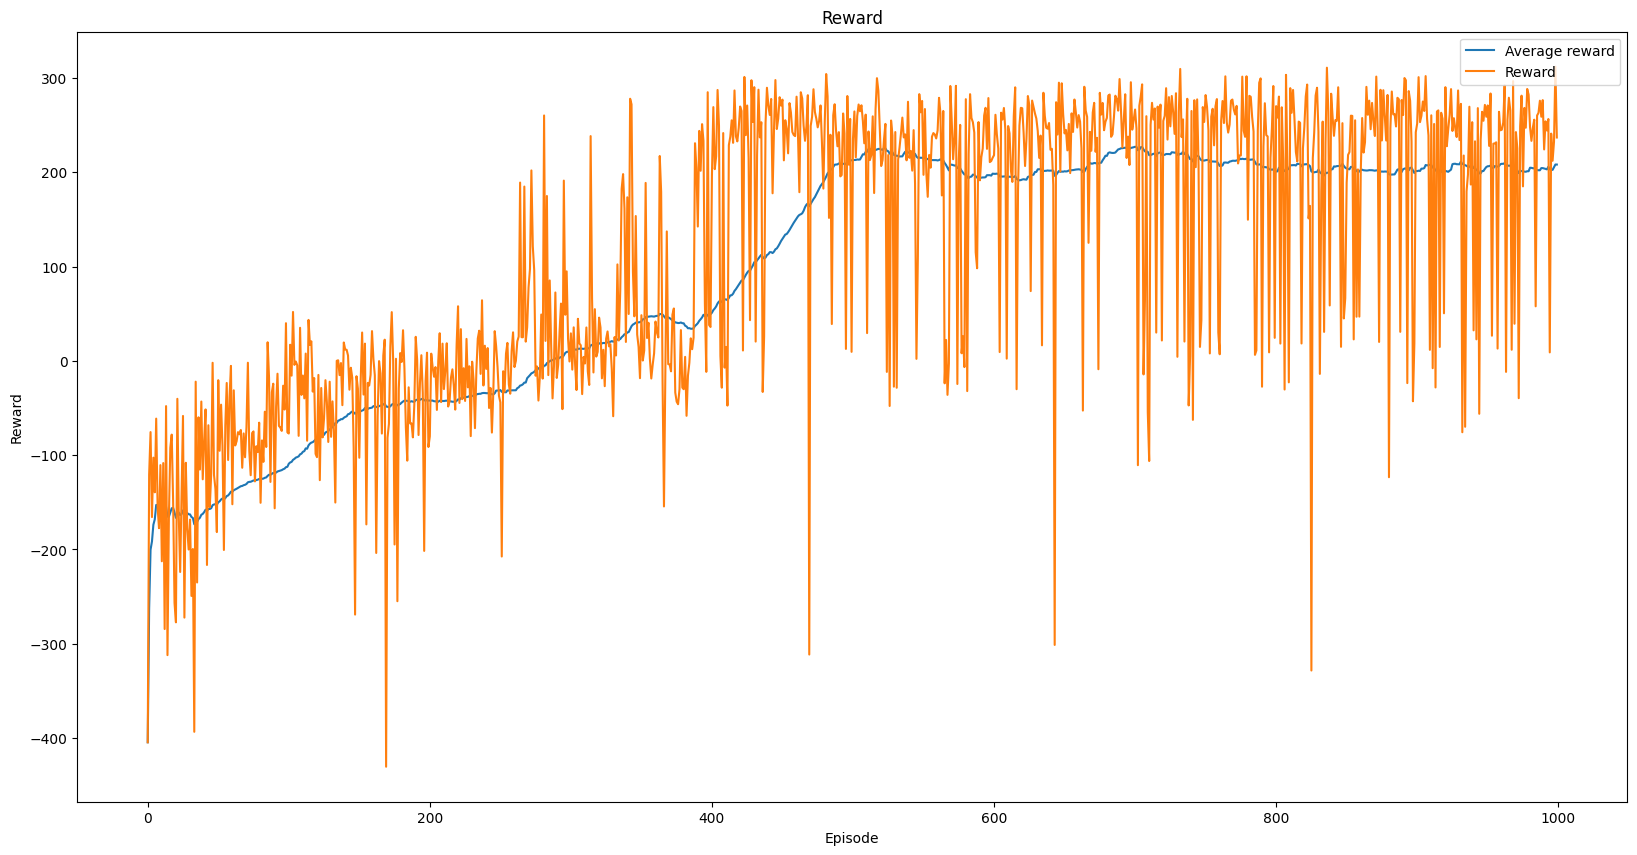

In [16]:
data = pd.read_csv(file_logger.file_name, sep=';')

plt.figure(figsize=(20,10))
plt.plot(data['average'])
plt.plot(data['reward'])
plt.title('Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Average reward', 'Reward'], loc='upper right')
plt.show()

# Creating a video of the model playing the game

In [17]:
def create_video(filename, env, q_network, fps=30):

    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        env.reset()
        state = env.reset()
        state = state[0]
        frame = env.render()
        video.append_data(frame)
        while not done:
            state = np.append(state, 0.0)
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

In [18]:
def embed_mp4(filename):

    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)

In [19]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [20]:
filename = "./lunar_lander.mp4"
create_video(filename, env, model)

[swscaler @ 0x6ba2600] Warning: data is not aligned! This can lead to a speed loss


# Playing the video

In [21]:
embed_mp4("./lunar_lander.mp4")